In [1]:
import argparse

def args_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument('--epochs', type=int, default=2000, help="rounds of training")

    #嵌入向量的训练轮次
    parser.add_argument('--emb_train_epochs', type=int, default=200, help="rounds of training")
    parser.add_argument('--emb', default=True)
    
    #验证RL和Fedavg哪个更好的验证轮次
    parser.add_argument('--validation_epochs', type=int, default=50, help="rounds of training")
    
    #有多少个local client
    parser.add_argument('--num_users', type=int, default=100, help="number of users: K")
    
    #每次选多少个local client参与训练
    parser.add_argument('--frac', type=float, default=0.1, help="the fraction of clients: C")
    
    #local client自己本地训练的轮次
    parser.add_argument('--local_ep', type=int, default=3, help="the number of local epochs: E")
    
    #local client本地训练的batchsize
    parser.add_argument('--local_bs', type=int, default=2, help="local batch size: B")
    parser.add_argument('--bs', type=int, default=128, help="test batch size")
    
    #RL的学习率和衰减率
    parser.add_argument('--lr', type=float, default=0.001, help="learning rate (default: 0.01)")
    parser.add_argument('--lr_decay', type=float, default=1, help="lr decay")
    parser.add_argument('--momentum', type=float, default=0.5, help="SGD momentum (default: 0.5)")
    parser.add_argument('--split', type=str, default='user', help="train-test split type, user or sample")

    # model arguments
    
    #使用的client 模型
    parser.add_argument('--model', type=str, default='cnn', help='model name')
    parser.add_argument('--kernel_num', type=int, default=9, help='number of each kind of kernel')
    parser.add_argument('--kernel_sizes', type=str, default='3,4,5',
                        help='comma-separated kernel size to use for convolution')
    parser.add_argument('--norm', type=str, default='batch_norm', help="batch_norm, layer_norm, or None")
    parser.add_argument('--num_filters', type=int, default=32, help="number of filters for conv nets")
    parser.add_argument('--max_pool', type=str, default='True',
                        help="Whether use max pooling rather than strided convolutions")

    # other arguments
    
    #使用的数据集
    parser.add_argument('--dataset', type=str, default='mnist', help="name of dataset")
    
    #数据集的划分是否满足独立同分布
    parser.add_argument('--iid', action='store_true', help='whether i.i.d or not')
    
    #输出的分类个数
    parser.add_argument('--num_classes', type=int, default=10, help="number of classes")
    
    #输入的图片的通道数
    parser.add_argument('--num_channels', type=int, default=1, help="number of channels of imges")
    parser.add_argument('--gpu', type=int, default=-1, help="GPU ID, -1 for CPU")
    parser.add_argument('--stopping_rounds', type=int, default=10, help='rounds of early stopping')
    parser.add_argument('--verbose', action='store_true', help='verbose print')
    parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')
    parser.add_argument('--all_clients', action='store_true', help='aggregation over all clients')
    parser.add_argument('--noise_factor', type=float, default=0.3)
#     parser.add_argument('--test_noise_factor', type=float, default=0.3)
      
    #resnet parameter
    parser.add_argument('--depth', type=int, default=38)
    parser.add_argument('--bottleneck', type=bool, default=False)
    args = parser.parse_args(args=[])
    return args

In [2]:
import pickle
from itertools import count

import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from torch.autograd import grad
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from torch.autograd import Variable

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import random
from torchvision import datasets, transforms
from collections import deque
  
from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from models.Update import LocalUpdate
from models.Update_add_noise import LocalUpdateNoise
from models.Nets import MLP, CNNMnist, CNNCifar, CNNMnistEmbcwl
from models.Fed import FedAvg
from models.test import test_img
from models.resnet import ResNet

In [3]:
args = args_parser()
#args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
args.device = 'cuda:1'
args.dataset = 'mnist'
args.model = 'cnn'
args.num_channels = 1
args.iid = True
# load dataset and split users
if args.dataset == 'mnist':
    trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
    dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)
    # sample users
    if args.iid:
        dict_users = mnist_iid(dataset_train, args.num_users)
    else:
        dict_users = mnist_noniid(dataset_train, args.num_users)
elif args.dataset == 'cifar':
    trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset_train = datasets.CIFAR10('../data/cifar', train=True, download=True, transform=trans_cifar)
    dataset_test = datasets.CIFAR10('../data/cifar', train=False, download=True, transform=trans_cifar)
    if args.iid:
        dict_users = cifar_iid(dataset_train, args.num_users)
    else:
        exit('Error: only consider IID setting in CIFAR10')
else:
    exit('Error: unrecognized dataset')
img_size = dataset_train[0][0].shape

# build model
if args.model == 'cnn' and args.dataset == 'cifar':
    net_glob = CNNCifar(args=args).to(args.device)
elif args.model == 'cnn' and args.dataset == 'mnist':
    net_glob = CNNMnist(args=args).to(args.device)
elif args.model == 'mlp':
    len_in = 1
    for x in img_size:
        len_in *= x
    net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
else:
    exit('Error: unrecognized model')
print(net_glob)
net_glob.train()

# copy weights
w_glob = net_glob.state_dict()

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


CNNMnist(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [4]:
class MemoryBuffer: # MemoryBuffer类实现的功能：buffer内采样，往buffer里塞（sars）

    def __init__(self, size):
        self.buffer = deque(maxlen=size) #buffer设置为双端队列
        self.maxSize = size
        self.len = 0
        
    def state_reco(self, s):
        s_1 = [i[0] for i in s]
        s_2 = [i[1] for i in s]
        s_3 = [i[2] for i in s]
        return [torch.cat(s_1),torch.cat(s_2),torch.cat(s_3)]

    def sample(self, count):
        """
        samples a random batch from the replay memory buffer
        :param count: batch size
        :return: batch (numpy array)
        """
        batch = []
        count = min(count, self.len)
        batch = random.sample(self.buffer, count) # 随机取样

        s_arr = [arr[0] for arr in batch]
        a_arr = torch.cat([arr[1] for arr in batch])
        r_arr = torch.tensor([arr[2] for arr in batch]).reshape(-1,1)
        s1_arr = [arr[3] for arr in batch]

        return self.state_reco(s_arr), a_arr, r_arr, self.state_reco(s1_arr)

    def len(self):
        return self.len

    def add(self, s, a, r, s1):
        """
        adds a particular transaction in the memory buffer
        :param s: current state
        :param a: action taken
        :param r: reward received
        :param s1: next state
        :return:
        """
        transition = (s,a,r,s1)
        self.len += 1
        if self.len > self.maxSize:
            self.len = self.maxSize
        self.buffer.append(transition)

In [5]:
class Actor(nn.Module):
    def __init__(self, parameter_dim, loss_dim, action_dim, args):
        super(Actor, self).__init__()
        self.args = args
        self.parameter_dim = parameter_dim
        self.loss_dim = loss_dim
        self.action_dim = action_dim
        
        self.fc1 = nn.Linear(parameter_dim, action_dim)
        self.fc2 = nn.Linear(action_dim*(int(args.num_users*args.frac+2)), self.action_dim)
#         self.ln2 = nn.LayerNorm(256)
#         self.fc3 = nn.Linear(256, self.action_dim)
#         self.fc4 = nn.Linear(256, 1)
        
    def forward(self, parameters, last_loss, last_weight):
        parameter_lst = []
        for i in range(self.action_dim):
            parameter_lst.append(self.fc1(parameters[:,i,:]))
        parameter_layer = torch.cat(parameter_lst,dim=1)
        x = torch.cat([parameter_layer,last_loss, last_weight],dim=1)
#         x = self.fc2(x1.clone()) # 256
#         x = self.ln2(x)
#         x3 = F.sigmoid(self.fc3(x2))
#         acc = F.sigmoid(self.fc4(x))
#         output = F.softmax(self.fc2(x),dim=1)
#         x2 = F.sigmoid(x2.clone())
#         for i in range(len(x2)):
#             tmp = torch.sum(x2[i])
#             x2[i] = x2[i]/tmp
        x = self.fc2(x)
        action = F.softmax(x,dim=1)
        return action

class Critic(nn.Module):
    def __init__(self, parameter_dim, loss_dim, action_dim, args):
        super(Critic, self).__init__()
        self.args = args
        self.parameter_dim = parameter_dim
        self.loss_dim = loss_dim
        self.action_dim = action_dim

        self.fc1 = nn.Linear(parameter_dim,action_dim)

        self.fc2 = nn.Linear(action_dim*(int(args.num_users*args.frac+3)), 1)

    def forward(self, parameters, last_loss, last_weight, action):
        parameter_lst = []
        for i in range(self.action_dim):
            parameter_lst.append(self.fc1(parameters[:,i,:]))
        parameter_layer = torch.cat(parameter_lst,dim=1)
        x = torch.cat([parameter_layer, last_loss, last_weight, action], dim=1)
        q = self.fc2(x)

        return q

In [6]:
GAMMA=0.95
class Trainer:

    def __init__(self, parameter_dim, loss_dim, action_dim, replay_buffer, args):
        self.parameter_dim = parameter_dim
        self.loss_dim = loss_dim
        self.action_dim = action_dim
        self.replay_buffer = replay_buffer
        self.iter = 0
        self.loss_critic_save = []
        self.loss_actor_save = []
        self.args = args
        #self.noise = utils.OrnsteinUhlenbeckActionNoise(self.action_dim)

        self.actor = Actor(self.parameter_dim, 
                                 self.loss_dim, 
                                 self.action_dim, args).to(args.device)
        self.target_actor = Actor(self.parameter_dim, 
                                 self.loss_dim, 
                                 self.action_dim, args).to(args.device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),0.01)

        self.critic = Critic(self.parameter_dim, 
                                 self.loss_dim, 
                                 self.action_dim, args).to(args.device)
        self.target_critic = Critic(self.parameter_dim, 
                                 self.loss_dim, 
                                 self.action_dim, args).to(args.device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),0.01)

        self.hard_update(self.target_actor, self.actor)
        self.hard_update(self.target_critic, self.critic)

    def soft_update(self, target, source, tau):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - tau) + param.data * tau
            )
    def hard_update(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
                target_param.data.copy_(param.data)
                
    def get_exploitation_action(self, parameters, last_loss, last_weight):
        action = self.target_actor.forward(parameters, last_loss, last_weight).detach()
        return action.data.numpy()

#     def get_exploration_action(self, state):
#         """
#         gets the action from actor added with exploration noise
#         :param state: state (Numpy array)
#         :return: sampled action (Numpy array)
#         """
#         state = Variable(torch.from_numpy(state))
#         action = self.actor.forward(state).detach()
#         new_action = action.data.numpy() + (self.noise.sample())
#         return new_action

    def optimize(self):
        """
        Samples a random batch from replay memory and performs optimization
        :return:
        """
        with torch.autograd.set_detect_anomaly(True):
            s1,a1,r1,s2 = self.replay_buffer.sample(40)
#                 print('s11:',s1[1])
#                 print('a1:',a1)
#             s1 = Variable(torch.from_numpy(np.array(s1)))
#             a1 = Variable(torch.from_numpy(np.array(a1)))
#             r1 = Variable(r1.float(), requires_grad=True)
            r1 = r1.to(self.args.device)
            r1 = Variable(r1)
            a1 = Variable(a1)
            for i in range(len(s1)):
                s1[i] = Variable(s1[i])
                s2[i] = Variable(s2[i])

#             s2 = Variable(torch.from_numpy(np.array(s2)))
            # ---------------------- optimize critic ----------------------
            # Use target actor exploitation policy here for loss evaluation
            # 这里应该是TD的方法
            a2 = self.target_actor.forward(s2[0],s2[1],s2[2]).detach()
            next_val = torch.squeeze(self.target_critic.forward(s2[0],s2[1],s2[2], a2).detach())
            y_expected = torch.squeeze(r1,dim=1) + GAMMA*next_val
            y_predicted = torch.squeeze(self.critic.forward(s1[0],s1[1],s1[2], a1))
#             print('grad:',s1[0].requires_grad, a1.requires_grad)
#             print('ye:',y_expected)
#             print('yp:',y_predicted)
            loss_critic = F.smooth_l1_loss(y_predicted.float(), y_expected.float())
            self.critic_optimizer.zero_grad()
#             loss_critic.backward(retain_graph=True)
            loss_critic.backward()
            self.critic_optimizer.step()
            self.loss_critic_save.append(loss_critic)
            # ---------------------- optimize actor ----------------------
            pred_a1 = self.actor.forward(s1[0],s1[1],s1[2])
            loss_actor = -1*torch.sum(self.critic.forward(s1[0],s1[1],s1[2], pred_a1))
            self.actor_optimizer.zero_grad()
#             loss_actor.backward(retain_graph=True)
            loss_actor.backward()
            self.actor_optimizer.step()
            self.loss_actor_save.append(loss_actor)
            
            self.soft_update(self.target_actor, self.actor, 0.001)
            self.soft_update(self.target_critic, self.critic, 0.001)

        # if self.iter % 100 == 0:
        #     print 'Iteration :- ', self.iter, ' Loss_actor :- ', loss_actor.data.numpy(),\
        #         ' Loss_critic :- ', loss_critic.data.numpy()
        # self.iter += 1

    def save_models(self, episode_count):
        torch.save(self.target_actor.state_dict(), './Models/' + str(episode_count) + '_actor.pt')
        torch.save(self.target_critic.state_dict(), './Models/' + str(episode_count) + '_critic.pt')
        
    def load_models(self, episode):
        self.actor.load_state_dict(torch.load('./Models/' + str(episode) + '_actor.pt'))
        self.critic.load_state_dict(torch.load('./Models/' + str(episode) + '_critic.pt'))
        utils.hard_update(self.target_actor, self.actor)
        utils.hard_update(self.target_critic, self.critic)

In [7]:
def weight_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
         torch.nn.init.xavier_normal_(m.weight.data)
         torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('Linear') != -1:
         torch.nn.init.xavier_normal_(m.weight)
         torch.nn.init.constant_(m.bias, 0.0)

In [8]:
layer_name = []
count = 0
for name in w_glob.keys():
    if count % 2 == 0:
        layer_name.append(name.split('.',1)[0])
    count += 1
    
parameter_cnn = None
for i in layer_name:
    if parameter_cnn is None:
        parameter_cnn = torch.cat([w_glob[i + '.weight'].reshape(1, -1),
                                   w_glob[i + '.bias'].reshape(1, -1)], 1)
    else:
        parameter_cnn = torch.cat([parameter_cnn,
                                   w_glob[i + '.weight'].reshape(1, -1),
                                   w_glob[i + '.bias'].reshape(1, -1)], 1)
Emb_Net = CNNMnistEmbcwl(parameter_cnn.numel(), args).to(args.device)

optimizer = torch.optim.Adam([{'params':Emb_Net.parameters()}], 0.001)
criterion = nn.MSELoss(reduction='mean')

In [9]:
Emb_Net = torch.load('./model_save/emb_{}_{}.pkl'.format(args.dataset, args.iid))
Emb_Net.to(args.device)

CNNMnistEmbcwl(
  (layer_input): Linear(in_features=26474, out_features=512, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layer_hidden): Linear(in_features=512, out_features=100, bias=True)
  (mlp): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU(inplace=True)
  )
  (c1_weights): Linear(in_features=128, out_features=250, bias=True)
  (c1_bias): Linear(in_features=128, out_features=10, bias=True)
  (c2_weights): Linear(in_features=128, out_features=5000, bias=True)
  (c2_bias): Linear(in_features=128, out_features=20, bias=True)
  (l1_weights): Linear(in_features=128, out_features=16000, bias=True)
  (l1_bias): Linear(in_features=128, out_features=50, bias=True)
  (l2_weights): Linear(in_features=128, out_features=500, bias=True)
  (l2_bias): Linear(in_features=128, out_features=10, bias=True)
  (whether_noise1): Linear(in_features=100, out_features=32, bias=True)
  (whether_noise2): Linear(in_features=32, out_features

In [12]:
loss_save = []
loss1_save = []
loss2_save = []

if args.model == 'cnn' and args.dataset == 'cifar':
    net_glob = CNNCifar(args=args).to(args.device)
elif args.model == 'cnn' and args.dataset == 'mnist':
    net_glob = CNNMnist(args=args).to(args.device)
elif args.model == 'mlp':
    len_in = 1
    for x in img_size:
        len_in *= x
    net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
else:
    exit('Error: unrecognized model')
net_glob.train()

noise_num = 50
last_parameter = {}
for iter in range(args.emb_train_epochs):
    w_locals = []
    if iter % 20 == 0:
        net_glob.apply(weight_init)
        net_glob.train()
    parameter_cnn_list = []
    noise_flag = None
    noise_idx = np.random.choice(range(args.num_users), 50, replace=False)
    noise_vector = []
    for idx in range(100):
        if idx in noise_idx:
            add_noise = 1
            noise_vector.append(0)
        else:
            add_noise = 0
            noise_vector.append(1)
        local = LocalUpdateNoise(args=args, dataset=dataset_train, idxs=dict_users[idx],
                                add_noise=add_noise)
        w, loss, net = local.train(net=copy.deepcopy(net_glob).to(args.device))
        w_locals.append(copy.deepcopy(w))
        parameter_cnn = None
        for i in layer_name:
            if parameter_cnn is None:
                parameter_cnn = torch.cat([w[i + '.weight'].reshape(1, -1),
                                           w[i + '.bias'].reshape(1, -1)], 1)
            else:
                parameter_cnn = torch.cat([parameter_cnn,
                                           w[i + '.weight'].reshape(1, -1),
                                           w[i + '.bias'].reshape(1, -1)], 1)
        parameter_cnn_list.append(parameter_cnn)
        #######################部分加入“加入噪音”标记############################
        if not add_noise:
            if noise_flag is None:
                noise_flag = torch.ones((1, 1))
            else:
                noise_flag = torch.cat([noise_flag, torch.ones((1, 1))], 0)
        else:
            if noise_flag is None:
                noise_flag = torch.zeros((1, 1))
            else:
                noise_flag = torch.cat([noise_flag, torch.zeros((1, 1))], 0)
        #######################部分加入“加入噪音”标记############################
    w_avg_glob = FedAvg(w_locals)
    net_glob.load_state_dict(w_avg_glob)
    parameter_cnn_final = torch.cat(parameter_cnn_list, 0)

    emb_cnn = Emb_Net.forward(parameter_cnn_final)
    predict_noise = Emb_Net.forward2(emb_cnn)
#     transform_w = Emb_Net.Reverse_raw_emb(emb_cnn)
#     loss1 = criterion(transform_w.reshape(-1, 1), parameter_cnn_final.reshape(-1, 1))
    loss2 = criterion(noise_flag.to(args.device), predict_noise)
#     print(noise_flag)
#     print(predict_noise)
#     loss = loss1 + loss2
    loss = loss2
    optimizer.zero_grad()
    # loss.backward(retain_graph=True)
    loss.backward()
    optimizer.step()
    print('epoch:{}, loss_avg:{}'.format(iter, loss))
#     print('loss1', loss1)
#     print('loss2', loss2)
    loss_save.append(loss)
    if iter > 0 and iter % 40 == 0:
        torch.save(Emb_Net, './model_save/emb_{}_{}.pkl'.format(args.dataset, args.iid))
#     loss1_save.append(loss1)
#     loss2_save.append(loss2)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch:0, loss_avg:0.2644670903682709
epoch:1, loss_avg:0.2527306377887726
epoch:2, loss_avg:0.2528538703918457
epoch:3, loss_avg:0.2524676024913788
epoch:4, loss_avg:0.24912132322788239
epoch:5, loss_avg:0.24982288479804993
epoch:6, loss_avg:0.24914021790027618
epoch:7, loss_avg:0.24765390157699585
epoch:8, loss_avg:0.24880842864513397
epoch:9, loss_avg:0.25125426054000854
epoch:10, loss_avg:0.2536831200122833
epoch:11, loss_avg:0.24905988574028015
epoch:12, loss_avg:0.25294557213783264
epoch:13, loss_avg:0.25088825821876526
epoch:14, loss_avg:0.25062790513038635
epoch:15, loss_avg:0.2557680606842041
epoch:16, loss_avg:0.25544142723083496
epoch:17, loss_avg:0.2548271417617798
epoch:18, loss_avg:0.2521514892578125
epoch:19, loss_avg:0.2484501153230667
epoch:20, loss_avg:0.24866575002670288
epoch:21, loss_avg:0.2621188759803772
epoch:22, loss_avg:0.268393337726593
epoch:23, loss_avg:0.25980329513549805
epoch:24, loss_avg:0.2620423436164856
epoch:25, loss_avg:0.2610493302345276
epoch:26, 

In [13]:
torch.save(Emb_Net, './model_save/emb_{}_{}.pkl'.format(args.dataset, args.iid))

In [9]:
Emb_Net = torch.load('./model_save/emb_{}_{}.pkl'.format(args.dataset, args.iid))
Emb_Net.to(args.device)

CNNMnistEmbcwl(
  (layer_input): Linear(in_features=26474, out_features=512, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layer_hidden): Linear(in_features=512, out_features=100, bias=True)
  (mlp): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU(inplace=True)
  )
  (c1_weights): Linear(in_features=128, out_features=250, bias=True)
  (c1_bias): Linear(in_features=128, out_features=10, bias=True)
  (c2_weights): Linear(in_features=128, out_features=5000, bias=True)
  (c2_bias): Linear(in_features=128, out_features=20, bias=True)
  (l1_weights): Linear(in_features=128, out_features=16000, bias=True)
  (l1_bias): Linear(in_features=128, out_features=50, bias=True)
  (l2_weights): Linear(in_features=128, out_features=500, bias=True)
  (l2_bias): Linear(in_features=128, out_features=10, bias=True)
  (whether_noise1): Linear(in_features=100, out_features=32, bias=True)
  (whether_noise2): Linear(in_features=32, out_features

In [10]:
%matplotlib inline

plt.plot(range(len(loss_save)), loss_save, c='r')
# plt.plot(range(len(loss1_save)), loss1_save, c='b')
# plt.plot(range(len(loss2_save)), loss2_save, c='g')
plt.show()

NameError: name 'loss_save' is not defined

In [14]:
from sklearn.manifold import TSNE
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

args.emb = False

p_emb_collect = []
emb_array = np.array([])
net_glob.apply(weight_init)
net_glob.train()
noise_num = 80
noise_idx = np.random.choice(range(args.num_users), noise_num, replace=False)

noise_list = []
for iter in range(5):
#     noise_idx = np.random.choice(range(args.num_users), noise_num, replace=False)
    w_locals = []
    parameter_cnn_list = []
    for idx in range(100):
        if idx in noise_idx:
            add_noise = 1
            noise_list.append(idx+iter*100)
        else:
            add_noise = 0
        local = LocalUpdateNoise(args=args, dataset=dataset_train, idxs=dict_users[idx], 
                                add_noise=add_noise)
        w, loss, net = local.train(net=copy.deepcopy(net_glob).to(args.device))
        w_locals.append(w)
        ############ 储存参数 ##############
        parameter_cnn = None
        for i in layer_name:
            if parameter_cnn is None:
                parameter_cnn = torch.cat([w[i + '.weight'].reshape(1, -1),
                                           w[i + '.bias'].reshape(1, -1)], 1)
            else:
                parameter_cnn = torch.cat([parameter_cnn,
                                           w[i + '.weight'].reshape(1, -1),
                                           w[i + '.bias'].reshape(1, -1)], 1)
        emb_cnn = Emb_Net.forward(parameter_cnn.to(args.device))
        p_emb_collect.append(emb_cnn.cpu().detach().numpy().tolist()[0])
    w_avg_glob = FedAvg(w_locals)
    net_glob.load_state_dict(w_avg_glob)
            
emb_array_noise = np.array(p_emb_collect)
emb_all = emb_array_noise
mat1 = TSNE(n_components=2, init='pca').fit_transform(emb_all)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


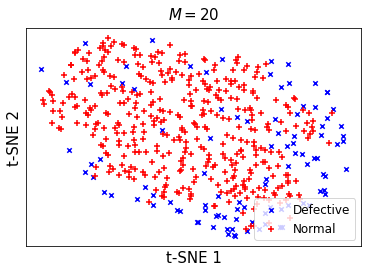

In [18]:
%matplotlib inline
x = []
y = []
x_noise = []
y_noise = []
for i in range(500):
    if i in noise_list:
        x_noise.append(mat1[i][0])
        y_noise.append(mat1[i][1])
    else:
        x.append(mat1[i][0])
        y.append(mat1[i][1])
plt.scatter(x, y, s=20, c='b', marker='x', label='Defective')
plt.scatter(x_noise, y_noise, s=30, c='r', marker='+', label='Normal')
plt.xlabel('t-SNE 1', fontsize=15)
plt.ylabel('t-SNE 2', fontsize=15)
plt.xticks([])
plt.yticks([])
plt.title('$M=20%$',fontsize=15,loc='center',verticalalignment='bottom') #fontweight='bold'
plt.legend(fontsize=12, loc='lower right')
plt.show()

In [12]:
parameter_dim = 100
action_dim = int(args.num_users*args.frac)
loss_dim = int(args.num_users*args.frac)
replay_buffer = MemoryBuffer(1000)

In [13]:
trainer = Trainer(parameter_dim, loss_dim, action_dim, replay_buffer, args)

In [16]:
def FedPareto(w,action):
    w_avg = copy.deepcopy(w[0])
    for k in w_avg.keys():
        for i in range(0, len(w)):
            if i==0:
                w_avg[k] = action[i] * w[i][k]
            else:
                w_avg[k] += action[i] * w[i][k]
    return w_avg

In [17]:
class Actor1(nn.Module):
    def __init__(self, parameter_dim):
        super(Actor1, self).__init__()
        self.args = args
        self.parameter_dim = parameter_dim
        self.action_dim = 1
        
        self.fc1 = nn.Linear(parameter_dim, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 256)
        self.fc4 = nn.Linear(256, self.action_dim)
        self.fc5 = nn.Linear(256, 1)

        
    def forward(self, parameters):

        x = F.relu(self.fc1(parameters)) # 256
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        output = F.sigmoid(self.fc4(x))
        acc = F.sigmoid(self.fc5(x))
        # output = self.fc4(x)
        return output, acc

In [17]:
sl_model = torch.load('./model_save/supervised_{}_{}.pkl'.format(args.dataset, args.iid))

In [18]:
# training
import math

reward_save = []

constant = 64
target_acc = 0.99
args.emb = False

last_replay_data = []

if args.model == 'cnn' and args.dataset == 'cifar':
    net_avg = CNNCifar(args=args).to(args.device)
elif args.model == 'cnn' and args.dataset == 'mnist':
    net_avg = CNNMnist(args=args).to(args.device)
elif args.model == 'mlp':
    len_in = 1
    for x in img_size:
        len_in *= x
    net_avg = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
else:
    exit('Error: unrecognized model')

noise_num = 70

net_rule = CNNMnist(args=args).to(args.device)
net_glob = CNNMnist(args=args).to(args.device)


for iter in range(args.epochs):
    if iter % 20 == 0:
        noise_idx = np.random.choice(range(args.num_users), noise_num, replace=False)
    
    if iter==0:
        random_n = 0
        n_weight = []
        while random_n < args.num_users*args.frac:
            n_weight.append(random.random()) # 随机初始化参数
            random_n += 1
        action = F.softmax(torch.tensor(n_weight))
        
    loss_locals = []
    w_locals = []
    m = max(int(args.frac * args.num_users), 1)
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
#     idxs_users = [i for i in range(10)]
    p_collect = []
    
    
    w_glob = net_glob.state_dict()
    parameter_cnn = None
    for i in layer_name:
        if parameter_cnn is None:
            parameter_cnn = torch.cat([w_glob[i + '.weight'].reshape(1, -1),
                                       w_glob[i + '.bias'].reshape(1, -1)], 1)
        else:
            parameter_cnn = torch.cat([parameter_cnn,
                                       w_glob[i + '.weight'].reshape(1, -1),
                                       w_glob[i + '.bias'].reshape(1, -1)], 1)
    emb_cnn = Emb_Net.forward(parameter_cnn)
    p_collect.append(emb_cnn) 
    
    noise_vector = []
    #只收集local，用于noise predict
    p_local_collect = []
    count = 0
    for idx in idxs_users:
        if idx in noise_idx:
            add_noise = 1
            noise_vector.append(0.)
        else:
            add_noise = 0
            noise_vector.append(1.)
        local = LocalUpdateNoise(args=args, dataset=dataset_train, idxs=dict_users[idx], add_noise=add_noise)
        w, loss, net = local.train(net=copy.deepcopy(net_glob).to(args.device))
        a, l = test_img(net, dataset_test, args)
        print('acc{}:{}-noise{}'.format(idx, a, add_noise))
        ############ 储存参数 ##############
        parameter_cnn = None
        for i in layer_name:
            if parameter_cnn is None:
                parameter_cnn = torch.cat([w[i + '.weight'].reshape(1, -1),
                                           w[i + '.bias'].reshape(1, -1)], 1)
            else:
                parameter_cnn = torch.cat([parameter_cnn,
                                           w[i + '.weight'].reshape(1, -1),
                                           w[i + '.bias'].reshape(1, -1)], 1)
        emb_cnn = Emb_Net.forward(parameter_cnn)
        p_collect.append(emb_cnn)
        p_local_collect.append(emb_cnn)
        ############ 储存loss ##############
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
        
#         if count == 0:
#             sl_res, _ = sl_model.policy_net(parameter_cnn)
# #             action = trainer.policy_net.forward(parameter_cnn)
#             sl_res = sl_res.detach()
#         else:
#             sl_res_, _ = sl_model.policy_net.forward(parameter_cnn)
# #             a_ = trainer.policy_net.forward(parameter_cnn)
#             sl_res_ = sl_res_.detach()
#             sl_res = torch.cat((sl_res, sl_res_), 1)
#         count += 1
    
#     sl_res = sl_res.squeeze(0)/torch.sum(sl_res.squeeze(0))    
    p_collect = torch.cat(p_collect).unsqueeze(0).to(args.device) # parameter_dim * 11
    p_local_collect = torch.cat(p_local_collect).unsqueeze(0).to(args.device) # parameter_dim * 10
    action_next = trainer.actor(p_collect,
                                          torch.tensor(loss_locals).reshape(1,-1).to(args.device), 
                                          action.reshape(1,-1).to(args.device))[0] #s = [p, loss, last_action]
    noise_predict = Emb_Net.forward2(p_local_collect)
    noise_predict = noise_predict.squeeze(0).squeeze(1)
#     print('torch.tensor(loss_locals).reshape(1,-1)', torch.tensor(loss_locals).reshape(1,-1))
        
    print('epoch{}--action:{}'.format(iter, action_next))
    ###########计算当前轮的reward，然后将当前轮的reward添加到上一个replay_data中
    # update global weights
#     w_avg_glob = FedAvg(w_locals)
    w_glob = FedPareto(w_locals, action_next)
    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)
#     net_avg.load_state_dict(w_avg_glob)
    
#     reward = -sum(loss_locals) / len(loss_locals)
    net_glob.eval()
    global_acc, loss_train = test_img(net_glob, dataset_test, args)
#     avg_acc, _ = test_img(net_avg, dataset_test, args)
    print('global acc:',global_acc)

    
#     print('sl_res:',sl_res)
    global_acc_cpu = global_acc.cpu()
    
    beta1 = 0.5
    beta2 = 0.5
    reward1 = constant ** (global_acc_cpu.numpy()/100 - target_acc) - 1
    mseloss = torch.nn.MSELoss()
#     reward2 = mseloss(sl_res, action_next)
    noise_vector = torch.tensor(noise_vector).to(args.device)
    noise_vector = noise_vector.squeeze(0)/torch.sum(noise_vector.squeeze(0))
    print('noise:',noise_vector)
    reward2 = mseloss(noise_vector, action_next)
#     reward = beta1*reward1
    reward = beta1*reward1 - beta2*reward2
    if math.isnan(reward):
        print('nan')
        continue
    reward_save.append(reward)
    
    if len(last_replay_data)==3:
        last_replay_data.append([p_collect.float(), 
                                 torch.tensor(loss_locals).reshape(1,-1).float().to(args.device), 
                                 action.reshape(1,-1).float().to(args.device)])#s_next
        trainer.replay_buffer.add(last_replay_data[0],
                                  last_replay_data[1],
                                  last_replay_data[2],
                                  last_replay_data[3])
    last_replay_data = [[p_collect.float(), 
                         torch.tensor(loss_locals).reshape(1,-1).float().to(args.device), 
                         action.reshape(1,-1).float().to(args.device)], 
                        action_next.reshape(1,-1).float().to(args.device), float(reward)]#s, a, r
    action = action_next
    # print loss
    print('Round {:3d}, reward {:.3f}'.format(iter, reward))
    
    if iter > 40 and iter % 20 == 0:
        for i in range(20):
            trainer.optimize()
    if iter % 100 == 0:
        if args.model == 'cnn' and args.dataset == 'cifar':
            net_glob = CNNCifar(args=args).to(args.device)
        elif args.model == 'cnn' and args.dataset == 'mnist':
            net_glob = CNNMnist(args=args).to(args.device)
        elif args.model == 'mlp':
            len_in = 1
            for x in img_size:
                len_in *= x
            net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
        else:
            exit('Error: unrecognized model')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


acc36:10.429999351501465-noise1
acc53:53.709999084472656-noise0
acc93:11.25-noise1
acc10:64.61000061035156-noise0
acc8:11.710000038146973-noise1
acc40:11.139999389648438-noise1
acc37:14.179999351501465-noise1
acc87:11.359999656677246-noise1
acc78:9.649999618530273-noise1
acc98:13.460000038146973-noise1
epoch0--action:tensor([0.1858, 0.1319, 0.1296, 0.0419, 0.1070, 0.0683, 0.0499, 0.0528, 0.1230,
        0.1099], device='cuda:1', grad_fn=<SelectBackward>)
global acc: tensor(18.1100, device='cuda:1')
noise: tensor([0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round   0, reward -0.505
acc61:13.649999618530273-noise1
acc67:40.66999816894531-noise0
acc57:13.339999198913574-noise1
acc37:11.859999656677246-noise1
acc7:10.279999732971191-noise1
acc53:37.849998474121094-noise0
acc47:9.059999465942383-noise1
acc70:6.859999656677246-noise1
acc87:12.00999927520752-noise1
acc12:6.659999847412109-noise1
epoch1--action:tensor([0.1871, 0.135

acc41:49.03999710083008-noise1
acc91:88.6500015258789-noise0
acc95:52.32999801635742-noise1
acc7:53.29999923706055-noise1
acc34:90.04000091552734-noise0
acc63:56.44999694824219-noise1
acc99:89.23999786376953-noise0
acc29:46.68000030517578-noise1
acc28:40.13999938964844-noise1
acc51:47.77000045776367-noise1
epoch13--action:tensor([0.1830, 0.1202, 0.1268, 0.0470, 0.0984, 0.0806, 0.0501, 0.0787, 0.0900,
        0.1252], device='cuda:1', grad_fn=<SelectBackward>)
global acc: tensor(82.1000, device='cuda:1')
noise: tensor([0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round  13, reward -0.266
acc98:49.55999755859375-noise1
acc51:35.2599983215332-noise1
acc11:91.12999725341797-noise0
acc40:36.34000015258789-noise1
acc58:90.15999603271484-noise0
acc26:25.579999923706055-noise1
acc25:41.7599983215332-noise1
acc29:38.189998626708984-noise1
acc90:35.46999740600586-noise1
acc75:90.29999542236328-noise0
epoch14--action:tensor([0.1598, 0.1

acc27:40.279998779296875-noise1
acc31:93.05999755859375-noise0
acc95:92.86000061035156-noise0
acc5:26.10999870300293-noise1
acc20:43.84000015258789-noise1
acc61:37.119998931884766-noise1
acc96:92.5199966430664-noise0
acc87:92.8499984741211-noise0
acc75:29.6299991607666-noise1
acc0:20.19999885559082-noise1
epoch26--action:tensor([0.1682, 0.1020, 0.1371, 0.0540, 0.1070, 0.0615, 0.0481, 0.0856, 0.1320,
        0.1046], device='cuda:1', grad_fn=<SelectBackward>)
global acc: tensor(88.7500, device='cuda:1')
noise: tensor([0.0000, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.2500, 0.2500, 0.0000,
        0.0000], device='cuda:1')
Round  26, reward -0.182
acc49:35.709999084472656-noise1
acc7:42.80999755859375-noise1
acc69:93.22999572753906-noise0
acc87:92.93999481201172-noise0
acc97:32.279998779296875-noise1
acc75:19.989999771118164-noise1
acc39:52.16999816894531-noise1
acc73:92.88999938964844-noise0
acc41:35.20000076293945-noise1
acc21:91.05999755859375-noise0
epoch27--action:tensor([0.1612, 0.

global acc: tensor(44.6500, device='cuda:1')
noise: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:1')
Round  38, reward -0.493
acc71:27.349998474121094-noise1
acc46:28.809999465942383-noise1
acc60:18.6299991607666-noise1
acc62:94.0999984741211-noise0
acc73:94.08999633789062-noise0
acc94:93.44999694824219-noise0
acc30:18.85999870300293-noise1
acc20:39.41999816894531-noise1
acc6:94.0999984741211-noise0
acc38:29.09000015258789-noise1
epoch39--action:tensor([0.1695, 0.1144, 0.1134, 0.0407, 0.1264, 0.0863, 0.0630, 0.0493, 0.1146,
        0.1224], device='cuda:1', grad_fn=<SelectBackward>)
global acc: tensor(89.8300, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.2500,
        0.0000], device='cuda:1')
Round  39, reward -0.168
acc11:94.0999984741211-noise0
acc32:31.1299991607666-noise1
acc74:30.90999984741211-noise1
acc44:23.989999771118164-noise1
acc27:28.049999237060547-noise1
acc41:22.899999618530273-noise1
acc61:27.129999

global acc: tensor(81.5500, device='cuda:1')
noise: tensor([0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round  51, reward -0.273
acc97:33.56999969482422-noise1
acc42:29.25-noise1
acc98:18.939998626708984-noise1
acc22:29.78999900817871-noise1
acc47:24.479999542236328-noise1
acc86:94.58999633789062-noise0
acc36:22.1299991607666-noise1
acc53:21.889999389648438-noise1
acc84:20.869998931884766-noise1
acc20:22.94999885559082-noise1
epoch52--action:tensor([0.1813, 0.1085, 0.1273, 0.0433, 0.1269, 0.0614, 0.0593, 0.0563, 0.1382,
        0.0976], device='cuda:1', grad_fn=<SelectBackward>)
global acc: tensor(31.3100, device='cuda:1')
noise: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], device='cuda:1')
Round  52, reward -0.520
acc68:94.88999938964844-noise0
acc38:95.27999877929688-noise0
acc2:19.09000015258789-noise1
acc74:23.969999313354492-noise1
acc57:94.94999694824219-noise0
acc39:95.13999938964844-noise0
acc27:22.10000038146972

acc68:13.179999351501465-noise1
acc71:14.829999923706055-noise1
epoch64--action:tensor([9.9926e-01, 7.7415e-12, 4.1427e-11, 3.7902e-12, 1.7382e-11, 5.6397e-12,
        3.5774e-12, 7.4015e-04, 2.3160e-11, 6.2369e-12], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(94.2500, device='cuda:1')
noise: tensor([0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round  64, reward -0.115
acc61:94.94999694824219-noise0
acc13:94.65999603271484-noise0
acc12:16.10999870300293-noise1
acc21:27.049999237060547-noise1
acc8:25.829999923706055-noise1
acc70:17.329999923706055-noise1
acc84:29.119998931884766-noise1
acc74:29.939998626708984-noise1
acc57:21.010000228881836-noise1
acc80:95.15999603271484-noise0
epoch65--action:tensor([9.9900e-01, 6.3293e-11, 2.1537e-10, 3.0933e-11, 8.7545e-11, 5.2145e-11,
        2.9155e-11, 1.0012e-03, 1.1272e-10, 4.1585e-11], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(94.95

acc15:94.66999816894531-noise0
acc54:15.369999885559082-noise1
acc1:95.05999755859375-noise0
acc60:94.68999481201172-noise0
acc22:21.59000015258789-noise1
acc39:23.84000015258789-noise1
acc94:95.44999694824219-noise0
epoch76--action:tensor([9.9720e-01, 5.8776e-09, 2.8405e-08, 4.7839e-09, 1.1128e-08, 5.4489e-09,
        3.4891e-09, 2.8014e-03, 1.3496e-08, 5.2817e-09], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(13.1200, device='cuda:1')
noise: tensor([0.0000, 0.1667, 0.1667, 0.1667, 0.0000, 0.1667, 0.1667, 0.0000, 0.0000,
        0.1667], device='cuda:1')
Round  76, reward -0.544
acc24:95.23999786376953-noise0
acc99:95.18999481201172-noise0
acc8:18.93000030517578-noise1
acc71:11.389999389648438-noise1
acc87:21.739999771118164-noise1
acc64:13.329999923706055-noise1
acc88:14.50999927520752-noise1
acc84:16.229999542236328-noise1
acc72:11.739999771118164-noise1
acc76:95.32999420166016-noise0
epoch77--action:tensor([9.9537e-01, 6.2226e-09, 2.1867e-08, 2.6544e-09, 7.2

acc14:11.319999694824219-noise1
acc84:13.219999313354492-noise1
acc53:94.75999450683594-noise0
acc74:11.670000076293945-noise1
acc73:12.569999694824219-noise1
acc79:13.359999656677246-noise1
acc59:10.920000076293945-noise1
acc72:12.819999694824219-noise1
acc38:93.2699966430664-noise0
acc4:13.979999542236328-noise1
epoch88--action:tensor([2.1667e-05, 1.6246e-13, 7.6496e-13, 7.6054e-14, 2.9938e-13, 8.2810e-14,
        4.4754e-14, 9.9998e-01, 6.8484e-13, 1.5123e-13], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(12.8200, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000,
        0.0000], device='cuda:1')
Round  88, reward -0.561
acc94:13.219999313354492-noise1
acc70:14.879999160766602-noise1
acc8:11.880000114440918-noise1
acc37:15.609999656677246-noise1
acc15:92.69999694824219-noise0
acc98:13.839999198913574-noise1
acc21:12.039999961853027-noise1
acc1:12.880000114440918-noise1
acc51:13.029999732971191-noise1
acc60

acc79:22.239999771118164-noise1
acc82:11.90999984741211-noise1
acc36:95.54000091552734-noise0
acc13:31.28999900817871-noise1
acc26:28.90999984741211-noise1
acc32:26.189998626708984-noise1
acc70:23.219999313354492-noise1
acc41:31.19999885559082-noise1
acc3:21.559999465942383-noise1
acc60:95.05999755859375-noise0
epoch100--action:tensor([6.5612e-05, 5.1207e-12, 2.5190e-11, 2.6385e-12, 6.6938e-12, 2.4261e-12,
        1.2878e-12, 9.9993e-01, 1.6580e-11, 3.6086e-12], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(31.2000, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.5000], device='cuda:1')
Round 100, reward -0.545
acc19:60.73999786376953-noise0
acc33:56.07999801635742-noise0
acc32:7.759999752044678-noise1
acc81:47.459999084472656-noise0
acc31:9.139999389648438-noise1
acc80:49.36000061035156-noise0
acc9:10.319999694824219-noise1
acc6:7.579999923706055-noise1
acc60:60.619998931884766-noise0
acc54:10.689

global acc: tensor(27.4100, device='cuda:1')
noise: tensor([0.2000, 0.0000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000, 0.2000, 0.2000,
        0.0000], device='cuda:1')
Round 111, reward -0.515
acc1:64.6500015258789-noise0
acc63:12.549999237060547-noise1
acc97:59.959999084472656-noise0
acc94:27.649999618530273-noise1
acc36:62.21999740600586-noise0
acc76:17.439998626708984-noise1
acc12:26.44999885559082-noise1
acc82:24.68000030517578-noise1
acc48:67.83999633789062-noise0
acc41:29.079999923706055-noise1
epoch112--action:tensor([4.6941e-07, 1.9681e-10, 1.1649e-09, 7.5276e-11, 2.3201e-10, 1.0495e-10,
        7.6322e-11, 1.0000e+00, 3.6546e-10, 1.2937e-10], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(24.6800, device='cuda:1')
noise: tensor([0.2500, 0.0000, 0.2500, 0.0000, 0.2500, 0.0000, 0.0000, 0.0000, 0.2500,
        0.0000], device='cuda:1')
Round 112, reward -0.540
acc40:57.57999801635742-noise0
acc20:59.04999923706055-noise0
acc5:14.309999465942383-noise1
acc55:16

global acc: tensor(47.9800, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.1667, 0.0000, 0.1667, 0.1667, 0.1667, 0.0000, 0.1667,
        0.1667], device='cuda:1')
Round 123, reward -0.498
acc48:47.31999969482422-noise1
acc76:46.439998626708984-noise1
acc12:81.25999450683594-noise0
acc16:46.69999694824219-noise1
acc37:42.599998474121094-noise1
acc81:37.189998626708984-noise1
acc46:44.89999771118164-noise1
acc2:47.03999710083008-noise1
acc85:41.62999725341797-noise1
acc13:33.82999801635742-noise1
epoch124--action:tensor([4.8668e-09, 2.5359e-12, 1.9069e-11, 9.9364e-13, 3.3706e-12, 1.1322e-12,
        8.7912e-13, 1.0000e+00, 6.4554e-12, 1.6831e-12], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(47.0400, device='cuda:1')
noise: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:1')
Round 124, reward -0.542
acc15:30.06999969482422-noise1
acc52:38.029998779296875-noise1
acc80:81.79999542236328-noise0
acc46:33.82999801635742-noise1
acc33:36.439998626708984-

global acc: tensor(23.3100, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.2500, 0.0000, 0.2500, 0.2500, 0.0000, 0.0000,
        0.2500], device='cuda:1')
Round 135, reward -0.541
acc52:20.6299991607666-noise1
acc8:23.119998931884766-noise1
acc42:17.549999237060547-noise1
acc17:28.229999542236328-noise1
acc49:26.309999465942383-noise1
acc51:19.25-noise1
acc90:19.18000030517578-noise1
acc85:21.18000030517578-noise1
acc26:20.18000030517578-noise1
acc35:27.920000076293945-noise1
epoch136--action:tensor([1.0336e-09, 4.8182e-13, 3.6515e-12, 1.9019e-13, 5.8336e-13, 2.3462e-13,
        1.3643e-13, 1.0000e+00, 1.0895e-12, 3.0625e-13], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(21.1800, device='cuda:1')
noise: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:1')
nan
acc26:28.3799991607666-noise1
acc86:22.649999618530273-noise1
acc47:13.339999198913574-noise1
acc37:16.670000076293945-noise1
acc27:23.579999923706055-noise1
acc23:86.61000

global acc: tensor(18.0400, device='cuda:1')
noise: tensor([0.0000, 0.2500, 0.0000, 0.0000, 0.2500, 0.0000, 0.2500, 0.0000, 0.0000,
        0.2500], device='cuda:1')
Round 147, reward -0.545
acc24:11.59999942779541-noise1
acc89:89.18999481201172-noise0
acc32:11.710000038146973-noise1
acc4:87.72999572753906-noise0
acc97:88.90999603271484-noise0
acc58:18.579999923706055-noise1
acc59:11.920000076293945-noise1
acc42:23.94999885559082-noise1
acc45:27.19999885559082-noise1
acc20:19.229999542236328-noise1
epoch148--action:tensor([7.6483e-10, 6.9008e-13, 4.0486e-12, 2.6383e-13, 8.1728e-13, 3.8840e-13,
        1.8607e-13, 1.0000e+00, 1.3087e-12, 4.1620e-13], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(23.9500, device='cuda:1')
noise: tensor([0.0000, 0.3333, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 148, reward -0.545
acc23:12.34999942779541-noise1
acc74:15.809999465942383-noise1
acc40:86.86000061035156-noise0
acc72:1

global acc: tensor(31.4300, device='cuda:1')
noise: tensor([0.1667, 0.1667, 0.1667, 0.0000, 0.0000, 0.0000, 0.1667, 0.0000, 0.1667,
        0.1667], device='cuda:1')
Round 159, reward -0.528
acc68:90.33999633789062-noise0
acc22:14.389999389648438-noise1
acc0:91.2699966430664-noise0
acc71:91.25-noise0
acc55:90.93999481201172-noise0
acc72:91.04000091552734-noise0
acc99:12.65999984741211-noise1
acc96:21.329999923706055-noise1
acc43:90.48999786376953-noise0
acc10:28.309999465942383-noise1
epoch160--action:tensor([4.5991e-09, 1.0195e-11, 5.3938e-11, 5.5395e-12, 1.3227e-11, 5.8930e-12,
        4.0119e-12, 1.0000e+00, 2.6096e-11, 7.3858e-12], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(21.3300, device='cuda:1')
noise: tensor([0.1667, 0.0000, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000, 0.1667,
        0.0000], device='cuda:1')
Round 160, reward -0.539
acc19:17.149999618530273-noise1
acc52:90.52999877929688-noise0
acc70:19.279998779296875-noise1
acc12:21.70999908447

global acc: tensor(14.1200, device='cuda:1')
noise: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:1')
nan
acc19:20.059999465942383-noise1
acc36:18.639999389648438-noise1
acc39:87.93000030517578-noise0
acc47:15.279999732971191-noise1
acc31:86.73999786376953-noise0
acc16:22.09000015258789-noise1
acc79:13.869999885559082-noise1
acc66:16.3799991607666-noise1
acc41:7.779999732971191-noise1
acc86:85.93000030517578-noise0
epoch172--action:tensor([7.5679e-13, 2.4033e-16, 2.3308e-15, 9.5931e-17, 3.0585e-16, 9.5100e-17,
        5.7781e-17, 1.0000e+00, 6.1739e-16, 1.7691e-16], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(16.3800, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333], device='cuda:1')
Round 172, reward -0.551
acc26:89.25999450683594-noise0
acc31:88.07999420166016-noise0
acc67:21.15999984741211-noise1
acc95:16.85999870300293-noise1
acc90:21.279998779296875-noise1
acc3

acc24:90.72000122070312-noise0
acc99:53.529998779296875-noise1
acc29:66.48999786376953-noise1
acc43:91.62999725341797-noise0
acc90:58.69999694824219-noise1
acc76:44.619998931884766-noise1
acc87:91.30999755859375-noise0
acc23:48.73999786376953-noise1
acc58:54.2599983215332-noise1
acc2:62.03999710083008-noise1
epoch184--action:tensor([4.7731e-11, 4.3363e-14, 3.1683e-13, 2.4957e-14, 5.3934e-14, 2.3869e-14,
        1.4737e-14, 1.0000e+00, 1.0509e-13, 2.9910e-14], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(48.7400, device='cuda:1')
noise: tensor([0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 184, reward -0.505
acc60:49.82999801635742-noise1
acc27:49.38999938964844-noise1
acc49:51.459999084472656-noise1
acc1:41.959999084472656-noise1
acc38:42.15999984741211-noise1
acc53:41.77000045776367-noise1
acc98:42.36000061035156-noise1
acc80:56.28999710083008-noise1
acc86:42.27000045776367-noise1
acc41:92.139999

acc19:91.82999420166016-noise0
acc80:59.619998931884766-noise1
acc11:48.81999969482422-noise1
acc72:53.73999786376953-noise1
acc18:26.139999389648438-noise1
acc2:65.81999969482422-noise1
acc81:66.04999542236328-noise1
acc56:90.87999725341797-noise0
acc54:61.15999984741211-noise1
acc88:32.80999755859375-noise1
epoch196--action:tensor([5.7034e-12, 2.4783e-15, 1.6470e-14, 1.0762e-15, 3.4237e-15, 9.2445e-16,
        6.7391e-16, 1.0000e+00, 7.3854e-15, 1.3825e-15], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(90.8800, device='cuda:1')
noise: tensor([0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000,
        0.0000], device='cuda:1')
Round 196, reward -0.168
acc76:46.12999725341797-noise1
acc89:48.5099983215332-noise1
acc66:92.0999984741211-noise0
acc63:55.62999725341797-noise1
acc87:91.62999725341797-noise0
acc3:92.36000061035156-noise0
acc65:57.8599967956543-noise1
acc62:58.12999725341797-noise1
acc35:54.40999984741211-noise1
acc93:28.9299983978

acc70:15.539999961853027-noise1
acc0:43.20000076293945-noise0
acc28:15.960000038146973-noise1
acc81:32.029998779296875-noise0
acc50:11.609999656677246-noise1
acc92:17.520000457763672-noise1
acc60:36.97999954223633-noise0
acc56:17.53999900817871-noise1
acc89:18.059999465942383-noise1
acc18:54.959999084472656-noise0
epoch208--action:tensor([2.5838e-12, 7.6629e-16, 7.9677e-15, 3.1715e-16, 9.8647e-16, 3.3594e-16,
        1.8701e-16, 1.0000e+00, 2.0955e-15, 4.7594e-16], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(17.5400, device='cuda:1')
noise: tensor([0.0000, 0.2500, 0.0000, 0.2500, 0.0000, 0.0000, 0.2500, 0.0000, 0.0000,
        0.2500], device='cuda:1')
Round 208, reward -0.546
acc29:17.28999900817871-noise1
acc22:15.359999656677246-noise1
acc7:24.649999618530273-noise0
acc23:15.420000076293945-noise1
acc12:11.789999961853027-noise1
acc76:16.65999984741211-noise1
acc2:48.5099983215332-noise0
acc58:13.630000114440918-noise1
acc74:15.269999504089355-noise1
acc36:2

global acc: tensor(23.9800, device='cuda:1')
noise: tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:1')
Round 219, reward -0.578
acc87:18.85999870300293-noise1
acc61:17.149999618530273-noise1
acc69:19.19999885559082-noise1
acc64:59.939998626708984-noise0
acc36:66.75999450683594-noise0
acc88:12.779999732971191-noise1
acc39:62.48999786376953-noise0
acc55:19.270000457763672-noise1
acc17:66.44999694824219-noise0
acc58:19.0-noise1
epoch220--action:tensor([6.9220e-13, 1.7680e-16, 2.0213e-15, 7.7013e-17, 2.2749e-16, 7.6873e-17,
        4.3739e-17, 1.0000e+00, 4.9978e-16, 1.2038e-16], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(19.2700, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.2500, 0.2500, 0.0000, 0.2500, 0.0000, 0.2500,
        0.0000], device='cuda:1')
Round 220, reward -0.544
acc94:18.010000228881836-noise1
acc97:65.31999969482422-noise0
acc32:13.6899995803833-noise1
acc9:20.850000381469727-noise1
acc10:23.56999969482422-noise1
acc56:

global acc: tensor(86.7200, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.2000, 0.2000, 0.2000,
        0.2000], device='cuda:1')
Round 231, reward -0.240
acc16:40.779998779296875-noise1
acc64:90.4000015258789-noise0
acc73:89.18000030517578-noise0
acc88:44.05999755859375-noise1
acc52:53.14999771118164-noise1
acc49:88.95999908447266-noise0
acc62:89.11000061035156-noise0
acc81:47.16999816894531-noise1
acc48:46.779998779296875-noise1
acc33:45.66999816894531-noise1
epoch232--action:tensor([2.8374e-14, 7.7833e-18, 1.0299e-16, 5.3652e-18, 1.4203e-17, 2.9483e-18,
        2.4869e-18, 1.0000e+00, 3.4742e-17, 5.7059e-18], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(47.1700, device='cuda:1')
noise: tensor([0.0000, 0.2500, 0.2500, 0.0000, 0.0000, 0.2500, 0.2500, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 232, reward -0.505
acc23:33.75-noise1
acc84:36.14999771118164-noise1
acc14:42.40999984741211-noise1
acc68:33.0400009155273

global acc: tensor(37.9700, device='cuda:1')
noise: tensor([0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.5000], device='cuda:1')
Round 243, reward -0.535
acc17:30.779998779296875-noise1
acc95:89.77999877929688-noise0
acc16:34.29999923706055-noise1
acc61:90.81999969482422-noise0
acc80:29.029998779296875-noise1
acc74:41.14999771118164-noise1
acc7:35.439998626708984-noise1
acc57:25.03999900817871-noise1
acc11:29.799999237060547-noise1
acc8:26.989999771118164-noise1
epoch244--action:tensor([2.2782e-14, 7.1268e-18, 7.4356e-17, 3.7372e-18, 1.1007e-17, 3.4712e-18,
        1.5991e-18, 1.0000e+00, 2.3663e-17, 5.5590e-18], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(25.0400, device='cuda:1')
noise: tensor([0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 244, reward -0.552
acc0:90.50999450683594-noise0
acc15:25.349998474121094-noise1
acc97:30.09000015258789-noise1
acc43:22

global acc: tensor(91.6400, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000,
        0.3333], device='cuda:1')
Round 255, reward -0.165
acc64:47.07999801635742-noise1
acc92:24.549999237060547-noise1
acc75:91.04999542236328-noise0
acc62:92.0999984741211-noise0
acc35:91.69999694824219-noise0
acc72:92.41999816894531-noise0
acc38:92.43999481201172-noise0
acc3:34.02000045776367-noise1
acc43:52.619998931884766-noise1
acc76:31.26999855041504-noise1
epoch256--action:tensor([1.1382e-12, 1.0472e-15, 1.1662e-14, 6.6317e-16, 1.8612e-15, 4.8755e-16,
        3.6629e-16, 1.0000e+00, 3.3401e-15, 9.3691e-16], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(34.0200, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 256, reward -0.526
acc88:29.939998626708984-noise1
acc99:25.59000015258789-noise1
acc45:22.549999237060547-noise1
acc29:92.

global acc: tensor(93.5100, device='cuda:1')
noise: tensor([0.0000, 0.2000, 0.0000, 0.2000, 0.2000, 0.0000, 0.0000, 0.2000, 0.0000,
        0.2000], device='cuda:1')
Round 267, reward -0.142
acc85:44.57999801635742-noise1
acc69:18.18000030517578-noise1
acc50:46.13999938964844-noise1
acc89:37.68000030517578-noise1
acc56:44.80999755859375-noise1
acc87:93.48999786376953-noise0
acc96:59.43000030517578-noise1
acc90:93.16999816894531-noise0
acc21:31.299999237060547-noise1
acc4:27.469999313354492-noise1
epoch268--action:tensor([5.2714e-13, 1.2644e-16, 1.2744e-15, 6.0449e-17, 2.4005e-16, 4.6322e-17,
        3.6154e-17, 1.0000e+00, 4.9463e-16, 8.3456e-17], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(93.1700, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000, 0.0000,
        0.0000], device='cuda:1')
Round 268, reward -0.133
acc17:34.09000015258789-noise1
acc83:20.34000015258789-noise1
acc98:24.719999313354492-noise1
acc27:40.

global acc: tensor(31.7800, device='cuda:1')
noise: tensor([0.2000, 0.2000, 0.0000, 0.2000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000,
        0.2000], device='cuda:1')
Round 279, reward -0.529
acc79:94.39999389648438-noise0
acc8:93.69999694824219-noise0
acc75:23.1299991607666-noise1
acc4:23.549999237060547-noise1
acc6:19.3799991607666-noise1
acc98:17.350000381469727-noise1
acc74:28.81999969482422-noise1
acc97:93.65999603271484-noise0
acc9:23.010000228881836-noise1
acc38:23.03999900817871-noise1
epoch280--action:tensor([4.0139e-14, 2.0169e-17, 1.6070e-16, 1.1621e-17, 2.9099e-17, 8.9946e-18,
        4.0412e-18, 1.0000e+00, 7.6897e-17, 1.3474e-17], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(93.6600, device='cuda:1')
noise: tensor([0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000], device='cuda:1')
Round 280, reward -0.133
acc94:52.029998779296875-noise1
acc16:93.8699951171875-noise0
acc45:52.87999725341797-noise1
acc33:56.37999

acc60:20.69999885559082-noise1
epoch291--action:tensor([5.7124e-14, 7.5469e-18, 8.9121e-17, 3.2111e-18, 1.1820e-17, 2.6010e-18,
        2.3687e-18, 1.0000e+00, 2.4973e-17, 4.6161e-18], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(19.7900, device='cuda:1')
noise: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], device='cuda:1')
Round 291, reward -0.581
acc31:12.960000038146973-noise1
acc16:93.07999420166016-noise0
acc49:10.09999942779541-noise1
acc26:94.33999633789062-noise0
acc5:19.920000076293945-noise1
acc96:25.939998626708984-noise1
acc73:93.69999694824219-noise0
acc80:12.029999732971191-noise1
acc83:18.520000457763672-noise1
acc34:93.82999420166016-noise0
epoch292--action:tensor([7.7655e-13, 5.7136e-16, 4.9836e-15, 3.1686e-16, 7.4779e-16, 2.9760e-16,
        1.5276e-16, 1.0000e+00, 1.7103e-15, 3.7110e-16], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(12.0300, device='cuda:1')
noise: tensor([0.0000, 0.2500, 0.0000, 0.2500, 0.0000, 0.00

acc64:17.059999465942383-noise1
acc43:31.489999771118164-noise1
acc37:79.93000030517578-noise0
acc21:14.559999465942383-noise1
acc54:26.979999542236328-noise1
epoch303--action:tensor([3.6747e-14, 8.7709e-18, 9.8167e-17, 3.5440e-18, 1.2638e-17, 3.3992e-18,
        1.8927e-18, 1.0000e+00, 3.1637e-17, 5.6158e-18], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(79.9300, device='cuda:1')
noise: tensor([0.0000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.2000, 0.0000,
        0.0000], device='cuda:1')
Round 303, reward -0.314
acc28:87.33999633789062-noise0
acc55:52.029998779296875-noise1
acc33:85.18000030517578-noise0
acc91:43.70000076293945-noise1
acc32:34.52000045776367-noise1
acc29:34.97999954223633-noise1
acc12:48.59000015258789-noise1
acc77:86.83999633789062-noise0
acc8:41.75-noise1
acc94:86.95999908447266-noise0
epoch304--action:tensor([1.3046e-13, 7.0956e-17, 6.9560e-16, 3.4283e-17, 8.8641e-17, 2.5367e-17,
        1.8871e-17, 1.0000e+00, 2.2507e-16, 4.0319e

acc34:89.38999938964844-noise0
acc38:43.279998779296875-noise1
acc69:36.849998474121094-noise1
acc90:38.77000045776367-noise1
acc39:89.93999481201172-noise0
acc58:35.939998626708984-noise1
acc55:24.989999771118164-noise1
acc29:37.02000045776367-noise1
epoch315--action:tensor([1.3385e-14, 5.3745e-18, 6.3005e-17, 3.7653e-18, 8.6522e-18, 2.4127e-18,
        1.4693e-18, 1.0000e+00, 2.1253e-17, 4.5185e-18], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(35.9400, device='cuda:1')
noise: tensor([0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.2500, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 315, reward -0.526
acc47:88.25-noise0
acc49:42.38999938964844-noise1
acc23:33.16999816894531-noise1
acc54:30.849998474121094-noise1
acc75:28.529998779296875-noise1
acc77:88.75999450683594-noise0
acc99:25.09000015258789-noise1
acc90:27.829999923706055-noise1
acc94:89.4000015258789-noise0
acc63:28.17999839782715-noise1
epoch316--action:tensor([2.2175e-15, 5.6630e-19, 6.69

acc31:91.37999725341797-noise0
acc58:17.10999870300293-noise1
acc55:28.26999855041504-noise1
acc5:19.420000076293945-noise1
acc10:39.64999771118164-noise1
acc56:26.92999839782715-noise1
acc89:20.889999389648438-noise1
acc72:91.3699951171875-noise0
acc42:21.40999984741211-noise1
acc88:19.03999900817871-noise1
epoch327--action:tensor([1.0424e-13, 2.9777e-17, 2.9273e-16, 1.4440e-17, 4.2937e-17, 1.1354e-17,
        8.7401e-18, 1.0000e+00, 1.1631e-16, 1.7963e-17], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(91.3700, device='cuda:1')
noise: tensor([0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000,
        0.0000], device='cuda:1')
Round 327, reward -0.161
acc95:26.260000228881836-noise1
acc48:12.210000038146973-noise1
acc83:34.65999984741211-noise1
acc9:92.47000122070312-noise0
acc67:41.209999084472656-noise1
acc32:23.969999313354492-noise1
acc87:24.729999542236328-noise1
acc18:19.520000457763672-noise1
acc91:33.14999771118164-noise1
acc94:32.22

acc91:9.789999961853027-noise1
acc52:90.04000091552734-noise0
acc63:9.819999694824219-noise1
acc14:10.279999732971191-noise1
acc84:10.420000076293945-noise1
acc78:9.920000076293945-noise1
acc22:91.5-noise0
acc38:10.329999923706055-noise1
acc23:10.279999732971191-noise1
acc15:10.239999771118164-noise1
epoch339--action:tensor([7.4710e-15, 1.2655e-18, 1.8069e-17, 6.2203e-19, 2.0353e-18, 5.6926e-19,
        3.3106e-19, 1.0000e+00, 4.3904e-18, 9.8518e-19], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(10.3300, device='cuda:1')
noise: tensor([0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 339, reward -0.562
acc27:92.0-noise0
acc41:90.97999572753906-noise0
acc97:10.279999732971191-noise1
acc1:9.929999351501465-noise1
acc50:91.98999786376953-noise0
acc74:10.809999465942383-noise1
acc64:10.319999694824219-noise1
acc23:10.369999885559082-noise1
acc21:10.269999504089355-noise1
acc53:10.399999618530273-noise1
e

global acc: tensor(93.6600, device='cuda:1')
noise: tensor([0.2000, 0.2000, 0.0000, 0.0000, 0.2000, 0.2000, 0.0000, 0.2000, 0.0000,
        0.0000], device='cuda:1')
Round 350, reward -0.140
acc66:24.959999084472656-noise1
acc25:93.44999694824219-noise0
acc44:11.9399995803833-noise1
acc69:15.079999923706055-noise1
acc34:93.48999786376953-noise0
acc37:24.729999542236328-noise1
acc94:93.23999786376953-noise0
acc85:23.939998626708984-noise1
acc33:16.510000228881836-noise1
acc52:19.510000228881836-noise1
epoch351--action:tensor([1.3782e-11, 1.0815e-14, 8.1486e-14, 4.9648e-15, 1.4251e-14, 6.1510e-15,
        2.8452e-15, 1.0000e+00, 2.2691e-14, 9.8983e-15], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(23.9400, device='cuda:1')
noise: tensor([0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 351, reward -0.545
acc1:16.18000030517578-noise1
acc85:19.889999389648438-noise1
acc59:15.059999465942383-noise1
acc4:

global acc: tensor(10.3500, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.2500, 0.0000, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 362, reward -0.550
acc77:92.30999755859375-noise0
acc75:10.449999809265137-noise1
acc99:11.289999961853027-noise1
acc45:92.79000091552734-noise0
acc65:92.29000091552734-noise0
acc58:10.300000190734863-noise1
acc44:93.11000061035156-noise0
acc0:92.90999603271484-noise0
acc70:92.61000061035156-noise0
acc82:10.469999313354492-noise1
epoch363--action:tensor([2.3621e-12, 2.3200e-15, 1.7638e-14, 1.0638e-15, 3.1374e-15, 1.1671e-15,
        7.3398e-16, 1.0000e+00, 6.2959e-15, 1.8421e-15], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(92.9100, device='cuda:1')
noise: tensor([0.1667, 0.0000, 0.0000, 0.1667, 0.1667, 0.0000, 0.1667, 0.1667, 0.1667,
        0.0000], device='cuda:1')
Round 363, reward -0.154
acc43:12.479999542236328-noise1
acc20:93.87999725341797-noise0
acc34:11.069999694824219-noise1
acc66:

global acc: tensor(27.5600, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.2000, 0.2000, 0.2000, 0.0000, 0.2000, 0.0000, 0.2000,
        0.0000], device='cuda:1')
Round 374, reward -0.534
acc54:93.5999984741211-noise0
acc20:94.06999969482422-noise0
acc65:94.18999481201172-noise0
acc77:94.08999633789062-noise0
acc43:14.819999694824219-noise1
acc21:15.949999809265137-noise1
acc89:17.049999237060547-noise1
acc17:30.31999969482422-noise1
acc73:15.799999237060547-noise1
acc59:13.219999313354492-noise1
epoch375--action:tensor([1.0130e-11, 1.1462e-14, 8.7502e-14, 7.1385e-15, 1.6876e-14, 6.1233e-15,
        4.0218e-15, 1.0000e+00, 3.2584e-14, 7.6142e-15], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(30.3200, device='cuda:1')
noise: tensor([0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 375, reward -0.534
acc50:15.90999984741211-noise1
acc78:93.19999694824219-noise0
acc99:18.44999885559082-noise1
acc61:1

global acc: tensor(11.3800, device='cuda:1')
noise: tensor([0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333,
        0.0000], device='cuda:1')
Round 386, reward -0.554
acc9:10.479999542236328-noise1
acc65:11.699999809265137-noise1
acc44:10.179999351501465-noise1
acc11:12.309999465942383-noise1
acc29:10.960000038146973-noise1
acc26:94.04999542236328-noise0
acc1:10.739999771118164-noise1
acc85:10.84999942779541-noise1
acc88:11.380000114440918-noise1
acc39:10.079999923706055-noise1
epoch387--action:tensor([3.6116e-11, 1.7515e-14, 1.5854e-13, 8.6247e-15, 2.7363e-14, 8.1356e-15,
        5.6561e-15, 1.0000e+00, 5.0600e-14, 1.1440e-14], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(10.8500, device='cuda:1')
noise: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], device='cuda:1')
Round 387, reward -0.587
acc41:10.210000038146973-noise1
acc95:14.609999656677246-noise1
acc78:93.88999938964844-noise0
acc91:10.130000114440918-noise1
acc6:10.34999942779

global acc: tensor(9.8600, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333], device='cuda:1')
Round 398, reward -0.554
acc8:94.68000030517578-noise0
acc48:10.1899995803833-noise1
acc65:10.269999504089355-noise1
acc90:94.19999694824219-noise0
acc39:9.819999694824219-noise1
acc97:9.84999942779541-noise1
acc85:10.319999694824219-noise1
acc2:94.44999694824219-noise0
acc63:9.84999942779541-noise1
acc92:94.56999969482422-noise0
epoch399--action:tensor([8.1563e-11, 8.9785e-14, 5.6271e-13, 4.0301e-14, 1.0077e-13, 4.2240e-14,
        2.6930e-14, 1.0000e+00, 2.0383e-13, 5.1451e-14], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(94.4500, device='cuda:1')
noise: tensor([0.2500, 0.0000, 0.0000, 0.2500, 0.0000, 0.0000, 0.0000, 0.2500, 0.0000,
        0.2500], device='cuda:1')
Round 399, reward -0.124
acc22:11.710000038146973-noise1
acc47:12.219999313354492-noise1
acc40:18.939998626708984-noise1
acc19:26.659

global acc: tensor(10.2600, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.5000,
        0.0000], device='cuda:1')
Round 410, reward -0.563
acc42:11.549999237060547-noise0
acc14:13.649999618530273-noise1
acc66:10.289999961853027-noise1
acc89:16.35999870300293-noise0
acc15:9.969999313354492-noise1
acc47:10.319999694824219-noise1
acc8:15.779999732971191-noise0
acc16:11.649999618530273-noise1
acc90:11.359999656677246-noise0
acc50:25.75-noise0
epoch411--action:tensor([1.3436e-13, 2.7473e-17, 3.2556e-16, 1.1599e-17, 3.5908e-17, 1.1404e-17,
        5.7173e-18, 1.0000e+00, 8.3826e-17, 1.6830e-17], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(11.6500, device='cuda:1')
noise: tensor([0.2000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000, 0.2000, 0.0000, 0.2000,
        0.2000], device='cuda:1')
Round 411, reward -0.547
acc83:12.1899995803833-noise1
acc46:11.519999504089355-noise1
acc57:16.760000228881836-noise0
acc94:13.1099996

global acc: tensor(33.5200, device='cuda:1')
noise: tensor([0.0000, 0.2500, 0.0000, 0.0000, 0.2500, 0.0000, 0.2500, 0.0000, 0.2500,
        0.0000], device='cuda:1')
Round 422, reward -0.530
acc35:27.920000076293945-noise1
acc8:33.21999740600586-noise1
acc93:36.25-noise1
acc32:55.81999969482422-noise0
acc41:34.369998931884766-noise1
acc50:22.59000015258789-noise1
acc37:29.17999839782715-noise1
acc44:33.790000915527344-noise1
acc36:63.07999801635742-noise0
acc97:58.07999801635742-noise0
epoch423--action:tensor([7.1204e-14, 1.9103e-17, 2.3171e-16, 8.3264e-18, 2.6993e-17, 8.2658e-18,
        4.5865e-18, 1.0000e+00, 6.5411e-17, 1.2898e-17], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(33.7900, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333,
        0.3333], device='cuda:1')
Round 423, reward -0.533
acc85:36.62999725341797-noise1
acc70:13.1899995803833-noise1
acc77:23.15999984741211-noise1
acc58:24.2399997711181

global acc: tensor(60.0100, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.2500,
        0.2500], device='cuda:1')
Round 434, reward -0.464
acc60:54.5-noise1
acc79:45.34000015258789-noise1
acc42:82.70999908447266-noise0
acc71:46.09000015258789-noise1
acc74:28.78999900817871-noise1
acc57:81.52999877929688-noise0
acc9:40.029998779296875-noise1
acc11:85.93999481201172-noise0
acc1:81.87999725341797-noise0
acc63:86.0-noise0
epoch435--action:tensor([2.4765e-13, 1.3536e-16, 1.3077e-15, 6.9837e-17, 1.7966e-16, 5.2905e-17,
        2.9343e-17, 1.0000e+00, 4.8083e-16, 8.5793e-17], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(85.9400, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.2000, 0.0000, 0.0000, 0.2000, 0.0000, 0.2000, 0.2000,
        0.2000], device='cuda:1')
Round 435, reward -0.250
acc94:50.65999984741211-noise1
acc63:87.80999755859375-noise0
acc84:48.25-noise1
acc10:24.56999969482422-noise1
acc71:51.2999992370

global acc: tensor(88.8000, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.2500,
        0.2500], device='cuda:1')
Round 446, reward -0.210
acc58:22.959999084472656-noise1
acc13:91.15999603271484-noise0
acc77:33.07999801635742-noise1
acc62:23.18000030517578-noise1
acc36:24.60999870300293-noise1
acc89:90.95999908447266-noise0
acc57:11.65999984741211-noise1
acc81:20.94999885559082-noise1
acc90:31.42999839782715-noise1
acc42:91.47000122070312-noise0
epoch447--action:tensor([4.6470e-13, 2.1961e-16, 1.7436e-15, 1.0429e-16, 2.7728e-16, 9.3494e-17,
        5.9402e-17, 1.0000e+00, 5.7389e-16, 1.1602e-16], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(20.9500, device='cuda:1')
noise: tensor([0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.3333], device='cuda:1')
Round 447, reward -0.547
acc9:10.649999618530273-noise1
acc17:90.7699966430664-noise0
acc21:91.32999420166016-noise0
acc4:17.520

global acc: tensor(25.3500, device='cuda:1')
noise: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:1')
nan
acc72:14.719999313354492-noise1
acc98:90.3699951171875-noise0
acc29:24.139999389648438-noise1
acc95:19.850000381469727-noise1
acc54:91.0999984741211-noise0
acc19:21.799999237060547-noise1
acc31:22.529998779296875-noise1
acc63:9.729999542236328-noise1
acc90:17.420000076293945-noise1
acc43:26.369998931884766-noise1
epoch459--action:tensor([1.0496e-13, 3.1012e-17, 3.0804e-16, 1.2971e-17, 4.2602e-17, 1.4197e-17,
        6.9195e-18, 1.0000e+00, 7.5207e-17, 2.2152e-17], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(9.7300, device='cuda:1')
noise: tensor([0.0000, 0.5000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 459, reward -0.563
acc25:10.739999771118164-noise1
acc89:90.77999877929688-noise0
acc19:9.719999313354492-noise1
acc10:9.960000038146973-noise1
acc98:91.97000122070312-noise0
acc

global acc: tensor(22.9300, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.3333], device='cuda:1')
Round 470, reward -0.546
acc95:14.429999351501465-noise1
acc63:12.829999923706055-noise1
acc59:92.97999572753906-noise0
acc37:16.03999900817871-noise1
acc51:10.239999771118164-noise1
acc40:92.72000122070312-noise0
acc22:13.289999961853027-noise1
acc87:16.90999984741211-noise1
acc68:93.13999938964844-noise0
acc14:93.63999938964844-noise0
epoch471--action:tensor([1.5324e-12, 1.0403e-15, 9.5457e-15, 5.5512e-16, 1.3872e-15, 4.1723e-16,
        3.2709e-16, 1.0000e+00, 3.0749e-15, 6.4304e-16], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(16.9100, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.2500, 0.0000, 0.0000, 0.2500, 0.0000, 0.0000, 0.2500,
        0.2500], device='cuda:1')
Round 471, reward -0.546
acc72:11.130000114440918-noise1
acc18:15.210000038146973-noise1
acc88:93.47000122070312-noise0
acc45

global acc: tensor(19.4400, device='cuda:1')
noise: tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:1')
Round 482, reward -0.582
acc6:13.569999694824219-noise1
acc19:13.359999656677246-noise1
acc56:93.80999755859375-noise0
acc77:11.75999927520752-noise1
acc5:14.569999694824219-noise1
acc46:93.39999389648438-noise0
acc17:11.359999656677246-noise1
acc94:93.30999755859375-noise0
acc85:94.12999725341797-noise0
acc81:11.40999984741211-noise1
epoch483--action:tensor([7.2730e-12, 5.5107e-15, 4.4937e-14, 3.0651e-15, 9.0801e-15, 2.0578e-15,
        1.6101e-15, 1.0000e+00, 2.3194e-14, 3.8671e-15], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(93.3100, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.2500, 0.0000, 0.0000, 0.2500, 0.0000, 0.2500, 0.2500,
        0.0000], device='cuda:1')
Round 483, reward -0.143
acc45:22.329999923706055-noise1
acc11:17.709999084472656-noise1
acc51:26.939998626708984-noise1
acc0:94.07999420166016-noise0
acc5:14.799999237060547-

global acc: tensor(93.4300, device='cuda:1')
noise: tensor([0.2000, 0.0000, 0.0000, 0.0000, 0.2000, 0.2000, 0.0000, 0.2000, 0.2000,
        0.0000], device='cuda:1')
Round 494, reward -0.143
acc29:38.22999954223633-noise1
acc16:60.91999816894531-noise1
acc48:94.29999542236328-noise0
acc97:28.920000076293945-noise1
acc19:56.56999969482422-noise1
acc99:26.56999969482422-noise1
acc39:21.60999870300293-noise1
acc26:94.47999572753906-noise0
acc54:14.319999694824219-noise1
acc32:52.79999923706055-noise1
epoch495--action:tensor([2.0362e-12, 6.3273e-16, 7.5854e-15, 2.9633e-16, 9.5540e-16, 2.1433e-16,
        1.5963e-16, 1.0000e+00, 2.6014e-15, 4.0454e-16], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(94.4800, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000,
        0.0000], device='cuda:1')
Round 495, reward -0.111
acc22:94.54999542236328-noise0
acc99:33.14999771118164-noise1
acc39:12.630000114440918-noise1
acc29:18

global acc: tensor(11.9400, device='cuda:1')
noise: tensor([0.0000, 0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 506, reward -0.553
acc32:13.989999771118164-noise1
acc57:9.809999465942383-noise1
acc73:9.899999618530273-noise1
acc30:8.65999984741211-noise1
acc4:17.28999900817871-noise1
acc8:15.34999942779541-noise1
acc14:8.399999618530273-noise1
acc40:9.75-noise1
acc90:10.1899995803833-noise1
acc17:6.639999866485596-noise1
epoch507--action:tensor([9.0042e-08, 7.5050e-11, 4.6235e-10, 2.8849e-11, 8.5522e-11, 3.9291e-11,
        2.5592e-11, 1.0000e+00, 1.3580e-10, 4.4009e-11], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(9.7500, device='cuda:1')
noise: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:1')
nan
acc43:49.57999801635742-noise0
acc1:44.23999786376953-noise0
acc80:14.299999237060547-noise1
acc44:10.800000190734863-noise1
acc3:44.71999740600586-noise0
acc38:38.71999740600586-n

global acc: tensor(43.3900, device='cuda:1')
noise: tensor([0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.2500], device='cuda:1')
Round 518, reward -0.513
acc5:29.309999465942383-noise1
acc41:28.599998474121094-noise1
acc21:24.619998931884766-noise1
acc81:88.33999633789062-noise0
acc99:19.5-noise1
acc89:32.5-noise1
acc47:25.8799991607666-noise1
acc61:27.19999885559082-noise1
acc27:34.97999954223633-noise1
acc16:25.920000076293945-noise1
epoch519--action:tensor([4.7223e-09, 4.2101e-12, 2.9592e-11, 1.7805e-12, 4.9236e-12, 2.3886e-12,
        1.3306e-12, 1.0000e+00, 9.5317e-12, 2.6522e-12], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(27.2000, device='cuda:1')
noise: tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:1')
Round 519, reward -0.575
acc29:32.88999938964844-noise1
acc50:88.08999633789062-noise0
acc84:88.5-noise0
acc46:87.95999908447266-noise0
acc69:86.93999481201172-noise0
acc53:88.4000015258789-noise0
acc5

global acc: tensor(89.3600, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.3333,
        0.0000], device='cuda:1')
Round 530, reward -0.198
acc93:14.149999618530273-noise1
acc46:90.57999420166016-noise0
acc50:90.68000030517578-noise0
acc41:16.69999885559082-noise1
acc43:13.59999942779541-noise1
acc31:11.59999942779541-noise1
acc37:14.329999923706055-noise1
acc68:89.27999877929688-noise0
acc33:17.31999969482422-noise1
acc11:12.170000076293945-noise1
epoch531--action:tensor([3.8708e-07, 9.2564e-10, 3.8862e-09, 4.2380e-10, 1.3629e-09, 4.3546e-10,
        2.4097e-10, 1.0000e+00, 2.4248e-09, 5.6722e-10], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(89.2800, device='cuda:1')
noise: tensor([0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000], device='cuda:1')
Round 531, reward -0.200
acc18:91.18999481201172-noise0
acc28:14.479999542236328-noise1
acc80:91.81999969482422-noise0
acc19:1

global acc: tensor(10.4100, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 542, reward -0.554
acc76:91.65999603271484-noise0
acc68:9.739999771118164-noise1
acc51:11.0-noise1
acc83:10.09000015258789-noise1
acc3:9.769999504089355-noise1
acc75:11.34999942779541-noise1
acc88:91.5199966430664-noise0
acc1:11.34999942779541-noise1
acc20:10.239999771118164-noise1
acc38:91.05999755859375-noise0
epoch543--action:tensor([2.0862e-08, 3.5218e-11, 2.0447e-10, 1.8172e-11, 3.7211e-11, 1.9718e-11,
        1.6292e-11, 1.0000e+00, 6.1068e-11, 1.9678e-11], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(11.3500, device='cuda:1')
noise: tensor([0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        0.3333], device='cuda:1')
Round 543, reward -0.554
acc41:9.84000015258789-noise1
acc25:11.34999942779541-noise1
acc93:11.420000076293945-noise1
acc92:91.55999755859375-no

global acc: tensor(11.4300, device='cuda:1')
noise: tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000, 0.1667, 0.0000, 0.1667,
        0.0000], device='cuda:1')
Round 554, reward -0.545
acc53:10.050000190734863-noise1
acc0:93.0-noise0
acc35:10.029999732971191-noise1
acc33:11.869999885559082-noise1
acc61:12.469999313354492-noise1
acc51:11.0-noise1
acc92:93.22000122070312-noise0
acc11:9.960000038146973-noise1
acc38:93.04000091552734-noise0
acc44:92.87999725341797-noise0
epoch555--action:tensor([6.9895e-09, 1.3325e-11, 6.5027e-11, 6.6083e-12, 1.2416e-11, 7.8328e-12,
        4.2784e-12, 1.0000e+00, 2.2338e-11, 7.9450e-12], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(9.9600, device='cuda:1')
noise: tensor([0.0000, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.0000, 0.2500,
        0.2500], device='cuda:1')
Round 555, reward -0.550
acc35:13.179999351501465-noise1
acc52:9.670000076293945-noise1
acc83:10.039999961853027-noise1
acc65:9.829999923706055-noise1
ac

global acc: tensor(11.4900, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000,
        0.2000], device='cuda:1')
Round 566, reward -0.547
acc73:92.72000122070312-noise0
acc68:10.15999984741211-noise1
acc53:11.460000038146973-noise1
acc59:93.44999694824219-noise0
acc89:11.59999942779541-noise1
acc49:10.0-noise1
acc15:93.3699951171875-noise0
acc55:93.77999877929688-noise0
acc32:10.979999542236328-noise1
acc51:8.670000076293945-noise1
epoch567--action:tensor([3.5090e-08, 1.1919e-10, 6.0617e-10, 7.8536e-11, 1.5233e-10, 7.8918e-11,
        5.0846e-11, 1.0000e+00, 2.8447e-10, 8.3029e-11], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(93.7800, device='cuda:1')
noise: tensor([0.2500, 0.0000, 0.0000, 0.2500, 0.0000, 0.0000, 0.2500, 0.2500, 0.0000,
        0.0000], device='cuda:1')
Round 567, reward -0.135
acc91:17.649999618530273-noise1
acc54:94.14999389648438-noise0
acc99:16.850000381469727-noise1
acc40:93.959999084472

global acc: tensor(94.1300, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333,
        0.0000], device='cuda:1')
Round 578, reward -0.125
acc41:94.64999389648438-noise0
acc52:94.25999450683594-noise0
acc25:37.62999725341797-noise1
acc82:17.68000030517578-noise1
acc46:18.53999900817871-noise1
acc63:22.18000030517578-noise1
acc28:94.77999877929688-noise0
acc77:14.979999542236328-noise1
acc18:28.15999984741211-noise1
acc20:28.03999900817871-noise1
epoch579--action:tensor([2.1041e-08, 4.1498e-11, 1.9515e-10, 2.5298e-11, 5.3583e-11, 2.8613e-11,
        2.0204e-11, 1.0000e+00, 7.5658e-11, 2.6602e-11], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(14.9800, device='cuda:1')
noise: tensor([0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 579, reward -0.551
acc35:14.170000076293945-noise1
acc84:94.16999816894531-noise0
acc30:10.449999809265137-noise1
acc85:12

global acc: tensor(94.3600, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.2500, 0.0000, 0.0000, 0.2500, 0.0000, 0.2500, 0.0000,
        0.2500], device='cuda:1')
Round 590, reward -0.125
acc75:94.66999816894531-noise0
acc63:15.339999198913574-noise1
acc20:18.420000076293945-noise1
acc97:30.529998779296875-noise1
acc88:20.01999855041504-noise1
acc24:24.93000030517578-noise1
acc16:12.049999237060547-noise1
acc79:94.37999725341797-noise0
acc33:17.8799991607666-noise1
acc84:94.29000091552734-noise0
epoch591--action:tensor([2.6812e-08, 8.9454e-11, 3.1739e-10, 4.0849e-11, 8.1183e-11, 4.3547e-11,
        2.8827e-11, 1.0000e+00, 1.5051e-10, 4.4018e-11], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(94.3800, device='cuda:1')
noise: tensor([0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
        0.3333], device='cuda:1')
Round 591, reward -0.121
acc83:10.609999656677246-noise1
acc22:17.549999237060547-noise1
acc9:95.02999877929688-noise0
acc76:2

global acc: tensor(10.3000, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.2500, 0.0000, 0.2500, 0.0000, 0.0000, 0.0000, 0.2500,
        0.2500], device='cuda:1')
Round 602, reward -0.550
acc87:9.579999923706055-noise1
acc92:9.09000015258789-noise1
acc20:9.649999618530273-noise1
acc3:43.209999084472656-noise0
acc83:36.37999725341797-noise0
acc30:9.630000114440918-noise1
acc90:10.34999942779541-noise1
acc66:8.969999313354492-noise1
acc73:21.799999237060547-noise0
acc8:10.130000114440918-noise1
epoch603--action:tensor([1.8621e-19, 7.6620e-24, 1.9146e-22, 3.3738e-24, 1.2944e-23, 2.4774e-24,
        1.2797e-24, 1.0000e+00, 4.1303e-23, 5.4333e-24], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(8.9700, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333,
        0.0000], device='cuda:1')
Round 603, reward -0.555
acc93:19.529998779296875-noise0
acc95:7.929999828338623-noise1
acc80:23.149999618530273-noise0
acc19:10.1

acc30:21.26999855041504-noise1
epoch614--action:tensor([5.9749e-20, 4.2421e-24, 1.0061e-22, 2.7427e-24, 8.9131e-24, 1.5853e-24,
        8.7299e-25, 1.0000e+00, 2.5322e-23, 4.0640e-24], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(13.3400, device='cuda:1')
noise: tensor([0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.2500, 0.2500, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 614, reward -0.548
acc85:85.86000061035156-noise0
acc94:85.9000015258789-noise0
acc3:84.47999572753906-noise0
acc24:81.83999633789062-noise0
acc34:12.899999618530273-noise1
acc98:83.88999938964844-noise0
acc73:84.5199966430664-noise0
acc9:27.75-noise1
acc48:23.420000076293945-noise1
acc46:83.3699951171875-noise0
epoch615--action:tensor([1.3577e-20, 1.2686e-24, 3.1205e-23, 1.0224e-24, 2.3429e-24, 4.2795e-25,
        2.1317e-25, 1.0000e+00, 6.5882e-24, 1.1628e-24], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(27.7500, device='cuda:1')
noise: tensor([0.1429, 0.1429,

acc26:91.25999450683594-noise0
acc52:11.529999732971191-noise1
acc6:14.339999198913574-noise1
acc33:12.829999923706055-noise1
acc29:10.84000015258789-noise1
acc50:8.40999984741211-noise1
epoch626--action:tensor([2.5467e-18, 1.3165e-22, 2.7902e-21, 5.2009e-23, 2.0140e-22, 3.6987e-23,
        2.1546e-23, 1.0000e+00, 5.5233e-22, 1.0193e-22], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(12.8300, device='cuda:1')
noise: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:1')
Round 626, reward -0.586
acc20:10.539999961853027-noise1
acc1:12.729999542236328-noise1
acc15:11.819999694824219-noise1
acc66:90.45999908447266-noise0
acc70:9.559999465942383-noise1
acc51:10.319999694824219-noise1
acc80:9.539999961853027-noise1
acc13:91.97000122070312-noise0
acc40:11.050000190734863-noise1
acc10:9.979999542236328-noise1
epoch627--action:tensor([7.4820e-19, 2.7969e-23, 6.8828e-22, 1.2333e-23, 4.6606e-23, 7.6570e-24,
        4.8996e-24, 1.0000e+00, 1.3325e-22, 1.8730e-23]

acc83:9.809999465942383-noise1
acc28:9.75-noise1
acc34:10.179999351501465-noise1
acc72:91.79999542236328-noise0
acc64:10.380000114440918-noise1
acc37:92.18000030517578-noise0
acc65:92.06999969482422-noise0
epoch638--action:tensor([4.7266e-18, 3.3271e-22, 7.2149e-21, 1.4619e-22, 4.4364e-22, 1.1247e-22,
        5.3779e-23, 1.0000e+00, 1.3751e-21, 2.3938e-22], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(10.3800, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333,
        0.3333], device='cuda:1')
Round 638, reward -0.554
acc57:11.380000114440918-noise1
acc18:11.4399995803833-noise1
acc4:10.09999942779541-noise1
acc29:8.920000076293945-noise1
acc24:91.95999908447266-noise0
acc82:91.82999420166016-noise0
acc87:11.34999942779541-noise1
acc45:11.399999618530273-noise1
acc84:10.139999389648438-noise1
acc60:11.369999885559082-noise1
epoch639--action:tensor([2.5384e-17, 1.9453e-21, 4.3935e-20, 8.9646e-22, 3.2641e-21, 6.

acc53:92.64999389648438-noise0
acc8:10.09999942779541-noise1
acc70:9.619999885559082-noise1
acc32:92.8699951171875-noise0
acc41:92.98999786376953-noise0
acc48:10.09999942779541-noise1
acc12:8.979999542236328-noise1
acc94:14.019999504089355-noise1
acc45:10.279999732971191-noise1
acc54:92.93000030517578-noise0
epoch650--action:tensor([3.2688e-17, 3.4776e-21, 5.6794e-20, 1.4691e-21, 4.3310e-21, 1.1399e-21,
        6.8938e-22, 1.0000e+00, 1.2253e-20, 2.1072e-21], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(14.0200, device='cuda:1')
noise: tensor([0.2500, 0.0000, 0.0000, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000,
        0.2500], device='cuda:1')
Round 650, reward -0.548
acc71:10.949999809265137-noise1
acc28:10.289999961853027-noise1
acc6:93.18999481201172-noise0
acc33:10.300000190734863-noise1
acc21:16.06999969482422-noise1
acc8:10.539999961853027-noise1
acc30:92.79999542236328-noise0
acc99:92.81999969482422-noise0
acc75:92.72999572753906-noise0
acc22:12.60999

acc74:94.27999877929688-noise0
acc65:15.769999504089355-noise1
acc46:93.8699951171875-noise0
acc3:93.54000091552734-noise0
acc71:15.809999465942383-noise1
acc61:93.8499984741211-noise0
acc21:27.35999870300293-noise1
acc36:93.54999542236328-noise0
acc86:23.829999923706055-noise1
acc84:94.20999908447266-noise0
epoch662--action:tensor([1.0002e-17, 5.0724e-21, 9.0212e-20, 4.1386e-21, 9.2026e-21, 1.6591e-21,
        1.3962e-21, 1.0000e+00, 3.0575e-20, 2.5728e-21], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(93.5500, device='cuda:1')
noise: tensor([0.1667, 0.0000, 0.1667, 0.1667, 0.0000, 0.1667, 0.0000, 0.1667, 0.0000,
        0.1667], device='cuda:1')
Round 662, reward -0.143
acc34:11.039999961853027-noise1
acc56:15.869999885559082-noise1
acc30:26.619998931884766-noise1
acc17:19.479999542236328-noise1
acc15:93.83999633789062-noise0
acc58:25.260000228881836-noise1
acc93:93.00999450683594-noise0
acc45:93.91999816894531-noise0
acc64:18.239999771118164-noise1
acc6:31.27

acc2:11.369999885559082-noise1
acc29:93.98999786376953-noise0
acc61:94.0999984741211-noise0
acc68:11.380000114440918-noise1
acc54:94.58999633789062-noise0
acc81:11.399999618530273-noise1
acc26:12.539999961853027-noise1
acc42:9.75-noise1
acc98:10.109999656677246-noise1
acc88:11.34999942779541-noise1
epoch674--action:tensor([2.2966e-16, 3.4630e-20, 6.0741e-19, 1.7149e-20, 5.1433e-20, 1.2734e-20,
        5.8400e-21, 1.0000e+00, 1.4049e-19, 2.7094e-20], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(9.7500, device='cuda:1')
noise: tensor([0.0000, 0.3333, 0.3333, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 674, reward -0.554
acc61:94.20999908447266-noise0
acc49:9.760000228881836-noise1
acc25:9.760000228881836-noise1
acc34:9.75-noise1
acc82:9.739999771118164-noise1
acc21:9.739999771118164-noise1
acc91:9.739999771118164-noise1
acc87:11.369999885559082-noise1
acc78:9.75-noise1
acc99:9.760000228881836-noise1
epoch675--action:tens

acc67:10.739999771118164-noise1
acc3:94.80999755859375-noise0
acc70:9.739999771118164-noise1
acc25:10.119999885559082-noise1
acc44:10.630000114440918-noise1
acc57:94.13999938964844-noise0
acc4:9.5-noise1
acc47:10.5-noise1
acc20:11.449999809265137-noise1
acc42:94.77999877929688-noise0
epoch686--action:tensor([3.2593e-15, 9.4708e-19, 1.2942e-17, 5.6203e-19, 1.4143e-18, 4.1084e-19,
        2.4870e-19, 1.0000e+00, 3.0444e-18, 7.0889e-19], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(10.5000, device='cuda:1')
noise: tensor([0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.3333], device='cuda:1')
Round 686, reward -0.554
acc85:94.58999633789062-noise0
acc6:11.969999313354492-noise1
acc83:94.40999603271484-noise0
acc59:10.34999942779541-noise1
acc1:8.920000076293945-noise1
acc40:94.25-noise0
acc96:9.800000190734863-noise1
acc28:12.579999923706055-noise1
acc92:9.739999771118164-noise1
acc9:94.5999984741211-noise0
epoch687--action:tensor(

acc58:95.47999572753906-noise0
acc13:11.34999942779541-noise1
acc19:11.34999942779541-noise1
acc92:11.34999942779541-noise1
acc20:11.34999942779541-noise1
acc66:11.34999942779541-noise1
acc18:11.34999942779541-noise1
acc79:95.13999938964844-noise0
acc76:11.449999809265137-noise1
acc89:11.34999942779541-noise1
epoch698--action:tensor([2.5301e-15, 2.8355e-19, 4.5228e-18, 1.2822e-19, 3.9151e-19, 9.5097e-20,
        6.5251e-20, 1.0000e+00, 1.0893e-18, 1.9039e-19], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(95.1400, device='cuda:1')
noise: tensor([0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000,
        0.0000], device='cuda:1')
Round 698, reward -0.099
acc40:95.29999542236328-noise0
acc9:95.2699966430664-noise0
acc96:24.90999984741211-noise1
acc67:34.68000030517578-noise1
acc3:95.54999542236328-noise0
acc19:23.579999923706055-noise1
acc68:33.36000061035156-noise1
acc58:95.5-noise0
acc39:27.51999855041504-noise1
acc53:16.84000015258789-noise1

acc66:11.6899995803833-noise1
acc58:13.90999984741211-noise1
acc40:82.80999755859375-noise0
acc93:18.19999885559082-noise1
acc56:16.520000457763672-noise1
acc16:82.16999816894531-noise0
acc11:18.020000457763672-noise1
acc71:85.0999984741211-noise0
acc87:82.43000030517578-noise0
acc14:26.479999542236328-noise1
epoch710--action:tensor([1.8113e-13, 5.9922e-17, 7.4292e-16, 3.4004e-17, 9.4639e-17, 2.3995e-17,
        1.5990e-17, 1.0000e+00, 2.3276e-16, 4.3463e-17], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(85.1000, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.2500, 0.0000, 0.0000, 0.2500, 0.0000, 0.2500, 0.2500,
        0.0000], device='cuda:1')
Round 710, reward -0.257
acc14:51.71999740600586-noise1
acc94:38.54999923706055-noise1
acc57:49.71999740600586-noise1
acc59:87.05999755859375-noise0
acc7:49.28999710083008-noise1
acc44:86.13999938964844-noise0
acc34:44.7599983215332-noise1
acc99:47.57999801635742-noise1
acc76:50.0-noise1
acc85:45.46999740600586-noise1

acc17:14.479999542236328-noise1
acc90:18.3799991607666-noise1
acc98:10.40999984741211-noise1
acc55:87.87999725341797-noise0
acc39:13.359999656677246-noise1
acc75:14.039999961853027-noise1
acc44:15.469999313354492-noise1
acc48:16.139999389648438-noise1
acc73:90.22000122070312-noise0
acc46:90.7699966430664-noise0
epoch722--action:tensor([1.6615e-12, 9.8085e-16, 7.8518e-15, 3.9632e-16, 8.9535e-16, 4.7247e-16,
        1.8397e-16, 1.0000e+00, 1.9576e-15, 5.5941e-16], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(16.1400, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333,
        0.3333], device='cuda:1')
Round 722, reward -0.551
acc45:13.329999923706055-noise1
acc44:12.269999504089355-noise1
acc88:19.44999885559082-noise1
acc72:88.97000122070312-noise0
acc28:10.5-noise1
acc71:13.34999942779541-noise1
acc94:11.819999694824219-noise1
acc63:90.04999542236328-noise0
acc62:11.479999542236328-noise1
acc98:11.3899993896484

acc42:11.00999927520752-noise1
acc28:10.59000015258789-noise1
acc8:91.6199951171875-noise0
acc22:10.329999923706055-noise1
acc43:11.420000076293945-noise1
acc26:10.329999923706055-noise1
acc73:91.27999877929688-noise0
acc98:10.769999504089355-noise1
acc97:91.22000122070312-noise0
acc90:10.329999923706055-noise1
epoch734--action:tensor([5.4345e-14, 1.3545e-17, 1.9117e-16, 7.1843e-18, 1.9252e-17, 5.5666e-18,
        3.1467e-18, 1.0000e+00, 4.5984e-17, 1.1335e-17], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(10.7700, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333,
        0.0000], device='cuda:1')
Round 734, reward -0.554
acc66:10.40999984741211-noise1
acc45:10.319999694824219-noise1
acc28:11.00999927520752-noise1
acc53:10.679999351501465-noise1
acc88:10.479999542236328-noise1
acc39:9.119999885559082-noise1
acc83:10.319999694824219-noise1
acc20:10.539999961853027-noise1
acc84:90.13999938964844-noise0
acc58:10

acc64:11.549999237060547-noise1
acc60:12.119999885559082-noise1
acc31:11.4399995803833-noise1
acc17:11.40999984741211-noise1
acc66:11.569999694824219-noise1
acc96:11.40999984741211-noise1
acc48:11.359999656677246-noise1
acc3:11.399999618530273-noise1
acc68:91.98999786376953-noise0
acc40:11.469999313354492-noise1
epoch746--action:tensor([4.4997e-13, 8.7782e-17, 9.9936e-16, 3.5877e-17, 1.0924e-16, 3.5316e-17,
        2.1580e-17, 1.0000e+00, 2.4811e-16, 5.9362e-17], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(11.4000, device='cuda:1')
noise: tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:1')
Round 746, reward -0.587
acc77:11.380000114440918-noise1
acc6:92.18999481201172-noise0
acc63:92.57999420166016-noise0
acc36:92.68999481201172-noise0
acc86:91.38999938964844-noise0
acc30:11.399999618530273-noise1
acc53:11.34999942779541-noise1
acc18:11.40999984741211-noise1
acc14:11.399999618530273-noise1
acc81:92.16999816894531-noise0
epoch747--action:tensor([9.

acc49:9.819999694824219-noise1
acc64:9.889999389648438-noise1
acc66:9.800000190734863-noise1
acc99:9.829999923706055-noise1
acc40:9.829999923706055-noise1
acc62:9.819999694824219-noise1
acc69:9.769999504089355-noise1
acc61:89.72000122070312-noise0
acc90:9.809999465942383-noise1
acc1:9.800000190734863-noise1
epoch758--action:tensor([5.3390e-14, 8.4739e-18, 1.1362e-16, 3.4267e-18, 1.2104e-17, 3.3309e-18,
        1.7588e-18, 1.0000e+00, 2.7483e-17, 5.4553e-18], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(89.7200, device='cuda:1')
noise: tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], device='cuda:1')
Round 758, reward -0.160
acc18:50.03999710083008-noise1
acc25:41.52000045776367-noise1
acc89:56.599998474121094-noise1
acc66:16.3799991607666-noise1
acc83:93.3699951171875-noise0
acc29:49.5-noise1
acc92:58.93000030517578-noise1
acc22:27.34000015258789-noise1
acc85:29.369998931884766-noise1
acc13:52.0099983215332-noise1
epoch759--action:tensor([4.5313e-14, 9.0436e-18,

acc48:28.309999465942383-noise1
acc47:40.98999786376953-noise1
acc20:18.600000381469727-noise1
acc91:93.1199951171875-noise0
acc74:93.41999816894531-noise0
acc27:12.949999809265137-noise1
acc41:12.899999618530273-noise1
acc69:17.75-noise1
acc65:93.38999938964844-noise0
acc6:16.03999900817871-noise1
epoch770--action:tensor([2.0729e-13, 7.1490e-17, 6.0674e-16, 2.1418e-17, 8.6261e-17, 3.0773e-17,
        1.4919e-17, 1.0000e+00, 1.5610e-16, 5.2206e-17], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(17.7500, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333,
        0.0000], device='cuda:1')
Round 770, reward -0.550
acc49:92.55999755859375-noise0
acc62:92.14999389648438-noise0
acc58:13.819999694824219-noise1
acc56:92.18999481201172-noise0
acc41:10.6899995803833-noise1
acc76:14.130000114440918-noise1
acc69:10.109999656677246-noise1
acc71:13.539999961853027-noise1
acc93:15.619999885559082-noise1
acc84:92.8699951171875

global acc: tensor(93.1200, device='cuda:1')
noise: tensor([0.0000, 0.2000, 0.2000, 0.0000, 0.0000, 0.2000, 0.0000, 0.2000, 0.2000,
        0.0000], device='cuda:1')
Round 781, reward -0.148
acc65:20.26999855041504-noise1
acc56:93.8699951171875-noise0
acc5:93.82999420166016-noise0
acc81:93.65999603271484-noise0
acc20:14.989999771118164-noise1
acc14:24.469999313354492-noise1
acc89:93.62999725341797-noise0
acc32:19.40999984741211-noise1
acc9:22.350000381469727-noise1
acc67:14.40999984741211-noise1
epoch782--action:tensor([1.0485e-12, 4.8952e-16, 6.6099e-15, 3.5680e-16, 7.2664e-16, 2.4516e-16,
        1.6220e-16, 1.0000e+00, 1.6234e-15, 4.3032e-16], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(19.4100, device='cuda:1')
noise: tensor([0.0000, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.2500, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 782, reward -0.544
acc8:21.78999900817871-noise1
acc87:93.77999877929688-noise0
acc17:13.00999927520752-noise1
acc58:11.679

acc23:13.479999542236328-noise1
epoch793--action:tensor([1.0611e-14, 1.5532e-18, 2.4306e-17, 7.3845e-19, 2.1269e-18, 6.7274e-19,
        3.6844e-19, 1.0000e+00, 4.5327e-18, 1.1640e-18], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(11.1200, device='cuda:1')
noise: tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:1')
Round 793, reward -0.587
acc81:92.81999969482422-noise0
acc82:14.179999351501465-noise1
acc69:16.139999389648438-noise1
acc2:7.769999980926514-noise1
acc32:6.989999771118164-noise1
acc46:12.549999237060547-noise1
acc25:11.84000015258789-noise1
acc64:11.40999984741211-noise1
acc85:15.25999927520752-noise1
acc86:13.979999542236328-noise1
epoch794--action:tensor([5.2018e-16, 5.8234e-20, 9.6303e-19, 2.9362e-20, 7.9793e-20, 2.1469e-20,
        1.1620e-20, 1.0000e+00, 2.3069e-19, 3.3772e-20], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(11.4100, device='cuda:1')
noise: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dev

acc25:10.130000114440918-noise1
acc99:10.65999984741211-noise1
acc95:13.899999618530273-noise1
acc87:12.630000114440918-noise1
acc5:33.459999084472656-noise0
epoch805--action:tensor([2.6297e-09, 1.5761e-12, 1.2222e-11, 6.4998e-13, 1.8075e-12, 7.7745e-13,
        4.6762e-13, 1.0000e+00, 3.3550e-12, 9.7019e-13], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(13.9000, device='cuda:1')
noise: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], device='cuda:1')
Round 805, reward -0.585
acc48:10.609999656677246-noise1
acc42:11.969999313354492-noise1
acc34:11.869999885559082-noise1
acc73:11.829999923706055-noise1
acc27:14.399999618530273-noise1
acc17:33.849998474121094-noise0
acc54:34.13999938964844-noise0
acc85:13.549999237060547-noise1
acc13:15.6899995803833-noise1
acc49:14.719999313354492-noise1
epoch806--action:tensor([3.3777e-09, 1.9919e-12, 1.5398e-11, 7.9262e-13, 2.3678e-12, 9.7933e-13,
        6.2777e-13, 1.0000e+00, 4.1508e-12, 1.2071e-12], device='cuda:1',
       

acc80:21.979999542236328-noise1
acc13:45.7599983215332-noise1
acc27:13.149999618530273-noise1
acc36:25.619998931884766-noise1
acc81:54.75-noise1
acc51:22.479999542236328-noise1
acc65:32.779998779296875-noise1
acc32:21.619998931884766-noise1
acc71:89.18999481201172-noise0
acc42:19.329999923706055-noise1
epoch817--action:tensor([3.2156e-09, 2.2029e-12, 1.3977e-11, 7.6018e-13, 2.5003e-12, 1.0941e-12,
        6.7190e-13, 1.0000e+00, 4.2407e-12, 1.4191e-12], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(21.6200, device='cuda:1')
noise: tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:1')
Round 817, reward -0.580
acc78:87.3499984741211-noise0
acc14:87.18999481201172-noise0
acc51:24.119998931884766-noise1
acc63:15.1899995803833-noise1
acc29:32.380001068115234-noise1
acc52:22.239999771118164-noise1
acc17:87.05999755859375-noise0
acc64:16.06999969482422-noise1
acc77:86.8699951171875-noise0
acc50:87.31999969482422-noise0
epoch818--action:tensor([1.1184e-08, 2.

acc65:90.62999725341797-noise0
acc26:20.479999542236328-noise1
acc90:10.779999732971191-noise1
acc68:90.12999725341797-noise0
acc29:26.279998779296875-noise1
acc42:90.89999389648438-noise0
acc61:15.59999942779541-noise1
acc23:23.68000030517578-noise1
acc33:13.75999927520752-noise1
acc0:17.010000228881836-noise1
epoch829--action:tensor([3.9506e-09, 5.0625e-12, 3.1503e-11, 2.7714e-12, 6.9831e-12, 2.8318e-12,
        2.2472e-12, 1.0000e+00, 1.1825e-11, 2.8149e-12], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(23.6800, device='cuda:1')
noise: tensor([0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 829, reward -0.545
acc71:13.979999542236328-noise1
acc36:20.469999313354492-noise1
acc38:15.479999542236328-noise1
acc62:14.59999942779541-noise1
acc21:27.719999313354492-noise1
acc26:26.44999885559082-noise1
acc41:11.449999809265137-noise1
acc83:91.00999450683594-noise0
acc75:11.65999984741211-noise1
acc17:16

acc8:93.5-noise0
acc91:12.34999942779541-noise1
acc69:93.27999877929688-noise0
acc31:92.95999908447266-noise0
acc51:93.33999633789062-noise0
acc81:15.170000076293945-noise1
acc48:12.069999694824219-noise1
acc9:92.83999633789062-noise0
acc25:11.679999351501465-noise1
acc47:11.6899995803833-noise1
epoch841--action:tensor([3.3422e-09, 8.6707e-12, 4.9792e-11, 4.1547e-12, 1.0916e-11, 4.2434e-12,
        3.1110e-12, 1.0000e+00, 2.0561e-11, 5.7451e-12], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(92.8400, device='cuda:1')
noise: tensor([0.2000, 0.0000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.2000, 0.0000,
        0.0000], device='cuda:1')
Round 841, reward -0.153
acc49:12.630000114440918-noise1
acc97:13.170000076293945-noise1
acc36:15.40999984741211-noise1
acc51:93.52999877929688-noise0
acc82:11.630000114440918-noise1
acc98:93.89999389648438-noise0
acc55:93.6199951171875-noise0
acc73:93.57999420166016-noise0
acc26:18.439998626708984-noise1
acc62:13.929999351501465-n

global acc: tensor(94.7100, device='cuda:1')
noise: tensor([0.0000, 0.2500, 0.0000, 0.2500, 0.0000, 0.0000, 0.0000, 0.2500, 0.0000,
        0.2500], device='cuda:1')
Round 852, reward -0.119
acc6:95.13999938964844-noise0
acc29:14.9399995803833-noise1
acc56:94.43000030517578-noise0
acc36:19.439998626708984-noise1
acc90:38.18000030517578-noise1
acc94:14.65999984741211-noise1
acc24:26.40999984741211-noise1
acc98:94.61000061035156-noise0
acc92:11.25-noise1
acc91:33.459999084472656-noise1
epoch853--action:tensor([1.0325e-09, 1.3472e-12, 9.7725e-12, 7.9377e-13, 1.8846e-12, 5.4208e-13,
        4.5905e-13, 1.0000e+00, 4.5989e-12, 8.1865e-13], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(94.6100, device='cuda:1')
noise: tensor([0.3333, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000], device='cuda:1')
Round 853, reward -0.117
acc65:20.709999084472656-noise1
acc70:24.28999900817871-noise1
acc58:16.760000228881836-noise1
acc63:20.479999542236

global acc: tensor(11.3500, device='cuda:1')
noise: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:1')
Round 864, reward -0.587
acc69:9.920000076293945-noise1
acc35:95.29000091552734-noise0
acc15:15.789999961853027-noise1
acc50:95.20999908447266-noise0
acc8:9.84000015258789-noise1
acc57:10.319999694824219-noise1
acc27:13.289999961853027-noise1
acc64:94.44999694824219-noise0
acc48:10.380000114440918-noise1
acc89:10.239999771118164-noise1
epoch865--action:tensor([2.2882e-09, 2.6921e-12, 1.6514e-11, 1.1963e-12, 3.4661e-12, 1.5159e-12,
        8.2378e-13, 1.0000e+00, 5.7992e-12, 1.8275e-12], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(94.4500, device='cuda:1')
noise: tensor([0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000], device='cuda:1')
Round 865, reward -0.120
acc12:20.799999237060547-noise1
acc85:16.770000457763672-noise1
acc25:95.33999633789062-noise0
acc7:11.920000076293945-noise1
acc68:16.15999984741211

acc8:20.40999984741211-noise1
acc56:95.43000030517578-noise0
acc94:15.489999771118164-noise1
acc13:10.300000190734863-noise1
acc84:9.869999885559082-noise1
acc36:95.5199966430664-noise0
acc40:13.809999465942383-noise1
acc5:13.859999656677246-noise1
acc16:95.82999420166016-noise0
acc18:20.09000015258789-noise1
epoch877--action:tensor([1.1824e-08, 1.6905e-11, 9.3156e-11, 8.7397e-12, 2.2794e-11, 1.0246e-11,
        6.2234e-12, 1.0000e+00, 3.6045e-11, 1.1468e-11], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(13.8600, device='cuda:1')
noise: tensor([0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333,
        0.0000], device='cuda:1')
Round 877, reward -0.552
acc89:10.869999885559082-noise1
acc46:9.84000015258789-noise1
acc57:12.359999656677246-noise1
acc3:10.679999351501465-noise1
acc22:95.69999694824219-noise0
acc1:9.869999885559082-noise1
acc19:95.12999725341797-noise0
acc45:10.699999809265137-noise1
acc66:10.029999732971191-noise1
acc31:9.88999

global acc: tensor(10.1100, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000,
        0.5000], device='cuda:1')
Round 888, reward -0.563
acc42:10.09000015258789-noise1
acc54:10.109999656677246-noise1
acc76:94.79000091552734-noise0
acc78:94.72000122070312-noise0
acc86:94.08999633789062-noise0
acc43:10.579999923706055-noise1
acc31:9.579999923706055-noise1
acc45:10.09999942779541-noise1
acc35:10.09000015258789-noise1
acc2:10.109999656677246-noise1
epoch889--action:tensor([3.5620e-09, 2.7376e-12, 2.0766e-11, 1.1024e-12, 3.3001e-12, 1.3658e-12,
        8.5198e-13, 1.0000e+00, 5.8080e-12, 1.7346e-12], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(10.1000, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 889, reward -0.554
acc42:9.579999923706055-noise1
acc49:10.09000015258789-noise1
acc84:10.279999732971191-noise1
acc10:10

global acc: tensor(21.5900, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.2000, 0.2000, 0.0000, 0.2000, 0.0000, 0.2000,
        0.2000], device='cuda:1')
Round 900, reward -0.540
acc90:9.550000190734863-noise1
acc63:7.460000038146973-noise1
acc32:55.349998474121094-noise0
acc8:54.96999740600586-noise0
acc57:6.949999809265137-noise1
acc22:12.539999961853027-noise1
acc7:48.25-noise0
acc70:3.4099998474121094-noise1
acc26:53.0099983215332-noise0
acc41:13.299999237060547-noise1
epoch901--action:tensor([1.6487e-17, 7.0311e-22, 1.7068e-20, 2.8008e-22, 1.0010e-21, 2.2809e-22,
        1.2068e-22, 1.0000e+00, 2.6068e-21, 4.6130e-22], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(3.4100, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.2500, 0.2500, 0.0000, 0.0000, 0.2500, 0.0000, 0.2500,
        0.0000], device='cuda:1')
Round 901, reward -0.553
acc28:20.09000015258789-noise0
acc69:11.199999809265137-noise1
acc93:4.980000019073486-noise1
acc38:46.5999984741210

global acc: tensor(41.0900, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000,
        0.0000], device='cuda:1')
Round 912, reward -0.530
acc69:47.37999725341797-noise1
acc39:31.729999542236328-noise1
acc31:26.34000015258789-noise1
acc92:29.349998474121094-noise1
acc3:32.96999740600586-noise1
acc28:82.40999603271484-noise0
acc55:37.540000915527344-noise1
acc68:29.15999984741211-noise1
acc47:29.229999542236328-noise1
acc65:32.029998779296875-noise1
epoch913--action:tensor([4.6747e-21, 8.2825e-26, 3.1039e-24, 3.8296e-26, 1.8256e-25, 1.8824e-26,
        1.8695e-26, 1.0000e+00, 6.1821e-25, 4.9352e-26], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(29.1600, device='cuda:1')
noise: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], device='cuda:1')
Round 913, reward -0.573
acc21:82.79999542236328-noise0
acc64:17.15999984741211-noise1
acc14:19.729999542236328-noise1
acc97:34.61000061035156-noise1
acc26:84.1500015258789-

global acc: tensor(82.3100, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000,
        0.0000], device='cuda:1')
Round 924, reward -0.275
acc79:46.89999771118164-noise1
acc4:33.80999755859375-noise1
acc33:39.439998626708984-noise1
acc23:55.779998779296875-noise1
acc86:24.329999923706055-noise1
acc36:89.36000061035156-noise0
acc62:33.31999969482422-noise1
acc2:20.969999313354492-noise1
acc38:88.94999694824219-noise0
acc28:37.25-noise1
epoch925--action:tensor([4.5086e-23, 6.7808e-28, 4.3565e-26, 3.9684e-28, 1.5394e-27, 2.1619e-28,
        1.1350e-28, 1.0000e+00, 6.7373e-27, 4.1022e-28], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(20.9700, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.5000,
        0.0000], device='cuda:1')
Round 925, reward -0.556
acc71:88.06999969482422-noise0
acc54:12.679999351501465-noise1
acc94:16.149999618530273-noise1
acc5:17.56999969482

global acc: tensor(24.6200, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.2500, 0.0000, 0.2500, 0.2500, 0.0000, 0.0000, 0.2500,
        0.0000], device='cuda:1')
Round 936, reward -0.540
acc80:90.57999420166016-noise0
acc10:15.170000076293945-noise1
acc47:22.369998931884766-noise1
acc81:23.920000076293945-noise1
acc1:15.929999351501465-noise1
acc73:15.59999942779541-noise1
acc95:16.75-noise1
acc64:89.79000091552734-noise0
acc40:89.18000030517578-noise0
acc84:89.48999786376953-noise0
epoch937--action:tensor([5.6447e-21, 2.0588e-25, 6.8361e-24, 1.0724e-25, 2.7130e-25, 6.3683e-26,
        4.6023e-26, 1.0000e+00, 9.9572e-25, 1.0782e-25], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(89.7900, device='cuda:1')
noise: tensor([0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.2500,
        0.2500], device='cuda:1')
Round 937, reward -0.197
acc86:27.279998779296875-noise1
acc51:21.34000015258789-noise1
acc78:91.05999755859375-noise0
acc34:91.75-noise0


acc4:93.27999877929688-noise0
epoch948--action:tensor([1.1457e-17, 1.5139e-21, 2.9628e-20, 7.7833e-22, 1.9422e-21, 5.5959e-22,
        2.4050e-22, 1.0000e+00, 6.0473e-21, 9.4614e-22], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(12.2200, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000,
        0.5000], device='cuda:1')
Round 948, reward -0.561
acc46:11.050000190734863-noise1
acc28:10.34000015258789-noise1
acc60:12.130000114440918-noise1
acc54:93.12999725341797-noise0
acc3:10.329999923706055-noise1
acc35:9.869999885559082-noise1
acc66:93.22000122070312-noise0
acc72:12.9399995803833-noise1
acc50:11.40999984741211-noise1
acc70:93.36000061035156-noise0
epoch949--action:tensor([1.3451e-18, 8.3581e-23, 2.0992e-21, 4.5110e-23, 1.0609e-22, 2.9607e-23,
        1.4611e-23, 1.0000e+00, 3.1757e-22, 6.2646e-23], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(12.9400, device='cuda:1')
noise: tensor([

acc37:16.639999389648438-noise1
acc32:94.37999725341797-noise0
acc86:12.460000038146973-noise1
acc35:10.4399995803833-noise1
acc94:10.819999694824219-noise1
epoch960--action:tensor([8.2127e-21, 3.0366e-25, 1.0702e-23, 2.1510e-25, 5.0150e-25, 1.0852e-25,
        4.5434e-26, 1.0000e+00, 1.7632e-24, 2.3587e-25], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(12.4600, device='cuda:1')
noise: tensor([0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 960, reward -0.561
acc92:9.0-noise1
acc10:10.139999389648438-noise1
acc2:8.75-noise1
acc30:19.09000015258789-noise1
acc49:10.039999961853027-noise1
acc69:11.139999389648438-noise1
acc23:9.84999942779541-noise1
acc53:94.18000030517578-noise0
acc33:10.75-noise1
acc55:10.380000114440918-noise1
epoch961--action:tensor([2.2018e-19, 6.7181e-24, 1.9639e-22, 2.9868e-24, 1.0792e-23, 1.9765e-24,
        1.2117e-24, 1.0000e+00, 3.2095e-23, 5.2926e-24], device='cuda:1',
    

acc15:94.52999877929688-noise0
acc30:22.59000015258789-noise1
acc65:26.279998779296875-noise1
acc40:23.899999618530273-noise1
acc44:94.65999603271484-noise0
acc35:19.119998931884766-noise1
acc49:23.649999618530273-noise1
acc68:13.339999198913574-noise1
acc24:29.3799991607666-noise1
acc82:22.260000228881836-noise1
epoch972--action:tensor([8.7620e-19, 6.7521e-23, 1.8153e-21, 3.4325e-23, 1.1184e-22, 2.5319e-23,
        1.7107e-23, 1.0000e+00, 2.9598e-22, 3.7425e-23], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(13.3400, device='cuda:1')
noise: tensor([0.5000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 972, reward -0.561
acc30:12.1899995803833-noise1
acc91:10.729999542236328-noise1
acc52:18.8799991607666-noise1
acc47:93.72999572753906-noise0
acc88:10.109999656677246-noise1
acc89:14.019999504089355-noise1
acc84:12.34999942779541-noise1
acc86:11.130000114440918-noise1
acc5:10.539999961853027-noise1
acc41:93.

acc26:94.80999755859375-noise0
acc98:95.15999603271484-noise0
acc88:10.429999351501465-noise1
acc58:13.109999656677246-noise1
acc89:12.049999237060547-noise1
acc83:95.31999969482422-noise0
acc32:13.0-noise1
acc73:23.219999313354492-noise1
acc18:95.23999786376953-noise0
acc99:14.289999961853027-noise1
epoch984--action:tensor([3.9270e-17, 1.0329e-20, 1.6485e-19, 8.2970e-21, 2.4567e-20, 5.5089e-21,
        3.8462e-21, 1.0000e+00, 5.1976e-20, 7.7823e-21], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(23.2200, device='cuda:1')
noise: tensor([0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.2500, 0.0000, 0.0000, 0.2500,
        0.0000], device='cuda:1')
Round 984, reward -0.541
acc47:95.30999755859375-noise0
acc93:95.14999389648438-noise0
acc21:95.05999755859375-noise0
acc86:10.6899995803833-noise1
acc54:9.75-noise1
acc76:9.760000228881836-noise1
acc66:94.79000091552734-noise0
acc98:94.32999420166016-noise0
acc90:9.949999809265137-noise1
acc26:94.8499984741211-noise0
epoch985

acc82:10.139999389648438-noise1
acc59:95.22000122070312-noise0
acc73:9.859999656677246-noise1
acc80:10.109999656677246-noise1
acc8:11.6899995803833-noise1
acc68:95.31999969482422-noise0
acc72:10.029999732971191-noise1
acc92:10.109999656677246-noise1
acc21:95.36000061035156-noise0
acc6:9.949999809265137-noise1
epoch996--action:tensor([1.0299e-15, 1.5252e-19, 2.4486e-18, 8.3032e-20, 2.7709e-19, 6.7865e-20,
        3.8784e-20, 1.0000e+00, 5.6446e-19, 1.3743e-19], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(10.1100, device='cuda:1')
noise: tensor([0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333,
        0.0000], device='cuda:1')
Round 996, reward -0.554
acc39:10.09000015258789-noise1
acc8:9.819999694824219-noise1
acc38:9.84000015258789-noise1
acc71:9.819999694824219-noise1
acc19:9.819999694824219-noise1
acc31:95.04999542236328-noise0
acc95:10.09999942779541-noise1
acc82:10.09999942779541-noise1
acc87:9.819999694824219-noise1
acc78:9.800000190

acc33:36.79999923706055-noise1
acc8:36.07999801635742-noise1
acc44:85.0199966430664-noise0
acc60:31.989999771118164-noise1
acc49:84.72999572753906-noise0
acc87:26.059999465942383-noise1
acc77:32.57999801635742-noise1
acc25:28.670000076293945-noise1
acc7:50.27000045776367-noise1
acc96:85.12999725341797-noise0
epoch1008--action:tensor([1.2666e-11, 6.3811e-15, 7.4484e-14, 2.5554e-15, 7.2973e-15, 2.7167e-15,
        1.8494e-15, 1.0000e+00, 1.4856e-14, 3.8948e-15], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(28.6700, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333], device='cuda:1')
Round 1008, reward -0.540
acc6:36.5-noise1
acc83:85.44999694824219-noise0
acc97:18.869998931884766-noise1
acc32:19.939998626708984-noise1
acc4:17.889999389648438-noise1
acc37:85.30999755859375-noise0
acc49:84.80999755859375-noise0
acc8:24.65999984741211-noise1
acc53:84.8699951171875-noise0
acc36:29.009998321533203-noi

acc96:88.61000061035156-noise0
acc89:87.69999694824219-noise0
acc72:33.27000045776367-noise1
acc41:41.66999816894531-noise1
acc24:39.46999740600586-noise1
acc15:32.779998779296875-noise1
acc90:85.22000122070312-noise0
acc57:87.58999633789062-noise0
acc70:88.5199966430664-noise0
acc66:84.88999938964844-noise0
epoch1020--action:tensor([4.0385e-11, 4.5064e-14, 3.5133e-13, 2.5565e-14, 4.9623e-14, 2.3726e-14,
        1.3968e-14, 1.0000e+00, 9.7912e-14, 2.6780e-14], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(87.5900, device='cuda:1')
noise: tensor([0.1667, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.1667, 0.1667,
        0.1667], device='cuda:1')
Round 1020, reward -0.231
acc0:16.229999542236328-noise1
acc57:90.52999877929688-noise0
acc9:21.239999771118164-noise1
acc10:89.43000030517578-noise0
acc14:45.5099983215332-noise1
acc80:27.84000015258789-noise1
acc74:89.91999816894531-noise0
acc61:89.98999786376953-noise0
acc12:90.33999633789062-noise0
acc76:18.850000

global acc: tensor(92.2500, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.2000, 0.2000, 0.0000, 0.2000, 0.0000, 0.2000, 0.0000,
        0.2000], device='cuda:1')
Round 1031, reward -0.162
acc14:20.969999313354492-noise1
acc41:14.319999694824219-noise1
acc68:92.5-noise0
acc21:12.389999389648438-noise1
acc29:16.06999969482422-noise1
acc27:14.969999313354492-noise1
acc96:93.3499984741211-noise0
acc54:14.40999984741211-noise1
acc43:29.59000015258789-noise1
acc26:92.75999450683594-noise0
epoch1032--action:tensor([1.6261e-10, 1.7879e-13, 1.9790e-12, 1.0652e-13, 1.8870e-13, 8.1894e-14,
        5.9261e-14, 1.0000e+00, 3.8271e-13, 1.1920e-13], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(14.4100, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        0.3333], device='cuda:1')
Round 1032, reward -0.552
acc51:91.55999755859375-noise0
acc55:11.59999942779541-noise1
acc97:12.549999237060547-noise1
acc11:19.04999923

global acc: tensor(11.3500, device='cuda:1')
noise: tensor([0.0000, 0.2500, 0.2500, 0.0000, 0.2500, 0.0000, 0.0000, 0.0000, 0.2500,
        0.0000], device='cuda:1')
Round 1043, reward -0.549
acc27:11.34999942779541-noise1
acc0:11.34999942779541-noise1
acc22:11.34999942779541-noise1
acc44:11.34999942779541-noise1
acc89:91.45999908447266-noise0
acc73:11.300000190734863-noise1
acc55:11.34999942779541-noise1
acc6:90.31999969482422-noise0
acc1:91.47999572753906-noise0
acc48:11.309999465942383-noise1
epoch1044--action:tensor([1.6919e-10, 1.2151e-13, 9.9512e-13, 4.7020e-14, 1.4322e-13, 5.7889e-14,
        3.0923e-14, 1.0000e+00, 2.7407e-13, 8.0049e-14], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(90.3200, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.3333,
        0.0000], device='cuda:1')
Round 1044, reward -0.185
acc12:20.51999855041504-noise1
acc57:93.1199951171875-noise0
acc5:15.339999198913574-noise1
acc42:12.6

global acc: tensor(11.6200, device='cuda:1')
noise: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:1')
Round 1055, reward -0.587
acc90:11.359999656677246-noise1
acc81:11.34999942779541-noise1
acc85:11.829999923706055-noise1
acc92:11.649999618530273-noise1
acc13:14.219999313354492-noise1
acc25:93.50999450683594-noise0
acc50:93.06999969482422-noise0
acc77:93.43999481201172-noise0
acc83:93.47999572753906-noise0
acc6:93.95999908447266-noise0
epoch1056--action:tensor([5.5243e-10, 7.4701e-13, 5.6740e-12, 4.0081e-13, 8.9246e-13, 3.7185e-13,
        2.5293e-13, 1.0000e+00, 1.8198e-12, 4.9922e-13], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(93.4400, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000], device='cuda:1')
Round 1056, reward -0.143
acc63:12.119999885559082-noise1
acc92:11.399999618530273-noise1
acc74:93.97000122070312-noise0
acc66:18.399999618530273-noise1
acc4:19.02000045776

global acc: tensor(12.9800, device='cuda:1')
noise: tensor([0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1067, reward -0.553
acc83:94.07999420166016-noise0
acc4:93.91999816894531-noise0
acc64:11.519999504089355-noise1
acc60:11.789999961853027-noise1
acc97:14.089999198913574-noise1
acc16:11.4399995803833-noise1
acc18:11.960000038146973-noise1
acc84:12.789999961853027-noise1
acc38:94.23999786376953-noise0
acc48:94.20999908447266-noise0
epoch1068--action:tensor([7.3944e-10, 1.1856e-12, 6.3319e-12, 6.1622e-13, 1.1490e-12, 7.0279e-13,
        3.9649e-13, 1.0000e+00, 2.1145e-12, 7.1217e-13], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(12.7900, device='cuda:1')
noise: tensor([0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2500,
        0.2500], device='cuda:1')
Round 1068, reward -0.549
acc97:11.389999389648438-noise1
acc55:11.359999656677246-noise1
acc64:11.75999927520752-noise1
acc

global acc: tensor(12.6200, device='cuda:1')
noise: tensor([0.0000, 0.2500, 0.0000, 0.0000, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1079, reward -0.549
acc12:95.04999542236328-noise0
acc86:9.929999351501465-noise1
acc78:94.55999755859375-noise0
acc94:94.68000030517578-noise0
acc50:11.809999465942383-noise1
acc52:94.37999725341797-noise0
acc88:94.8499984741211-noise0
acc3:13.469999313354492-noise1
acc72:19.170000076293945-noise1
acc64:13.09999942779541-noise1
epoch1080--action:tensor([7.0174e-10, 8.4924e-13, 7.9329e-12, 5.9035e-13, 1.3234e-12, 4.3969e-13,
        4.3127e-13, 1.0000e+00, 2.4424e-12, 5.7411e-13], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(13.4700, device='cuda:1')
noise: tensor([0.2000, 0.0000, 0.2000, 0.2000, 0.0000, 0.2000, 0.2000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1080, reward -0.546
acc37:11.029999732971191-noise1
acc89:95.0-noise0
acc55:12.039999961853027-noise1
acc88:94.909996032

global acc: tensor(10.2200, device='cuda:1')
noise: tensor([0.2500, 0.0000, 0.2500, 0.0000, 0.0000, 0.2500, 0.2500, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1091, reward -0.550
acc98:8.920000076293945-noise1
acc70:9.960000038146973-noise1
acc41:9.769999504089355-noise1
acc1:94.79999542236328-noise0
acc66:94.72000122070312-noise0
acc14:9.75-noise1
acc54:9.59999942779541-noise1
acc73:9.59000015258789-noise1
acc65:9.75-noise1
acc58:94.77999877929688-noise0
epoch1092--action:tensor([1.3047e-09, 1.4046e-12, 9.5347e-12, 4.9916e-13, 1.4015e-12, 7.0812e-13,
        4.2488e-13, 1.0000e+00, 2.2293e-12, 8.3907e-13], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(9.5900, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333], device='cuda:1')
Round 1092, reward -0.555
acc50:8.979999542236328-noise1
acc11:9.579999923706055-noise1
acc37:9.59999942779541-noise1
acc27:95.18999481201172-noise0
acc1:94.

global acc: tensor(8.5200, device='cuda:1')
noise: tensor([0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1103, reward -0.563
acc20:9.929999351501465-noise1
acc78:26.670000076293945-noise0
acc37:8.84999942779541-noise1
acc28:11.239999771118164-noise1
acc39:8.969999313354492-noise1
acc73:7.359999656677246-noise1
acc38:8.719999313354492-noise1
acc7:4.179999828338623-noise1
acc36:9.510000228881836-noise1
acc97:4.389999866485596-noise1
epoch1104--action:tensor([6.5665e-10, 3.3152e-13, 2.6802e-12, 1.3281e-13, 3.9231e-13, 1.5707e-13,
        9.6867e-14, 1.0000e+00, 7.3202e-13, 1.9681e-13], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(4.1800, device='cuda:1')
noise: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:1')
Round 1104, reward -0.590
acc63:6.71999979019165-noise1
acc76:28.529998779296875-noise0
acc60:32.65999984741211-noise0
acc43:5.789999961853027-noise1
acc95:8.5-noise1
acc48:8.97

global acc: tensor(42.9400, device='cuda:1')
noise: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], device='cuda:1')
Round 1115, reward -0.551
acc89:37.68000030517578-noise1
acc82:73.31999969482422-noise0
acc53:47.53999710083008-noise1
acc48:43.48999786376953-noise1
acc49:72.0-noise0
acc36:45.959999084472656-noise1
acc22:68.66999816894531-noise0
acc42:40.88999938964844-noise1
acc35:35.02000045776367-noise1
acc97:43.189998626708984-noise1
epoch1116--action:tensor([4.7910e-11, 2.2488e-14, 1.9605e-13, 9.5932e-15, 2.7987e-14, 1.0854e-14,
        5.8878e-15, 1.0000e+00, 5.2207e-14, 1.4937e-14], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(40.8900, device='cuda:1')
noise: tensor([0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1116, reward -0.522
acc98:35.93000030517578-noise1
acc81:38.12999725341797-noise1
acc37:31.259998321533203-noise1
acc70:23.059999465942383-noise1
acc76:75.1500015258789-noise0
acc9

global acc: tensor(10.7100, device='cuda:1')
noise: tensor([0.0000, 0.2500, 0.2500, 0.0000, 0.0000, 0.2500, 0.2500, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1127, reward -0.550
acc27:79.97999572753906-noise0
acc61:14.84999942779541-noise1
acc55:9.859999656677246-noise1
acc72:15.210000038146973-noise1
acc11:11.369999885559082-noise1
acc98:9.880000114440918-noise1
acc3:10.1899995803833-noise1
acc92:9.84999942779541-noise1
acc73:83.19999694824219-noise0
acc30:16.989999771118164-noise1
epoch1128--action:tensor([5.2027e-14, 9.4049e-18, 1.2729e-16, 4.2556e-18, 1.2363e-17, 4.0095e-18,
        2.1320e-18, 1.0000e+00, 2.6714e-17, 5.4614e-18], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(9.8500, device='cuda:1')
noise: tensor([0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000,
        0.0000], device='cuda:1')
Round 1128, reward -0.563
acc74:10.25-noise1
acc92:10.00999927520752-noise1
acc10:80.88999938964844-noise0
acc98:10.630000114440

global acc: tensor(40.6200, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1139, reward -0.531
acc54:18.549999237060547-noise1
acc17:32.75-noise1
acc13:24.8799991607666-noise1
acc20:24.420000076293945-noise1
acc32:14.289999961853027-noise1
acc46:42.11000061035156-noise1
acc3:21.689998626708984-noise1
acc92:22.959999084472656-noise1
acc14:91.89999389648438-noise0
acc0:13.559999465942383-noise1
epoch1140--action:tensor([1.1193e-12, 3.1136e-16, 3.2832e-15, 1.1660e-16, 3.8524e-16, 1.3464e-16,
        7.3009e-17, 1.0000e+00, 8.1267e-16, 1.8052e-16], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(22.9600, device='cuda:1')
noise: tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:1')
Round 1140, reward -0.579
acc12:24.049999237060547-noise1
acc11:18.649999618530273-noise1
acc87:90.65999603271484-noise0
acc27:18.029998779296875-noise1
acc95:31.34000015258789-noise1


global acc: tensor(9.8000, device='cuda:1')
noise: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:1')
Round 1151, reward -0.588
acc78:9.800000190734863-noise1
acc41:9.829999923706055-noise1
acc17:9.800000190734863-noise1
acc85:9.800000190734863-noise1
acc22:9.800000190734863-noise1
acc49:9.829999923706055-noise1
acc75:9.90999984741211-noise1
acc13:9.800000190734863-noise1
acc88:9.800000190734863-noise1
acc2:91.75999450683594-noise0
epoch1152--action:tensor([6.6960e-12, 2.3658e-15, 2.2305e-14, 9.4083e-16, 2.6900e-15, 9.9472e-16,
        5.5670e-16, 1.0000e+00, 5.2262e-15, 1.3546e-15], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(9.8000, device='cuda:1')
noise: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], device='cuda:1')
Round 1152, reward -0.588
acc73:9.800000190734863-noise1
acc22:11.489999771118164-noise1
acc45:10.0-noise1
acc96:91.57999420166016-noise0
acc74:91.62999725341797-noise0
acc16:92.13999938964844-noise0
acc47:90.8499984741211-nois

acc33:10.710000038146973-noise1
acc67:13.460000038146973-noise1
acc26:12.549999237060547-noise1
acc82:13.50999927520752-noise1
acc21:11.34999942779541-noise1
acc97:92.19999694824219-noise0
acc27:17.020000457763672-noise1
acc19:11.609999656677246-noise1
acc17:12.679999351501465-noise1
acc94:10.469999313354492-noise1
epoch1164--action:tensor([4.0091e-11, 1.6586e-14, 1.7866e-13, 7.7588e-15, 2.6743e-14, 7.6053e-15,
        6.0380e-15, 1.0000e+00, 4.7531e-14, 9.7637e-15], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(11.6100, device='cuda:1')
noise: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], device='cuda:1')
Round 1164, reward -0.587
acc55:10.880000114440918-noise1
acc6:10.800000190734863-noise1
acc59:92.07999420166016-noise0
acc78:11.609999656677246-noise1
acc24:10.34999942779541-noise1
acc71:92.5-noise0
acc87:92.29999542236328-noise0
acc81:91.5999984741211-noise0
acc61:11.719999313354492-noise1
acc65:11.5-noise1
epoch1165--action:tensor([9.5652e-11, 6.7507e-14

acc62:93.02999877929688-noise0
acc60:93.82999420166016-noise0
acc6:21.26999855041504-noise1
acc76:93.45999908447266-noise0
acc9:93.40999603271484-noise0
acc66:93.0999984741211-noise0
acc68:16.1299991607666-noise1
acc59:93.43999481201172-noise0
acc96:94.11000061035156-noise0
acc45:93.38999938964844-noise0
epoch1176--action:tensor([1.4484e-09, 1.5598e-11, 4.2049e-11, 8.5582e-12, 1.7349e-11, 9.9330e-12,
        5.8277e-12, 1.0000e+00, 2.6815e-11, 8.9552e-12], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(93.4400, device='cuda:1')
noise: tensor([0.1250, 0.1250, 0.0000, 0.1250, 0.1250, 0.1250, 0.0000, 0.1250, 0.1250,
        0.1250], device='cuda:1')
Round 1176, reward -0.147
acc23:19.219999313354492-noise1
acc13:19.459999084472656-noise1
acc15:10.989999771118164-noise1
acc47:94.02999877929688-noise0
acc28:14.279999732971191-noise1
acc89:16.85999870300293-noise1
acc6:14.369999885559082-noise1
acc25:14.399999618530273-noise1
acc2:27.03999900817871-noise1
acc24:10.36999

acc13:9.969999313354492-noise1
acc60:93.93999481201172-noise0
acc71:10.139999389648438-noise1
acc95:93.90999603271484-noise0
acc72:11.5-noise1
acc43:10.429999351501465-noise1
acc56:9.960000038146973-noise1
acc11:13.869999885559082-noise1
acc66:10.0-noise1
acc22:11.739999771118164-noise1
epoch1188--action:tensor([6.8093e-11, 3.1585e-14, 2.6425e-13, 1.3963e-14, 3.8675e-14, 1.6273e-14,
        8.9746e-15, 1.0000e+00, 6.9570e-14, 2.0294e-14], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(13.8700, device='cuda:1')
noise: tensor([0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1188, reward -0.560
acc85:9.969999313354492-noise1
acc27:9.869999885559082-noise1
acc84:93.69999694824219-noise0
acc73:93.91999816894531-noise0
acc14:9.869999885559082-noise1
acc9:11.380000114440918-noise1
acc35:10.639999389648438-noise1
acc94:10.279999732971191-noise1
acc68:10.139999389648438-noise1
acc34:10.199999809265137-noise1
e

global acc: tensor(10.5500, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        0.3333], device='cuda:1')
Round 1199, reward -0.554
acc88:10.519999504089355-noise1
acc50:10.489999771118164-noise1
acc10:11.069999694824219-noise1
acc12:94.63999938964844-noise0
acc41:10.889999389648438-noise1
acc53:94.25-noise0
acc72:11.869999885559082-noise1
acc8:10.4399995803833-noise1
acc45:10.639999389648438-noise1
acc56:10.59000015258789-noise1
epoch1200--action:tensor([2.2999e-10, 1.3927e-13, 1.2362e-12, 6.5225e-14, 1.8923e-13, 6.9311e-14,
        4.2666e-14, 1.0000e+00, 3.3580e-13, 8.3934e-14], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(10.4400, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1200, reward -0.562
acc74:9.289999961853027-noise1
acc80:5.079999923706055-noise1
acc88:11.069999694824219-noise1
acc87:36.599998

global acc: tensor(85.8700, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.2500, 0.0000, 0.2500, 0.0000, 0.2500, 0.2500, 0.0000,
        0.0000], device='cuda:1')
Round 1211, reward -0.248
acc55:57.779998779296875-noise1
acc10:64.58000183105469-noise1
acc33:59.71999740600586-noise1
acc86:51.7599983215332-noise1
acc20:57.27000045776367-noise1
acc14:89.1500015258789-noise0
acc18:57.18000030517578-noise1
acc54:54.27000045776367-noise1
acc25:63.3599967956543-noise1
acc26:88.95999908447266-noise0
epoch1212--action:tensor([3.4640e-13, 1.2052e-16, 1.4513e-15, 5.5522e-17, 1.7659e-16, 4.6904e-17,
        3.8297e-17, 1.0000e+00, 3.6243e-16, 6.1967e-17], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(54.2700, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000,
        0.5000], device='cuda:1')
Round 1212, reward -0.497
acc68:47.119998931884766-noise1
acc21:46.779998779296875-noise1
acc57:49.19999694824219-noise1
acc58:44

global acc: tensor(21.8900, device='cuda:1')
noise: tensor([0.0000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1223, reward -0.555
acc92:91.8699951171875-noise0
acc54:17.309999465942383-noise1
acc6:15.549999237060547-noise1
acc51:13.75999927520752-noise1
acc47:90.0199966430664-noise0
acc15:91.14999389648438-noise0
acc85:17.059999465942383-noise1
acc31:90.69999694824219-noise0
acc50:16.760000228881836-noise1
acc67:91.07999420166016-noise0
epoch1224--action:tensor([3.8690e-14, 1.9115e-17, 1.7016e-16, 8.8981e-18, 2.5705e-17, 6.8726e-18,
        4.8361e-18, 1.0000e+00, 5.5208e-17, 1.0381e-17], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(90.7000, device='cuda:1')
noise: tensor([0.2000, 0.0000, 0.0000, 0.0000, 0.2000, 0.2000, 0.0000, 0.2000, 0.0000,
        0.2000], device='cuda:1')
Round 1224, reward -0.186
acc56:19.119998931884766-noise1
acc21:92.05999755859375-noise0
acc92:92.04999542236328-noise0
acc59:

acc97:8.979999542236328-noise1
acc51:10.289999961853027-noise1
acc99:14.979999542236328-noise1
epoch1235--action:tensor([3.0596e-15, 4.9341e-19, 7.1565e-18, 2.7184e-19, 7.6292e-19, 2.2877e-19,
        1.3639e-19, 1.0000e+00, 1.6269e-18, 3.3288e-19], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(8.9800, device='cuda:1')
noise: tensor([0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1235, reward -0.555
acc87:12.119999885559082-noise1
acc4:89.95999908447266-noise0
acc2:90.5-noise0
acc9:11.460000038146973-noise1
acc93:91.11000061035156-noise0
acc53:91.15999603271484-noise0
acc10:90.72000122070312-noise0
acc74:12.529999732971191-noise1
acc94:11.050000190734863-noise1
acc39:11.989999771118164-noise1
epoch1236--action:tensor([1.1791e-14, 2.2959e-18, 3.4652e-17, 1.3506e-18, 3.5179e-18, 8.8596e-19,
        6.4681e-19, 1.0000e+00, 8.4051e-18, 1.9952e-18], device='cuda:1',
       grad_fn=<SelectBackward>)
globa

acc41:92.81999969482422-noise0
acc31:37.27000045776367-noise1
acc44:31.709999084472656-noise1
acc16:18.09000015258789-noise1
acc68:37.72999954223633-noise1
acc7:24.489999771118164-noise1
acc4:20.420000076293945-noise1
acc3:17.189998626708984-noise1
acc2:25.729999542236328-noise1
epoch1247--action:tensor([2.2657e-16, 2.3960e-20, 3.3050e-19, 1.4714e-20, 3.2476e-20, 1.0122e-20,
        5.7295e-21, 1.0000e+00, 8.2960e-20, 1.4173e-20], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(20.4200, device='cuda:1')
noise: tensor([0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1247, reward -0.556
acc72:92.93000030517578-noise0
acc94:10.539999961853027-noise1
acc91:14.549999237060547-noise1
acc84:92.68999481201172-noise0
acc15:19.15999984741211-noise1
acc11:16.43000030517578-noise1
acc37:93.11000061035156-noise0
acc9:92.70999908447266-noise0
acc22:14.019999504089355-noise1
acc69:12.90999984741211-noise1
epoch1248--

acc12:15.679999351501465-noise1
acc62:12.09000015258789-noise1
acc38:20.03999900817871-noise1
acc95:19.989999771118164-noise1
acc73:12.579999923706055-noise1
acc53:15.679999351501465-noise1
acc75:18.029998779296875-noise1
acc30:18.799999237060547-noise1
acc60:94.23999786376953-noise0
acc1:23.260000228881836-noise1
epoch1259--action:tensor([7.9223e-15, 8.9994e-19, 1.2384e-17, 3.3899e-19, 1.1252e-18, 3.5591e-19,
        1.6868e-19, 1.0000e+00, 2.8406e-18, 5.8879e-19], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(18.8000, device='cuda:1')
noise: tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:1')
Round 1259, reward -0.582
acc81:11.40999984741211-noise1
acc54:16.920000076293945-noise1
acc99:93.81999969482422-noise0
acc5:11.769999504089355-noise1
acc55:19.459999084472656-noise1
acc47:11.449999809265137-noise1
acc36:11.359999656677246-noise1
acc2:11.929999351501465-noise1
acc59:11.569999694824219-noise1
acc84:93.73999786376953-noise0
epoch1260--action:te

acc9:11.34999942779541-noise1
acc48:93.5999984741211-noise0
acc33:93.33999633789062-noise0
acc91:11.34999942779541-noise1
acc45:11.34999942779541-noise1
acc92:93.66999816894531-noise0
acc88:9.809999465942383-noise1
acc14:11.34999942779541-noise1
acc15:11.34999942779541-noise1
acc63:11.34999942779541-noise1
epoch1271--action:tensor([1.6190e-14, 3.3124e-18, 5.2931e-17, 1.9676e-18, 5.4951e-18, 1.3840e-18,
        9.2977e-19, 1.0000e+00, 1.2979e-17, 2.1574e-18], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(11.3500, device='cuda:1')
noise: tensor([0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1271, reward -0.554
acc61:11.34999942779541-noise1
acc78:11.34999942779541-noise1
acc90:11.34999942779541-noise1
acc30:93.20999908447266-noise0
acc85:11.34999942779541-noise1
acc91:11.34999942779541-noise1
acc71:9.579999923706055-noise1
acc15:11.34999942779541-noise1
acc63:11.34999942779541-noise1
acc96:11.3499994

global acc: tensor(11.3400, device='cuda:1')
noise: tensor([0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1282, reward -0.562
acc70:11.34999942779541-noise1
acc84:11.819999694824219-noise1
acc34:11.34999942779541-noise1
acc44:9.579999923706055-noise1
acc10:94.0-noise0
acc20:10.300000190734863-noise1
acc40:92.98999786376953-noise0
acc4:11.34999942779541-noise1
acc65:93.81999969482422-noise0
acc69:11.389999389648438-noise1
epoch1283--action:tensor([2.2009e-14, 3.9862e-18, 5.7182e-17, 1.7623e-18, 5.5342e-18, 1.6760e-18,
        9.0868e-19, 1.0000e+00, 1.1575e-17, 2.7545e-18], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(11.3500, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.3333,
        0.0000], device='cuda:1')
Round 1283, reward -0.554
acc72:8.90999984741211-noise1
acc12:93.81999969482422-noise0
acc35:8.920000076293945-noise1
acc37:93.73999786376

global acc: tensor(18.6700, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1294, reward -0.557
acc54:18.939998626708984-noise1
acc67:93.27999877929688-noise0
acc62:11.699999809265137-noise1
acc20:15.00999927520752-noise1
acc75:12.630000114440918-noise1
acc51:93.64999389648438-noise0
acc32:11.920000076293945-noise1
acc68:10.219999313354492-noise1
acc82:17.69999885559082-noise1
acc15:16.10999870300293-noise1
epoch1295--action:tensor([5.2826e-14, 9.4819e-18, 1.0975e-16, 4.2849e-18, 1.4527e-17, 3.8654e-18,
        2.6162e-18, 1.0000e+00, 2.9242e-17, 6.0300e-18], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(10.2200, device='cuda:1')
noise: tensor([0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1295, reward -0.563
acc18:92.75999450683594-noise0
acc88:92.72000122070312-noise0
acc39:11.969999313354492-noise1
ac

global acc: tensor(67.8600, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000,
        0.0000], device='cuda:1')
Round 1306, reward -0.396
acc14:51.64999771118164-noise1
acc32:49.62999725341797-noise1
acc49:27.6299991607666-noise1
acc84:34.56999969482422-noise1
acc16:82.86000061035156-noise0
acc15:82.95999908447266-noise0
acc80:82.37999725341797-noise0
acc86:27.479999542236328-noise1
acc97:82.6500015258789-noise0
acc31:28.549999237060547-noise1
epoch1307--action:tensor([1.8676e-09, 2.1973e-12, 1.5420e-11, 9.6495e-13, 2.7944e-12, 1.1351e-12,
        7.3746e-13, 1.0000e+00, 4.3809e-12, 1.5253e-12], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(27.4800, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.2500, 0.2500, 0.0000, 0.2500,
        0.0000], device='cuda:1')
Round 1307, reward -0.537
acc59:80.54999542236328-noise0
acc62:17.510000228881836-noise1
acc25:20.229999542236328-noise1
acc52:

global acc: tensor(86.2100, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
        0.3333], device='cuda:1')
Round 1318, reward -0.240
acc71:89.47000122070312-noise0
acc14:18.100000381469727-noise1
acc75:11.719999313354492-noise1
acc57:88.25-noise0
acc65:16.40999984741211-noise1
acc83:17.260000228881836-noise1
acc34:29.939998626708984-noise1
acc80:89.47000122070312-noise0
acc66:9.829999923706055-noise1
acc40:87.58999633789062-noise0
epoch1319--action:tensor([8.0248e-11, 8.8489e-14, 6.1343e-13, 3.9051e-14, 9.0071e-14, 3.9402e-14,
        3.0954e-14, 1.0000e+00, 1.7010e-13, 4.0472e-14], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(89.4700, device='cuda:1')
noise: tensor([0.2500, 0.0000, 0.0000, 0.2500, 0.0000, 0.0000, 0.0000, 0.2500, 0.0000,
        0.2500], device='cuda:1')
Round 1319, reward -0.201
acc65:11.75999927520752-noise1
acc31:20.399999618530273-noise1
acc8:12.4399995803833-noise1
acc30:90.43999481

global acc: tensor(9.7600, device='cuda:1')
noise: tensor([0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333,
        0.0000], device='cuda:1')
Round 1330, reward -0.554
acc86:91.05999755859375-noise0
acc99:9.739999771118164-noise1
acc21:9.739999771118164-noise1
acc66:9.9399995803833-noise1
acc98:9.739999771118164-noise1
acc52:10.6899995803833-noise1
acc89:92.75999450683594-noise0
acc8:9.769999504089355-noise1
acc31:9.739999771118164-noise1
acc11:9.739999771118164-noise1
epoch1331--action:tensor([8.2588e-11, 4.9690e-14, 4.7339e-13, 2.7027e-14, 6.3186e-14, 2.5159e-14,
        1.8149e-14, 1.0000e+00, 1.2969e-13, 3.1150e-14], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(9.7700, device='cuda:1')
noise: tensor([0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1331, reward -0.563
acc15:9.75-noise1
acc59:91.55999755859375-noise0
acc4:90.97999572753906-noise0
acc14:91.77999877929688-nois

global acc: tensor(93.3500, device='cuda:1')
noise: tensor([0.2000, 0.0000, 0.2000, 0.0000, 0.0000, 0.2000, 0.2000, 0.2000, 0.0000,
        0.0000], device='cuda:1')
Round 1342, reward -0.145
acc19:94.37999725341797-noise0
acc66:22.260000228881836-noise1
acc47:25.010000228881836-noise1
acc55:22.10999870300293-noise1
acc99:25.709999084472656-noise1
acc10:12.529999732971191-noise1
acc82:18.59000015258789-noise1
acc75:15.779999732971191-noise1
acc98:17.649999618530273-noise1
acc2:29.559999465942383-noise1
epoch1343--action:tensor([5.0314e-12, 1.4995e-15, 1.7163e-14, 7.4781e-16, 1.8561e-15, 7.1725e-16,
        4.3485e-16, 1.0000e+00, 4.0292e-15, 8.1520e-16], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(15.7800, device='cuda:1')
noise: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:1')
Round 1343, reward -0.584
acc87:93.86000061035156-noise0
acc86:93.90999603271484-noise0
acc28:93.97000122070312-noise0
acc99:10.239999771118164-noise1
acc1:93.75-noise0


global acc: tensor(10.1700, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.2500, 0.0000, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1354, reward -0.550
acc79:10.119999885559082-noise1
acc88:10.170000076293945-noise1
acc56:10.09999942779541-noise1
acc49:10.170000076293945-noise1
acc69:94.65999603271484-noise0
acc46:94.72999572753906-noise0
acc65:9.969999313354492-noise1
acc16:94.88999938964844-noise0
acc59:11.880000114440918-noise1
acc47:10.649999618530273-noise1
epoch1355--action:tensor([2.8493e-10, 2.4707e-13, 1.9372e-12, 1.0401e-13, 3.6368e-13, 1.1002e-13,
        8.1556e-14, 1.0000e+00, 6.2933e-13, 1.5835e-13], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(94.8900, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.3333, 0.0000,
        0.0000], device='cuda:1')
Round 1355, reward -0.112
acc69:95.25999450683594-noise0
acc52:39.5099983215332-noise1
acc13:10.889999389648438-noise1
acc

global acc: tensor(11.3500, device='cuda:1')
noise: tensor([0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333], device='cuda:1')
Round 1366, reward -0.554
acc84:10.109999656677246-noise1
acc44:11.380000114440918-noise1
acc43:94.88999938964844-noise0
acc89:94.90999603271484-noise0
acc29:11.369999885559082-noise1
acc27:95.29000091552734-noise0
acc8:11.729999542236328-noise1
acc32:95.43999481201172-noise0
acc90:10.119999885559082-noise1
acc73:9.75-noise1
epoch1367--action:tensor([4.6814e-10, 4.1005e-13, 3.6530e-12, 2.0637e-13, 5.8554e-13, 1.8628e-13,
        1.2835e-13, 1.0000e+00, 1.1615e-12, 2.5927e-13], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(95.4400, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.2500, 0.2500, 0.0000, 0.2500, 0.0000, 0.2500, 0.0000,
        0.0000], device='cuda:1')
Round 1367, reward -0.106
acc43:95.25999450683594-noise0
acc48:95.20999908447266-noise0
acc15:15.069999694824219-noise1
acc94:19.5299987

global acc: tensor(10.2500, device='cuda:1')
noise: tensor([0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1378, reward -0.554
acc19:10.119999885559082-noise1
acc25:95.3699951171875-noise0
acc41:10.09999942779541-noise1
acc45:9.949999809265137-noise1
acc14:94.81999969482422-noise0
acc70:10.25-noise1
acc32:95.72999572753906-noise0
acc15:10.399999618530273-noise1
acc83:9.579999923706055-noise1
acc37:95.64999389648438-noise0
epoch1379--action:tensor([1.9678e-10, 1.3360e-13, 1.1044e-12, 5.7454e-14, 1.4286e-13, 6.7455e-14,
        3.9906e-14, 1.0000e+00, 2.4168e-13, 8.4084e-14], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(10.4000, device='cuda:1')
noise: tensor([0.0000, 0.2500, 0.0000, 0.0000, 0.2500, 0.0000, 0.2500, 0.0000, 0.0000,
        0.2500], device='cuda:1')
Round 1379, reward -0.550
acc40:12.299999237060547-noise1
acc48:10.329999923706055-noise1
acc20:10.279999732971191-noise1
acc60:10.25-nois

global acc: tensor(20.0600, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1390, reward -0.556
acc93:10.210000038146973-noise1
acc7:10.84000015258789-noise1
acc84:12.40999984741211-noise1
acc62:11.109999656677246-noise1
acc38:12.25-noise1
acc51:11.769999504089355-noise1
acc76:12.519999504089355-noise1
acc47:95.83999633789062-noise0
acc19:18.06999969482422-noise1
acc66:11.399999618530273-noise1
epoch1391--action:tensor([1.3702e-11, 5.7370e-15, 5.7899e-14, 2.4363e-15, 7.6197e-15, 2.4154e-15,
        1.3802e-15, 1.0000e+00, 1.5586e-14, 3.6946e-15], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(95.8400, device='cuda:1')
noise: tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], device='cuda:1')
Round 1391, reward -0.062
acc85:95.88999938964844-noise0
acc55:36.0099983215332-noise1
acc39:95.86000061035156-noise0
acc37:58.41999816894531-noise1
acc3:96.30999755859375-noise0
acc1

global acc: tensor(44.8500, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1402, reward -0.514
acc67:39.040000915527344-noise1
acc97:32.71999740600586-noise1
acc73:32.43000030517578-noise1
acc86:35.72999954223633-noise1
acc1:36.57999801635742-noise1
acc71:43.029998779296875-noise1
acc55:35.56999969482422-noise1
acc61:79.63999938964844-noise0
acc87:76.86000061035156-noise0
acc0:42.06999969482422-noise1
epoch1403--action:tensor([1.5976e-14, 2.0210e-18, 3.7746e-17, 7.8876e-19, 2.6761e-18, 7.4660e-19,
        4.5596e-19, 1.0000e+00, 6.5911e-18, 1.2763e-18], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(79.6400, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000,
        0.0000], device='cuda:1')
Round 1403, reward -0.301
acc66:52.349998474121094-noise1
acc63:86.43000030517578-noise0
acc38:56.06999969482422-noise1
acc56:5

global acc: tensor(91.5300, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333,
        0.0000], device='cuda:1')
Round 1414, reward -0.167
acc33:19.93000030517578-noise1
acc12:22.779998779296875-noise1
acc1:22.479999542236328-noise1
acc70:93.5199966430664-noise0
acc21:93.19999694824219-noise0
acc59:92.8499984741211-noise0
acc15:92.20999908447266-noise0
acc38:27.42999839782715-noise1
acc26:92.72000122070312-noise0
acc99:12.819999694824219-noise1
epoch1415--action:tensor([2.3988e-13, 1.5276e-16, 1.8063e-15, 8.1763e-17, 2.5215e-16, 7.3462e-17,
        5.3318e-17, 1.0000e+00, 4.7197e-16, 1.3920e-16], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(27.4300, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.2000,
        0.0000], device='cuda:1')
Round 1415, reward -0.535
acc77:92.56999969482422-noise0
acc34:92.81999969482422-noise0
acc59:93.0199966430664-noise0
acc14:18.

acc60:94.37999725341797-noise0
epoch1426--action:tensor([1.0961e-13, 3.8564e-17, 4.2238e-16, 1.6981e-17, 4.3216e-17, 1.6646e-17,
        9.4476e-18, 1.0000e+00, 8.0001e-17, 2.7789e-17], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(9.6900, device='cuda:1')
noise: tensor([0.0000, 0.2500, 0.0000, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000,
        0.2500], device='cuda:1')
Round 1426, reward -0.550
acc28:12.65999984741211-noise1
acc89:12.429999351501465-noise1
acc83:94.54000091552734-noise0
acc75:11.949999809265137-noise1
acc91:9.579999923706055-noise1
acc76:11.300000190734863-noise1
acc84:9.519999504089355-noise1
acc82:15.989999771118164-noise1
acc30:94.43000030517578-noise0
acc27:13.369999885559082-noise1
epoch1427--action:tensor([1.1678e-13, 3.4861e-17, 5.7005e-16, 1.7178e-17, 4.7085e-17, 1.4857e-17,
        7.2289e-18, 1.0000e+00, 1.2692e-16, 2.4531e-17], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(15.9900, device='cuda:1')
noise: t

acc21:95.43000030517578-noise0
acc20:17.239999771118164-noise1
acc36:21.010000228881836-noise1
acc47:23.31999969482422-noise1
acc5:95.47999572753906-noise0
acc58:14.25-noise1
acc68:26.729999542236328-noise1
acc75:32.63999938964844-noise1
acc39:13.309999465942383-noise1
acc60:95.6199951171875-noise0
epoch1438--action:tensor([6.1400e-13, 3.4847e-16, 2.8314e-15, 1.4205e-16, 3.0968e-16, 1.2912e-16,
        8.3080e-17, 1.0000e+00, 7.0916e-16, 1.7012e-16], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(32.6400, device='cuda:1')
noise: tensor([0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333], device='cuda:1')
Round 1438, reward -0.535
acc43:22.709999084472656-noise1
acc76:19.469999313354492-noise1
acc56:95.65999603271484-noise0
acc87:30.729999542236328-noise1
acc84:12.170000076293945-noise1
acc92:95.2699966430664-noise0
acc85:25.420000076293945-noise1
acc65:15.879999160766602-noise1
acc38:95.68000030517578-noise0
acc78:30.8699989318

global acc: tensor(9.8200, device='cuda:1')
noise: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:1')
Round 1449, reward -0.588
acc54:9.800000190734863-noise1
acc65:9.819999694824219-noise1
acc40:95.6199951171875-noise0
acc84:95.70999908447266-noise0
acc1:9.819999694824219-noise1
acc23:9.819999694824219-noise1
acc32:10.279999732971191-noise1
acc16:95.81999969482422-noise0
acc87:9.819999694824219-noise1
acc9:9.819999694824219-noise1
epoch1450--action:tensor([4.5345e-11, 2.2668e-14, 2.4308e-13, 1.0348e-14, 3.0573e-14, 9.7893e-15,
        6.8799e-15, 1.0000e+00, 6.4976e-14, 1.3514e-14], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(95.8200, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000], device='cuda:1')
Round 1450, reward -0.095
acc95:26.59000015258789-noise1
acc96:33.68000030517578-noise1
acc72:37.119998931884766-noise1
acc61:56.30999755859375-noise1
acc38:29.619998931884766-no

global acc: tensor(9.8200, device='cuda:1')
noise: tensor([0.0000, 0.2500, 0.2500, 0.0000, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000,
        0.2500], device='cuda:1')
Round 1461, reward -0.550
acc71:94.93000030517578-noise0
acc7:9.819999694824219-noise1
acc47:11.34999942779541-noise1
acc53:94.7699966430664-noise0
acc22:11.34999942779541-noise1
acc84:11.34999942779541-noise1
acc32:9.819999694824219-noise1
acc92:9.819999694824219-noise1
acc14:94.75-noise0
acc97:9.819999694824219-noise1
epoch1462--action:tensor([3.7602e-11, 1.6043e-14, 1.5382e-13, 6.9462e-15, 1.9780e-14, 7.4679e-15,
        4.7167e-15, 1.0000e+00, 3.8631e-14, 9.7333e-15], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(9.8200, device='cuda:1')
noise: tensor([0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333,
        0.0000], device='cuda:1')
Round 1462, reward -0.554
acc1:9.819999694824219-noise1
acc50:9.579999923706055-noise1
acc13:11.34999942779541-noise1
acc18:9.819999694824219-n

global acc: tensor(21.4100, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000,
        0.0000], device='cuda:1')
Round 1473, reward -0.555
acc16:9.949999809265137-noise1
acc34:12.630000114440918-noise1
acc54:11.630000114440918-noise1
acc31:10.289999961853027-noise1
acc3:10.50999927520752-noise1
acc17:96.19999694824219-noise0
acc50:10.34000015258789-noise1
acc72:9.9399995803833-noise1
acc71:96.18999481201172-noise0
acc65:96.05999755859375-noise0
epoch1474--action:tensor([6.4110e-11, 7.5674e-14, 6.1465e-13, 3.7456e-14, 8.7261e-14, 3.7944e-14,
        2.3919e-14, 1.0000e+00, 1.7240e-13, 4.2989e-14], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(9.9400, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333,
        0.3333], device='cuda:1')
Round 1474, reward -0.554
acc55:10.25999927520752-noise1
acc1:9.829999923706055-noise1
acc21:10.069999694824219-noise1
acc17:95.

global acc: tensor(11.5600, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.2000, 0.2000, 0.0000, 0.2000, 0.2000, 0.0000, 0.2000,
        0.0000], device='cuda:1')
Round 1485, reward -0.547
acc71:95.48999786376953-noise0
acc60:95.89999389648438-noise0
acc64:11.519999504089355-noise1
acc87:95.5999984741211-noise0
acc40:12.059999465942383-noise1
acc69:9.010000228881836-noise1
acc20:14.579999923706055-noise1
acc1:13.4399995803833-noise1
acc31:9.789999961853027-noise1
acc21:10.399999618530273-noise1
epoch1486--action:tensor([3.2971e-11, 2.0939e-14, 1.7171e-13, 1.1072e-14, 2.6503e-14, 1.1575e-14,
        6.7059e-15, 1.0000e+00, 4.7643e-14, 1.3353e-14], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(13.4400, device='cuda:1')
noise: tensor([0.3333, 0.3333, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1486, reward -0.552
acc57:12.9399995803833-noise1
acc75:8.960000038146973-noise1
acc20:12.179999351501465-noise1
acc64:1

acc40:14.90999984741211-noise1
acc99:9.829999923706055-noise1
epoch1497--action:tensor([4.1385e-11, 3.0906e-14, 2.6099e-13, 1.5061e-14, 4.5705e-14, 1.4418e-14,
        1.1340e-14, 1.0000e+00, 7.7103e-14, 1.8351e-14], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(11.8000, device='cuda:1')
noise: tensor([0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1497, reward -0.553
acc40:10.34999942779541-noise1
acc14:95.39999389648438-noise0
acc88:10.489999771118164-noise1
acc60:95.18000030517578-noise0
acc74:11.050000190734863-noise1
acc56:9.90999984741211-noise1
acc8:9.819999694824219-noise1
acc47:95.39999389648438-noise0
acc93:9.670000076293945-noise1
acc83:9.84999942779541-noise1
epoch1498--action:tensor([1.1727e-10, 7.2656e-14, 6.0033e-13, 3.2105e-14, 9.6634e-14, 3.7886e-14,
        2.3181e-14, 1.0000e+00, 1.6642e-13, 4.9596e-14], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(95.4000,

acc89:69.7699966430664-noise0
acc87:14.960000038146973-noise1
acc71:23.459999084472656-noise1
acc26:24.329999923706055-noise1
acc35:22.90999984741211-noise1
acc11:27.979999542236328-noise1
acc16:22.170000076293945-noise1
acc18:64.11000061035156-noise0
epoch1509--action:tensor([5.1804e-10, 2.8419e-13, 2.5562e-12, 1.2056e-13, 3.3145e-13, 1.3734e-13,
        8.4502e-14, 1.0000e+00, 6.1567e-13, 1.7730e-13], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(27.9800, device='cuda:1')
noise: tensor([0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333], device='cuda:1')
Round 1509, reward -0.541
acc37:70.29999542236328-noise0
acc99:29.19999885559082-noise1
acc58:29.0-noise1
acc19:68.5199966430664-noise0
acc84:13.479999542236328-noise1
acc82:23.229999542236328-noise1
acc95:28.31999969482422-noise1
acc32:19.850000381469727-noise1
acc76:70.6199951171875-noise0
acc63:54.87999725341797-noise0
epoch1510--action:tensor([4.9002e-10, 2.7088e-13, 2.3

acc27:84.3499984741211-noise0
acc44:49.05999755859375-noise1
acc69:83.54999542236328-noise0
acc59:36.40999984741211-noise1
acc15:33.73999786376953-noise1
acc31:49.03999710083008-noise1
acc49:54.90999984741211-noise1
acc83:33.54999923706055-noise1
acc78:27.729999542236328-noise1
acc35:32.619998931884766-noise1
epoch1521--action:tensor([3.5615e-10, 2.2165e-13, 2.1247e-12, 1.1424e-13, 2.7721e-13, 1.0333e-13,
        6.8966e-14, 1.0000e+00, 6.0229e-13, 1.2270e-13], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(33.5500, device='cuda:1')
noise: tensor([0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1521, reward -0.542
acc0:19.65999984741211-noise1
acc19:24.76999855041504-noise1
acc31:28.56999969482422-noise1
acc30:35.22999954223633-noise1
acc71:23.969999313354492-noise1
acc81:25.6299991607666-noise1
acc32:32.279998779296875-noise1
acc75:81.37999725341797-noise0
acc69:82.93000030517578-noise0
acc65:82.0699

global acc: tensor(14.7600, device='cuda:1')
noise: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:1')
Round 1532, reward -0.585
acc12:86.75-noise0
acc4:86.93000030517578-noise0
acc95:17.920000076293945-noise1
acc67:11.289999961853027-noise1
acc18:85.33999633789062-noise0
acc7:85.15999603271484-noise0
acc54:86.16999816894531-noise0
acc24:13.019999504089355-noise1
acc81:12.929999351501465-noise1
acc96:10.59999942779541-noise1
epoch1533--action:tensor([6.3862e-09, 8.4833e-12, 5.2089e-11, 4.2405e-12, 1.0914e-11, 4.7807e-12,
        3.1738e-12, 1.0000e+00, 1.6539e-11, 5.4302e-12], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(13.0200, device='cuda:1')
noise: tensor([0.2000, 0.2000, 0.0000, 0.0000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1533, reward -0.546
acc88:17.760000228881836-noise1
acc20:83.77999877929688-noise0
acc71:16.010000228881836-noise1
acc82:13.869999885559082-noise1
acc83:15.6899995803833-noise1
ac

global acc: tensor(9.7400, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333,
        0.0000], device='cuda:1')
Round 1544, reward -0.554
acc33:10.139999389648438-noise1
acc71:89.4000015258789-noise0
acc13:10.09000015258789-noise1
acc90:9.739999771118164-noise1
acc43:11.119999885559082-noise1
acc47:8.920000076293945-noise1
acc88:9.739999771118164-noise1
acc58:89.50999450683594-noise0
acc3:9.739999771118164-noise1
acc65:10.380000114440918-noise1
epoch1545--action:tensor([3.2020e-09, 2.5335e-12, 1.7438e-11, 1.0629e-12, 3.0438e-12, 1.2738e-12,
        7.2574e-13, 1.0000e+00, 5.5817e-12, 1.5458e-12], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(89.5100, device='cuda:1')
noise: tensor([0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000,
        0.0000], device='cuda:1')
Round 1545, reward -0.188
acc89:90.45999908447266-noise0
acc74:89.15999603271484-noise0
acc54:39.29999923706055-noise1
acc76:28

acc14:17.920000076293945-noise1
epoch1556--action:tensor([7.5760e-08, 3.7858e-10, 1.8517e-09, 2.7650e-10, 5.0399e-10, 2.0588e-10,
        1.6927e-10, 1.0000e+00, 1.1043e-09, 2.8028e-10], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(93., device='cuda:1')
noise: tensor([0.2000, 0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.2000, 0.2000, 0.2000,
        0.0000], device='cuda:1')
Round 1556, reward -0.150
acc73:11.050000190734863-noise1
acc18:20.60999870300293-noise1
acc77:11.569999694824219-noise1
acc19:93.5-noise0
acc88:10.50999927520752-noise1
acc95:15.879999160766602-noise1
acc46:11.039999961853027-noise1
acc72:93.0199966430664-noise0
acc11:13.960000038146973-noise1
acc85:12.149999618530273-noise1
epoch1557--action:tensor([2.6185e-08, 3.2778e-11, 1.9051e-10, 1.2474e-11, 4.0403e-11, 1.6699e-11,
        1.0145e-11, 1.0000e+00, 6.9605e-11, 2.0664e-11], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(93.0200, device='cuda:1')
noise: tensor([0.0000, 

acc33:13.210000038146973-noise1
acc27:10.639999389648438-noise1
acc32:24.799999237060547-noise1
acc1:93.63999938964844-noise0
acc86:11.139999389648438-noise1
acc59:15.0-noise1
acc56:15.029999732971191-noise1
acc81:21.399999618530273-noise1
acc26:93.95999908447266-noise0
epoch1568--action:tensor([8.1247e-09, 2.0287e-11, 8.9728e-11, 7.8052e-12, 1.6519e-11, 1.0516e-11,
        6.4493e-12, 1.0000e+00, 2.5955e-11, 1.0102e-11], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(15.0300, device='cuda:1')
noise: tensor([0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333], device='cuda:1')
Round 1568, reward -0.551
acc44:11.369999885559082-noise1
acc36:93.38999938964844-noise0
acc54:12.869999885559082-noise1
acc37:16.279998779296875-noise1
acc20:94.02999877929688-noise0
acc46:93.47999572753906-noise0
acc39:93.79000091552734-noise0
acc96:11.489999771118164-noise1
acc72:12.389999389648438-noise1
acc56:12.00999927520752-noise1
epoch1569--action

acc87:70.0999984741211-noise1
acc44:94.68000030517578-noise0
acc47:94.5999984741211-noise0
acc69:36.459999084472656-noise1
acc27:27.34000015258789-noise1
acc7:23.60999870300293-noise1
acc89:27.920000076293945-noise1
acc80:40.79999923706055-noise1
acc79:94.68999481201172-noise0
acc51:14.65999984741211-noise1
epoch1580--action:tensor([1.2700e-08, 1.9257e-11, 1.1463e-10, 9.9162e-12, 2.3536e-11, 1.0798e-11,
        5.8913e-12, 1.0000e+00, 4.4820e-11, 1.4046e-11], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(40.8000, device='cuda:1')
noise: tensor([0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333,
        0.0000], device='cuda:1')
Round 1580, reward -0.522
acc56:94.33999633789062-noise0
acc8:36.27000045776367-noise1
acc41:94.39999389648438-noise0
acc52:31.67999839782715-noise1
acc25:94.0-noise0
acc4:22.6299991607666-noise1
acc87:34.39999771118164-noise1
acc53:20.68000030517578-noise1
acc1:20.260000228881836-noise1
acc72:30.719999313354492-noise1

acc65:20.44999885559082-noise1
acc26:24.34000015258789-noise1
acc16:13.789999961853027-noise1
acc47:94.3699951171875-noise0
acc77:22.559999465942383-noise1
acc40:14.039999961853027-noise1
acc39:14.90999984741211-noise1
acc74:18.170000076293945-noise1
acc63:94.80999755859375-noise0
acc50:16.489999771118164-noise1
epoch1592--action:tensor([1.9432e-08, 2.5065e-11, 1.3550e-10, 9.3939e-12, 2.6903e-11, 1.5074e-11,
        7.7478e-12, 1.0000e+00, 4.5648e-11, 1.7117e-11], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(18.1700, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000,
        0.0000], device='cuda:1')
Round 1592, reward -0.558
acc8:15.629999160766602-noise1
acc13:94.8499984741211-noise0
acc59:11.889999389648438-noise1
acc63:95.18999481201172-noise0
acc1:12.079999923706055-noise1
acc75:11.469999313354492-noise1
acc36:12.109999656677246-noise1
acc3:12.929999351501465-noise1
acc25:95.00999450683594-noise0
acc42:21

global acc: tensor(38.9100, device='cuda:1')
noise: tensor([0.2000, 0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.2000, 0.0000, 0.2000,
        0.2000], device='cuda:1')
Round 1603, reward -0.519
acc73:21.19999885559082-noise1
acc34:68.0199966430664-noise0
acc56:17.94999885559082-noise1
acc98:21.15999984741211-noise1
acc13:21.10999870300293-noise1
acc76:22.65999984741211-noise1
acc70:65.7699966430664-noise0
acc91:62.55999755859375-noise0
acc94:31.649999618530273-noise1
acc17:26.309999465942383-noise1
epoch1604--action:tensor([5.0114e-11, 1.9535e-14, 2.0136e-13, 8.0230e-15, 2.5167e-14, 8.9316e-15,
        5.6664e-15, 1.0000e+00, 4.7623e-14, 1.2623e-14], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(62.5600, device='cuda:1')
noise: tensor([0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000,
        0.0000], device='cuda:1')
Round 1604, reward -0.423
acc15:46.96999740600586-noise1
acc49:38.15999984741211-noise1
acc16:81.0199966430664-noise0
acc25:36.

global acc: tensor(18.2100, device='cuda:1')
noise: tensor([0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000,
        0.0000], device='cuda:1')
Round 1615, reward -0.558
acc61:16.100000381469727-noise1
acc62:12.729999542236328-noise1
acc56:11.75999927520752-noise1
acc93:12.539999961853027-noise1
acc2:11.389999389648438-noise1
acc89:11.399999618530273-noise1
acc83:11.40999984741211-noise1
acc90:13.149999618530273-noise1
acc92:90.0199966430664-noise0
acc5:11.819999694824219-noise1
epoch1616--action:tensor([1.1945e-11, 4.2412e-15, 4.6771e-14, 1.6915e-15, 5.2685e-15, 1.9862e-15,
        1.1068e-15, 1.0000e+00, 1.0660e-14, 2.8347e-15], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(13.1500, device='cuda:1')
noise: tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:1')
Round 1616, reward -0.586
acc45:13.699999809265137-noise1
acc88:14.019999504089355-noise1
acc79:86.75-noise0
acc75:11.469999313354492-noise1
acc95:12.09999942779541-noise1

global acc: tensor(13.7900, device='cuda:1')
noise: tensor([0.3333, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1627, reward -0.552
acc71:11.269999504089355-noise1
acc46:89.91999816894531-noise0
acc81:11.9399995803833-noise1
acc53:22.350000381469727-noise1
acc67:89.15999603271484-noise0
acc97:12.4399995803833-noise1
acc30:15.4399995803833-noise1
acc26:11.1899995803833-noise1
acc74:10.329999923706055-noise1
acc34:89.47999572753906-noise0
epoch1628--action:tensor([1.3330e-11, 7.6099e-15, 6.9666e-14, 2.9855e-15, 7.7776e-15, 3.5852e-15,
        1.8058e-15, 1.0000e+00, 1.3991e-14, 4.3860e-15], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(11.1900, device='cuda:1')
noise: tensor([0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3333], device='cuda:1')
Round 1628, reward -0.554
acc88:10.279999732971191-noise1
acc84:10.309999465942383-noise1
acc45:14.549999237060547-noise1
acc15:

acc64:90.36000061035156-noise0
acc8:15.289999961853027-noise1
epoch1639--action:tensor([4.1442e-12, 1.4974e-15, 1.6909e-14, 6.6904e-16, 2.0092e-15, 6.5340e-16,
        4.0517e-16, 1.0000e+00, 4.6398e-15, 1.0294e-15], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(90.0400, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000,
        0.0000], device='cuda:1')
Round 1639, reward -0.181
acc23:42.869998931884766-noise1
acc90:42.46999740600586-noise1
acc87:89.2699966430664-noise0
acc79:34.75-noise1
acc74:17.989999771118164-noise1
acc67:59.119998931884766-noise1
acc58:90.58999633789062-noise0
acc71:18.850000381469727-noise1
acc85:36.439998626708984-noise1
acc56:91.37999725341797-noise0
epoch1640--action:tensor([8.3119e-12, 5.6894e-15, 8.1645e-14, 3.4080e-15, 6.3928e-15, 2.4713e-15,
        1.8602e-15, 1.0000e+00, 1.5000e-14, 3.5809e-15], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(18.8500, device

acc59:20.939998626708984-noise1
acc75:91.75999450683594-noise0
acc80:92.31999969482422-noise0
acc1:21.94999885559082-noise1
acc52:21.100000381469727-noise1
acc17:22.44999885559082-noise1
acc44:23.599998474121094-noise1
acc51:16.270000457763672-noise1
acc84:23.149999618530273-noise1
epoch1651--action:tensor([9.8719e-13, 2.6212e-16, 4.2550e-15, 1.2810e-16, 3.5081e-16, 1.1005e-16,
        7.9326e-17, 1.0000e+00, 8.5771e-16, 1.8045e-16], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(23.6000, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1651, reward -0.553
acc60:21.549999237060547-noise1
acc9:26.6299991607666-noise1
acc17:23.119998931884766-noise1
acc20:19.40999984741211-noise1
acc96:18.309999465942383-noise1
acc40:20.969999313354492-noise1
acc88:26.01999855041504-noise1
acc49:19.10999870300293-noise1
acc83:90.45999908447266-noise0
acc2:90.27999877929688-noise0
epoch1652

acc52:92.25-noise0
acc81:17.60999870300293-noise1
acc16:21.899999618530273-noise1
acc8:41.0099983215332-noise1
acc7:92.95999908447266-noise0
acc17:92.97999572753906-noise0
acc0:16.549999237060547-noise1
acc6:59.869998931884766-noise1
acc79:37.38999938964844-noise1
acc41:35.23999786376953-noise1
epoch1663--action:tensor([1.3735e-10, 1.2044e-13, 8.8699e-13, 5.5585e-14, 1.8779e-13, 5.6896e-14,
        5.4424e-14, 1.0000e+00, 2.6471e-13, 6.7746e-14], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(59.8700, device='cuda:1')
noise: tensor([0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1663, reward -0.468
acc72:38.54999923706055-noise1
acc77:55.89999771118164-noise1
acc27:36.88999938964844-noise1
acc30:36.56999969482422-noise1
acc88:45.619998931884766-noise1
acc55:56.03999710083008-noise1
acc42:45.73999786376953-noise1
acc68:92.54000091552734-noise0
acc11:43.71999740600586-noise1
acc53:54.78999710083008-noi

global acc: tensor(58.7900, device='cuda:1')
noise: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:1')
Round 1674, reward -0.506
acc3:92.62999725341797-noise0
acc37:34.119998931884766-noise1
acc73:47.55999755859375-noise1
acc68:92.86000061035156-noise0
acc93:43.47999954223633-noise1
acc84:42.20000076293945-noise1
acc97:47.38999938964844-noise1
acc17:93.04000091552734-noise0
acc12:93.08999633789062-noise0
acc38:93.04999542236328-noise0
epoch1675--action:tensor([1.5175e-10, 3.2041e-13, 1.7927e-12, 1.6324e-13, 3.0242e-13, 1.6664e-13,
        9.4177e-14, 1.0000e+00, 6.6608e-13, 1.7708e-13], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(93.0400, device='cuda:1')
noise: tensor([0.2000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.2000, 0.2000,
        0.2000], device='cuda:1')
Round 1675, reward -0.150
acc71:46.07999801635742-noise1
acc86:59.18000030517578-noise1
acc70:93.63999938964844-noise0
acc2:13.309999465942383-noise1
acc5:52.72999954223633-no

global acc: tensor(28.8200, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.2500, 0.0000, 0.2500, 0.2500, 0.0000, 0.2500,
        0.0000], device='cuda:1')
Round 1686, reward -0.535
acc48:32.80999755859375-noise1
acc67:31.059999465942383-noise1
acc75:19.889999389648438-noise1
acc35:26.84000015258789-noise1
acc55:93.22999572753906-noise0
acc19:92.79999542236328-noise0
acc66:92.97999572753906-noise0
acc20:28.439998626708984-noise1
acc53:18.81999969482422-noise1
acc16:22.689998626708984-noise1
epoch1687--action:tensor([1.2003e-11, 5.8081e-15, 6.5991e-14, 2.8840e-15, 8.3942e-15, 2.6923e-15,
        2.0646e-15, 1.0000e+00, 1.2948e-14, 4.5294e-15], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(28.4400, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.3333, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1687, reward -0.540
acc63:92.05999755859375-noise0
acc41:17.139999389648438-noise1
acc19:92.93999481201172-noise0
acc

acc11:92.50999450683594-noise0
acc6:93.38999938964844-noise0
acc64:16.119998931884766-noise1
epoch1698--action:tensor([7.7878e-12, 5.3647e-15, 4.2021e-14, 1.7533e-15, 6.7000e-15, 2.2546e-15,
        1.1877e-15, 1.0000e+00, 1.3432e-14, 3.7949e-15], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(92.5100, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.3333,
        0.0000], device='cuda:1')
Round 1698, reward -0.152
acc74:20.149999618530273-noise1
acc61:93.55999755859375-noise0
acc23:15.789999961853027-noise1
acc55:93.36000061035156-noise0
acc92:26.299999237060547-noise1
acc32:12.539999961853027-noise1
acc80:24.510000228881836-noise1
acc3:20.93000030517578-noise1
acc42:29.0-noise1
acc16:22.65999984741211-noise1
epoch1699--action:tensor([1.1086e-11, 4.1278e-15, 4.1506e-14, 1.8042e-15, 4.8275e-15, 2.3048e-15,
        1.0444e-15, 1.0000e+00, 8.5008e-15, 2.6639e-15], device='cuda:1',
       grad_fn=<SelectBackward>)
glob

acc57:30.239999771118164-noise1
acc43:53.959999084472656-noise0
acc73:14.139999389648438-noise1
acc85:14.449999809265137-noise1
acc71:61.119998931884766-noise0
acc58:60.03999710083008-noise0
acc84:59.31999969482422-noise0
acc59:24.369998931884766-noise1
epoch1710--action:tensor([9.6151e-13, 2.1969e-16, 2.7899e-15, 9.3366e-17, 2.8594e-16, 9.6672e-17,
        5.5368e-17, 1.0000e+00, 6.0409e-16, 1.2949e-16], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(60.0400, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.2500, 0.0000, 0.0000, 0.2500, 0.2500, 0.2500,
        0.0000], device='cuda:1')
Round 1710, reward -0.439
acc23:56.27000045776367-noise1
acc89:55.21999740600586-noise1
acc62:49.93000030517578-noise1
acc82:79.31999969482422-noise0
acc39:80.56999969482422-noise0
acc7:78.95999908447266-noise0
acc16:45.959999084472656-noise1
acc1:53.32999801635742-noise1
acc88:55.90999984741211-noise1
acc78:47.619998931884766-noise1
epoch1711--action:tensor([6.0659e-13, 1

acc86:24.90999984741211-noise1
acc55:86.82999420166016-noise0
acc76:41.43000030517578-noise1
acc67:29.1299991607666-noise1
acc23:43.57999801635742-noise1
acc74:32.25-noise1
acc93:25.59000015258789-noise1
acc71:35.54999923706055-noise1
acc69:31.469999313354492-noise1
acc80:89.43999481201172-noise0
epoch1722--action:tensor([4.6249e-15, 8.0719e-19, 1.2338e-17, 4.1619e-19, 7.9802e-19, 3.3788e-19,
        1.4435e-19, 1.0000e+00, 2.0481e-18, 4.9395e-19], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(35.5500, device='cuda:1')
noise: tensor([0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.5000], device='cuda:1')
Round 1722, reward -0.539
acc58:87.5999984741211-noise0
acc53:87.3499984741211-noise0
acc11:45.86000061035156-noise1
acc79:88.31999969482422-noise0
acc27:24.889999389648438-noise1
acc77:18.81999969482422-noise1
acc69:29.329999923706055-noise1
acc3:30.889999389648438-noise1
acc32:23.469999313354492-noise1
acc25:20.809999465942383-

acc88:92.0-noise0
acc38:15.829999923706055-noise1
acc68:22.899999618530273-noise1
acc78:90.89999389648438-noise0
acc2:11.84999942779541-noise1
acc89:19.43000030517578-noise1
acc32:12.049999237060547-noise1
acc47:92.08999633789062-noise0
acc36:10.859999656677246-noise1
acc40:10.779999732971191-noise1
epoch1734--action:tensor([1.1839e-13, 2.3904e-17, 2.7402e-16, 1.1204e-17, 3.1082e-17, 9.1286e-18,
        7.0044e-18, 1.0000e+00, 6.7957e-17, 1.3401e-17], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(92.0900, device='cuda:1')
noise: tensor([0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
        0.0000], device='cuda:1')
Round 1734, reward -0.158
acc97:91.62999725341797-noise0
acc30:23.079999923706055-noise1
acc21:13.829999923706055-noise1
acc5:20.239999771118164-noise1
acc19:19.709999084472656-noise1
acc99:28.479999542236328-noise1
acc76:15.779999732971191-noise1
acc18:16.94999885559082-noise1
acc61:10.920000076293945-noise1
acc91:92.04000091

global acc: tensor(29.4300, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000,
        0.5000], device='cuda:1')
Round 1745, reward -0.547
acc65:22.420000076293945-noise1
acc15:93.18999481201172-noise0
acc90:30.76999855041504-noise1
acc96:23.689998626708984-noise1
acc68:93.50999450683594-noise0
acc59:24.529998779296875-noise1
acc94:22.06999969482422-noise1
acc60:36.22999954223633-noise1
acc28:19.920000076293945-noise1
acc46:23.079999923706055-noise1
epoch1746--action:tensor([4.4728e-16, 3.7722e-20, 7.0545e-19, 1.4437e-20, 5.4301e-20, 1.4561e-20,
        6.6296e-21, 1.0000e+00, 1.0754e-19, 2.5910e-20], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(36.2300, device='cuda:1')
noise: tensor([0.0000, 0.5000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1746, reward -0.538
acc71:31.579999923706055-noise1
acc82:26.01999855041504-noise1
acc52:22.34000015258789-noise1
ac

global acc: tensor(21.7800, device='cuda:1')
noise: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:1')
Round 1757, reward -0.580
acc45:11.649999618530273-noise1
acc23:11.729999542236328-noise1
acc17:11.639999389648438-noise1
acc73:94.54000091552734-noise0
acc12:12.359999656677246-noise1
acc51:94.54999542236328-noise0
acc36:20.0-noise1
acc57:14.059999465942383-noise1
acc38:94.62999725341797-noise0
acc68:94.04000091552734-noise0
epoch1758--action:tensor([6.0546e-14, 3.4107e-17, 3.9267e-16, 1.8122e-17, 4.2615e-17, 1.6301e-17,
        9.2396e-18, 1.0000e+00, 9.4128e-17, 1.9033e-17], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(14.0600, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.2500, 0.0000, 0.2500, 0.0000, 0.0000, 0.2500,
        0.2500], device='cuda:1')
Round 1758, reward -0.548
acc35:94.50999450683594-noise0
acc29:12.819999694824219-noise1
acc95:94.5-noise0
acc34:94.36000061035156-noise0
acc61:94.65999603271484-noise0
acc48:15.86999

global acc: tensor(11.5100, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.2500, 0.0000, 0.2500, 0.0000, 0.0000, 0.0000, 0.2500,
        0.2500], device='cuda:1')
Round 1769, reward -0.549
acc40:10.130000114440918-noise1
acc1:11.5-noise1
acc55:11.729999542236328-noise1
acc22:11.929999351501465-noise1
acc88:10.029999732971191-noise1
acc67:11.859999656677246-noise1
acc36:10.199999809265137-noise1
acc7:11.420000076293945-noise1
acc33:11.389999389648438-noise1
acc31:11.549999237060547-noise1
epoch1770--action:tensor([2.4071e-13, 3.4364e-17, 5.1310e-16, 1.3345e-17, 4.5607e-17, 1.3136e-17,
        8.5757e-18, 1.0000e+00, 1.0669e-16, 1.7342e-17], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(11.4200, device='cuda:1')
noise: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:1')
nan
acc78:10.059999465942383-noise1
acc72:11.429999351501465-noise1
acc64:11.34999942779541-noise1
acc71:94.97000122070312-noise0
acc45:10.119999885559082-noise1
acc39:11.

global acc: tensor(10.1600, device='cuda:1')
noise: tensor([0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333,
        0.0000], device='cuda:1')
Round 1781, reward -0.554
acc45:10.09000015258789-noise1
acc59:11.670000076293945-noise1
acc90:94.72999572753906-noise0
acc36:94.37999725341797-noise0
acc68:94.70999908447266-noise0
acc23:10.449999809265137-noise1
acc42:10.09999942779541-noise1
acc71:94.83999633789062-noise0
acc98:10.09000015258789-noise1
acc93:10.279999732971191-noise1
epoch1782--action:tensor([1.8117e-13, 6.2128e-17, 8.0825e-16, 2.6346e-17, 8.9112e-17, 2.3424e-17,
        1.4608e-17, 1.0000e+00, 2.1584e-16, 4.2920e-17], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(94.8400, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.2500, 0.0000,
        0.0000], device='cuda:1')
Round 1782, reward -0.117
acc42:15.089999198913574-noise1
acc45:9.389999389648438-noise1
acc99:12.739999771118164-noise1
acc

acc59:15.199999809265137-noise1
epoch1793--action:tensor([5.5257e-14, 1.2951e-17, 1.5694e-16, 6.6676e-18, 2.0809e-17, 4.8157e-18,
        4.4092e-18, 1.0000e+00, 3.8437e-17, 6.7321e-18], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(14.3200, device='cuda:1')
noise: tensor([0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1793, reward -0.552
acc86:11.84000015258789-noise1
acc35:10.4399995803833-noise1
acc89:16.440000534057617-noise1
acc24:10.479999542236328-noise1
acc58:11.609999656677246-noise1
acc45:11.529999732971191-noise1
acc75:13.75-noise1
acc70:14.420000076293945-noise1
acc92:95.43999481201172-noise0
acc30:14.519999504089355-noise1
epoch1794--action:tensor([4.5230e-14, 7.0809e-18, 1.0158e-16, 3.0942e-18, 1.0508e-17, 2.7145e-18,
        1.6614e-18, 1.0000e+00, 2.6146e-17, 4.4682e-18], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(14.4200, device='cuda:1')
noise: tensor([0.,

acc49:9.739999771118164-noise1
acc97:6.489999771118164-noise1
acc40:25.69999885559082-noise0
acc31:12.380000114440918-noise1
acc80:12.09999942779541-noise1
acc64:15.869999885559082-noise1
epoch1805--action:tensor([3.1592e-09, 1.9881e-12, 1.5249e-11, 7.8350e-13, 2.3456e-12, 9.8410e-13,
        6.1061e-13, 1.0000e+00, 4.2003e-12, 1.2016e-12], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(12.3800, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1805, reward -0.561
acc64:11.769999504089355-noise1
acc88:11.059999465942383-noise1
acc73:12.380000114440918-noise1
acc22:9.139999389648438-noise1
acc97:11.019999504089355-noise1
acc4:5.819999694824219-noise1
acc74:32.43000030517578-noise0
acc37:13.179999351501465-noise1
acc1:34.0-noise0
acc54:15.869999885559082-noise1
epoch1806--action:tensor([2.7292e-09, 1.6144e-12, 1.2530e-11, 6.4223e-13, 1.9025e-12, 7.8576e-13,
        4.9848e-

acc14:29.479999542236328-noise1
acc55:43.59000015258789-noise1
acc49:20.43000030517578-noise1
acc50:18.31999969482422-noise1
acc70:19.43000030517578-noise1
acc66:36.75-noise1
acc83:17.10999870300293-noise1
acc87:85.23999786376953-noise0
acc13:29.0-noise1
acc21:85.3499984741211-noise0
epoch1817--action:tensor([2.5340e-10, 1.7916e-13, 1.4137e-12, 6.8898e-14, 1.8959e-13, 7.8061e-14,
        4.9720e-14, 1.0000e+00, 3.6888e-13, 9.5430e-14], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(85.2400, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000,
        0.5000], device='cuda:1')
Round 1817, reward -0.243
acc98:28.010000228881836-noise1
acc58:87.70999908447266-noise0
acc29:22.69999885559082-noise1
acc55:26.189998626708984-noise1
acc18:86.29000091552734-noise0
acc83:24.309999465942383-noise1
acc2:26.779998779296875-noise1
acc61:34.46999740600586-noise1
acc17:87.2699966430664-noise0
acc34:87.6500015258789-noise0
epoch18

acc35:86.69999694824219-noise0
acc2:21.15999984741211-noise1
acc37:15.6899995803833-noise1
acc52:21.579999923706055-noise1
acc5:85.63999938964844-noise0
acc60:86.45999908447266-noise0
acc42:88.11000061035156-noise0
acc82:85.94999694824219-noise0
epoch1829--action:tensor([2.1799e-11, 1.7130e-14, 1.6331e-13, 8.3412e-15, 2.0999e-14, 7.7716e-15,
        4.9387e-15, 1.0000e+00, 4.5365e-14, 1.1299e-14], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(86.4600, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.2000, 0.2000, 0.2000,
        0.2000], device='cuda:1')
Round 1829, reward -0.243
acc4:90.18000030517578-noise0
acc24:37.88999938964844-noise1
acc41:91.38999938964844-noise0
acc20:33.779998779296875-noise1
acc97:51.47999954223633-noise1
acc93:41.75-noise1
acc61:39.27000045776367-noise1
acc35:89.32999420166016-noise0
acc25:45.86000061035156-noise1
acc38:27.56999969482422-noise1
epoch1830--action:tensor([5.3679e-11, 4.4187e-14, 3.6564e-1

acc39:11.389999389648438-noise1
acc32:11.34999942779541-noise1
acc3:90.6199951171875-noise0
acc0:90.62999725341797-noise0
acc14:11.34999942779541-noise1
acc65:11.34999942779541-noise1
acc77:89.7699966430664-noise0
acc37:11.34999942779541-noise1
acc56:90.05999755859375-noise0
acc23:11.34999942779541-noise1
epoch1841--action:tensor([8.8349e-11, 6.5818e-14, 6.5746e-13, 3.4345e-14, 8.5389e-14, 3.2792e-14,
        2.1841e-14, 1.0000e+00, 1.8081e-13, 4.6691e-14], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(11.3500, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.2500, 0.2500, 0.0000, 0.0000, 0.2500, 0.0000, 0.2500,
        0.0000], device='cuda:1')
Round 1841, reward -0.549
acc29:11.34999942779541-noise1
acc46:89.47000122070312-noise0
acc96:11.34999942779541-noise1
acc53:11.34999942779541-noise1
acc37:11.34999942779541-noise1
acc41:11.34999942779541-noise1
acc33:11.34999942779541-noise1
acc35:11.34999942779541-noise1
acc82:11.34999942779541-noise1
acc63:11.34999942

acc3:90.87999725341797-noise0
acc38:92.06999969482422-noise0
acc66:15.979999542236328-noise1
acc22:92.0199966430664-noise0
acc19:90.20999908447266-noise0
acc97:12.779999732971191-noise1
acc68:9.579999923706055-noise1
acc62:18.760000228881836-noise1
acc14:12.25-noise1
acc25:90.25-noise0
epoch1853--action:tensor([9.0953e-11, 1.0844e-13, 6.9261e-13, 4.6013e-14, 1.1344e-13, 5.9181e-14,
        3.2635e-14, 1.0000e+00, 1.9147e-13, 6.4704e-14], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(18.7600, device='cuda:1')
noise: tensor([0.2000, 0.2000, 0.0000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.2000], device='cuda:1')
Round 1853, reward -0.542
acc24:12.210000038146973-noise1
acc93:9.809999465942383-noise1
acc87:91.88999938964844-noise0
acc3:90.79000091552734-noise0
acc53:9.609999656677246-noise1
acc12:12.359999656677246-noise1
acc36:12.420000076293945-noise1
acc82:12.630000114440918-noise1
acc18:91.93999481201172-noise0
acc27:16.459999084472656-noise1
ep

global acc: tensor(11.5400, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1864, reward -0.562
acc14:11.420000076293945-noise1
acc29:89.02999877929688-noise0
acc58:10.359999656677246-noise1
acc67:18.34000015258789-noise1
acc70:12.170000076293945-noise1
acc89:11.40999984741211-noise1
acc39:10.880000114440918-noise1
acc11:11.479999542236328-noise1
acc81:90.22000122070312-noise0
acc20:11.469999313354492-noise1
epoch1865--action:tensor([1.6999e-11, 6.0854e-15, 6.0949e-14, 2.6379e-15, 7.8577e-15, 2.8429e-15,
        1.6565e-15, 1.0000e+00, 1.5768e-14, 3.8911e-15], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(11.4800, device='cuda:1')
noise: tensor([0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000,
        0.0000], device='cuda:1')
Round 1865, reward -0.562
acc59:87.04999542236328-noise0
acc46:10.279999732971191-noise1
acc28:11.399999618530273-noise1


global acc: tensor(11.4400, device='cuda:1')
noise: tensor([0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.5000], device='cuda:1')
Round 1876, reward -0.562
acc40:11.369999885559082-noise1
acc91:15.079999923706055-noise1
acc83:12.34999942779541-noise1
acc60:92.98999786376953-noise0
acc22:92.22999572753906-noise0
acc63:93.47000122070312-noise0
acc70:11.34999942779541-noise1
acc78:92.29000091552734-noise0
acc64:11.399999618530273-noise1
acc72:11.369999885559082-noise1
epoch1877--action:tensor([8.1244e-11, 6.7874e-14, 5.6104e-13, 2.9587e-14, 9.7100e-14, 3.1623e-14,
        1.9985e-14, 1.0000e+00, 1.7080e-13, 4.6396e-14], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(92.2900, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.2500, 0.2500, 0.2500, 0.0000, 0.2500, 0.0000,
        0.0000], device='cuda:1')
Round 1877, reward -0.159
acc84:22.309999465942383-noise1
acc97:17.94999885559082-noise1
acc54:34.2599983215332-noise1
acc7

global acc: tensor(92.6900, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
        0.3333], device='cuda:1')
Round 1888, reward -0.149
acc13:93.91999816894531-noise0
acc23:94.18000030517578-noise0
acc77:13.15999984741211-noise1
acc95:23.420000076293945-noise1
acc82:12.569999694824219-noise1
acc64:17.209999084472656-noise1
acc68:12.90999984741211-noise1
acc60:15.379999160766602-noise1
acc41:19.389999389648438-noise1
acc42:13.809999465942383-noise1
epoch1889--action:tensor([2.3691e-10, 1.6550e-13, 1.0556e-12, 8.7203e-14, 2.0681e-13, 9.2054e-14,
        5.3900e-14, 1.0000e+00, 3.5947e-13, 9.6397e-14], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(15.3800, device='cuda:1')
noise: tensor([0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1889, reward -0.560
acc5:11.59000015258789-noise1
acc51:11.679999351501465-noise1
acc88:93.47999572753906-noise0
ac

global acc: tensor(94.3100, device='cuda:1')
noise: tensor([0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000,
        0.0000], device='cuda:1')
Round 1900, reward -0.122
acc78:9.119999885559082-noise1
acc60:6.179999828338623-noise1
acc54:4.96999979019165-noise1
acc36:9.130000114440918-noise1
acc39:7.049999713897705-noise1
acc95:10.300000190734863-noise1
acc41:7.859999656677246-noise1
acc6:9.559999465942383-noise1
acc47:9.489999771118164-noise1
acc67:5.759999752044678-noise1
epoch1901--action:tensor([6.9363e-10, 3.3821e-13, 2.7366e-12, 1.2994e-13, 4.0603e-13, 1.5715e-13,
        9.6368e-14, 1.0000e+00, 7.3381e-13, 1.9986e-13], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(9.5600, device='cuda:1')
noise: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:1')
nan
acc74:6.190000057220459-noise1
acc16:9.279999732971191-noise1
acc75:10.079999923706055-noise1
acc76:8.809999465942383-noise1
acc1:10.25-noise1
acc55:10.05999946594

global acc: tensor(29.2100, device='cuda:1')
noise: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], device='cuda:1')
Round 1912, reward -0.573
acc94:87.25999450683594-noise0
acc88:25.779998779296875-noise1
acc10:27.170000076293945-noise1
acc85:88.98999786376953-noise0
acc86:86.95999908447266-noise0
acc99:88.13999938964844-noise0
acc66:32.099998474121094-noise1
acc5:34.91999816894531-noise1
acc32:85.29000091552734-noise0
acc89:84.48999786376953-noise0
epoch1913--action:tensor([1.5942e-12, 1.9848e-15, 1.4314e-14, 9.8722e-16, 2.4997e-15, 9.6875e-16,
        5.8167e-16, 1.0000e+00, 4.7278e-15, 1.1713e-15], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(34.9200, device='cuda:1')
noise: tensor([0.1667, 0.0000, 0.0000, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000, 0.1667,
        0.1667], device='cuda:1')
Round 1913, reward -0.524
acc8:28.189998626708984-noise1
acc30:22.18000030517578-noise1
acc96:26.40999984741211-noise1
acc25:87.54000091552734-noise0
acc40:35.61000061035156

global acc: tensor(88.6700, device='cuda:1')
noise: tensor([0.0000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000, 0.2000, 0.0000,
        0.2000], device='cuda:1')
Round 1924, reward -0.215
acc22:16.170000076293945-noise1
acc0:10.769999504089355-noise1
acc86:11.109999656677246-noise1
acc4:16.44999885559082-noise1
acc46:16.209999084472656-noise1
acc17:91.36000061035156-noise0
acc23:12.210000038146973-noise1
acc49:89.66999816894531-noise0
acc28:90.5-noise0
acc12:12.989999771118164-noise1
epoch1925--action:tensor([1.5768e-12, 8.4932e-16, 8.4001e-15, 4.0155e-16, 1.5139e-15, 3.6273e-16,
        2.7354e-16, 1.0000e+00, 3.3944e-15, 5.3692e-16], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(89.6700, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.3333,
        0.0000], device='cuda:1')
Round 1925, reward -0.194
acc39:14.00999927520752-noise1
acc93:18.619998931884766-noise1
acc59:17.81999969482422-noise1
acc67:17.1899986

global acc: tensor(20.0200, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.5000], device='cuda:1')
Round 1936, reward -0.556
acc50:92.97000122070312-noise0
acc12:18.829999923706055-noise1
acc45:93.80999755859375-noise0
acc57:16.049999237060547-noise1
acc75:14.75-noise1
acc24:11.84000015258789-noise1
acc83:92.33999633789062-noise0
acc92:12.75999927520752-noise1
acc74:23.099998474121094-noise1
acc34:11.960000038146973-noise1
epoch1937--action:tensor([4.2026e-12, 3.0233e-15, 3.6405e-14, 2.2451e-15, 4.3403e-15, 1.4526e-15,
        1.0435e-15, 1.0000e+00, 1.0451e-14, 2.1376e-15], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(12.7600, device='cuda:1')
noise: tensor([0.3333, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1937, reward -0.553
acc70:15.15999984741211-noise1
acc51:14.130000114440918-noise1
acc45:92.70999908447266-noise0
acc5:93.4099960

global acc: tensor(94., device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000,
        0.0000], device='cuda:1')
Round 1948, reward -0.119
acc80:19.239999771118164-noise1
acc48:17.469999313354492-noise1
acc40:94.54999542236328-noise0
acc94:18.19999885559082-noise1
acc34:47.71999740600586-noise1
acc61:94.27999877929688-noise0
acc35:55.89999771118164-noise1
acc46:27.420000076293945-noise1
acc26:32.23999786376953-noise1
acc53:94.02999877929688-noise0
epoch1949--action:tensor([2.4794e-12, 1.4926e-15, 1.9571e-14, 9.3323e-16, 2.0640e-15, 5.5944e-16,
        4.9349e-16, 1.0000e+00, 5.0307e-15, 7.6759e-16], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(27.4200, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
        0.3333], device='cuda:1')
Round 1949, reward -0.541
acc33:94.5199966430664-noise0
acc0:21.979999542236328-noise1
acc10:21.549999237060547-noise1
acc82:19.

global acc: tensor(93.8100, device='cuda:1')
noise: tensor([0.0000, 0.2000, 0.0000, 0.0000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000,
        0.0000], device='cuda:1')
Round 1960, reward -0.137
acc19:94.47000122070312-noise0
acc8:94.56999969482422-noise0
acc53:94.5-noise0
acc59:94.2699966430664-noise0
acc78:13.40999984741211-noise1
acc40:22.65999984741211-noise1
acc80:23.010000228881836-noise1
acc68:23.239999771118164-noise1
acc93:16.35999870300293-noise1
acc56:17.369998931884766-noise1
epoch1961--action:tensor([1.3437e-11, 1.4751e-14, 1.1663e-13, 1.0495e-14, 2.0305e-14, 7.8940e-15,
        4.7295e-15, 1.0000e+00, 4.5715e-14, 9.7078e-15], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(23.2400, device='cuda:1')
noise: tensor([0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1961, reward -0.541
acc20:20.65999984741211-noise1
acc44:10.59999942779541-noise1
acc84:13.679999351501465-noise1
acc34:11.1700000762

global acc: tensor(19.1400, device='cuda:1')
noise: tensor([0.0000, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.2500,
        0.0000], device='cuda:1')
Round 1972, reward -0.544
acc21:16.239999771118164-noise1
acc94:94.07999420166016-noise0
acc31:94.72000122070312-noise0
acc46:94.47999572753906-noise0
acc77:13.019999504089355-noise1
acc83:16.5-noise1
acc5:13.809999465942383-noise1
acc87:94.64999389648438-noise0
acc80:23.719999313354492-noise1
acc56:16.15999984741211-noise1
epoch1973--action:tensor([9.2054e-12, 5.9991e-15, 6.1231e-14, 3.3578e-15, 8.6850e-15, 2.8469e-15,
        1.5405e-15, 1.0000e+00, 1.9445e-14, 4.1409e-15], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(94.6500, device='cuda:1')
noise: tensor([0.0000, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.2500, 0.0000,
        0.0000], device='cuda:1')
Round 1973, reward -0.120
acc64:38.439998626708984-noise1
acc84:32.130001068115234-noise1
acc75:46.459999084472656-noise1
acc13:25.629999

global acc: tensor(14.1000, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.5000,
        0.0000], device='cuda:1')
Round 1984, reward -0.560
acc37:12.289999961853027-noise1
acc52:10.800000190734863-noise1
acc66:15.149999618530273-noise1
acc6:95.3499984741211-noise0
acc97:95.20999908447266-noise0
acc20:94.93999481201172-noise0
acc31:13.889999389648438-noise1
acc67:14.319999694824219-noise1
acc56:12.949999809265137-noise1
acc88:12.420000076293945-noise1
epoch1985--action:tensor([2.7741e-11, 2.0666e-14, 1.8305e-13, 7.9854e-15, 3.0648e-14, 9.9227e-15,
        6.5617e-15, 1.0000e+00, 5.0275e-14, 1.2826e-14], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(14.3200, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1')
Round 1985, reward -0.552
acc50:95.06999969482422-noise0
acc8:95.56999969482422-noise0
acc58:12.75999927520752-noise1
acc6

acc19:46.61000061035156-noise1
acc17:95.86000061035156-noise0
epoch1996--action:tensor([7.3071e-12, 3.4272e-15, 3.6940e-14, 1.6486e-15, 3.2509e-15, 1.5375e-15,
        1.0136e-15, 1.0000e+00, 6.4415e-15, 2.1945e-15], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(26.5800, device='cuda:1')
noise: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000,
        0.5000], device='cuda:1')
Round 1996, reward -0.550
acc17:95.86000061035156-noise0
acc20:95.79999542236328-noise0
acc66:10.670000076293945-noise1
acc73:14.069999694824219-noise1
acc32:14.699999809265137-noise1
acc5:95.79999542236328-noise0
acc99:95.70999908447266-noise0
acc78:95.97999572753906-noise0
acc26:16.3799991607666-noise1
acc74:18.209999084472656-noise1
epoch1997--action:tensor([1.5645e-11, 2.0892e-14, 1.5811e-13, 1.7574e-14, 3.7819e-14, 1.1581e-14,
        9.7003e-15, 1.0000e+00, 7.1236e-14, 1.5596e-14], device='cuda:1',
       grad_fn=<SelectBackward>)
global acc: tensor(95.98

In [ ]:
torch.save(trainer, './model_save/rl.pkl')

In [ ]:
trainer = torch.load('./model_save/rl.pkl')

In [ ]:
# for i in range(10):
#     trainer.valid_critic()

In [ ]:
# if args.model == 'cnn' and args.dataset == 'cifar':
#     net_glob = CNNCifar(args=args).to(args.device)
# elif args.model == 'cnn' and args.dataset == 'mnist':
#     net_glob = CNNMnist(args=args).to(args.device)
#     net_avg = CNNMnist(args=args).to(args.device)
# elif args.model == 'mlp':
#     len_in = 1
#     for x in img_size:
#         len_in *= x
#     net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
# else:
#     exit('Error: unrecognized model')

# noise_idx = [0]
# loss_locals = []
# w_locals = []
# m = max(int(args.frac * args.num_users), 1)
# idxs_users = [i for i in range(10)]
# p_collect = []
# action = F.softmax(torch.tensor(n_weight))

# for idx in idxs_users:
#     if idx in noise_idx:
#         add_noise = True
#         print('noise_idx:', idx)
#     else:
#         add_noise = False
#     local = LocalUpdateNoise(args=args, dataset=dataset_train, add_noise=add_noise, idxs=dict_users[idx], flag=False,
#                              noise_num=noise_num)
#     w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
#     ############ 储存参数 ##############
#     parameter_cnn = None
#     for i in layer_name:
#         if parameter_cnn is None:
#             parameter_cnn = torch.cat([w[i + '.weight'].reshape(1, -1),
#                                        w[i + '.bias'].reshape(1, -1)], 1)
#         else:
#             parameter_cnn = torch.cat([parameter_cnn,
#                                        w[i + '.weight'].reshape(1, -1),
#                                        w[i + '.bias'].reshape(1, -1)], 1)
#     emb_cnn = Emb_Net.forward(parameter_cnn)
#     p_collect.append(emb_cnn)
#     ############ 储存loss ##############
#     w_locals.append(copy.deepcopy(w))
#     loss_locals.append(copy.deepcopy(loss))
# p_collect = torch.cat(p_collect).unsqueeze(0).to(args.device)
# avg_q = trainer.Q_net.forward(p_collect,
#                   torch.tensor(loss_locals).reshape(1,-1).to(args.device), 
#                   action.reshape(1,-1).to(args.device), torch.tensor([0.1]*10).unsqueeze(0))
# rl_q = trainer.Q_net.forward(p_collect,
#                   torch.tensor(loss_locals).reshape(1,-1).to(args.device), 
#                   action.reshape(1,-1).to(args.device), torch.tensor([0]+[1/9]*9).unsqueeze(0))
# print('aq',avg_q)
# print('rq',rl_q)

# w_avg = FedAvg(w_locals)
# w_glob = FedPareto(w_locals, torch.tensor([0]+[1/9]*9))

# net_glob.load_state_dict(w_glob)
# net_avg.load_state_dict(w_avg)

# global_acc, loss_train = test_img(net_glob, dataset_test, args)
# avg_acc, loss_train = test_img(net_avg, dataset_test, args)
# print('aa', avg_acc)
# print('ga:', global_acc)

In [26]:
#rl

reward_validation_save = []
loss_save = []
acc_save = []


if args.model == 'cnn' and args.dataset == 'cifar':
    net_glob = CNNCifar(args=args).to(args.device)
elif args.model == 'cnn' and args.dataset == 'mnist':
    net_glob = CNNMnist(args=args).to(args.device)
elif args.model == 'mlp':
    len_in = 1
    for x in img_size:
        len_in *= x
    net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
else:
    exit('Error: unrecognized model')

noise_num = 60
noise_idx = np.random.choice(range(args.num_users), noise_num, replace=False)

net_rule = CNNMnist(args=args).to(args.device)
net_glob = CNNMnist(args=args).to(args.device)


for iter in range(args.epochs):
    if iter % 50 == 0:
        noise_idx = np.random.choice(range(args.num_users), noise_num, replace=False)
    
    if iter==0:
        random_n = 0
        n_weight = []
        while random_n < args.num_users*args.frac:
            n_weight.append(random.random()) # 随机初始化参数
            random_n += 1
        action = F.softmax(torch.tensor(n_weight))
        
    loss_locals = []
    w_locals = []
    m = max(int(args.frac * args.num_users), 1)
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
#     idxs_users = [i for i in range(10)]
    p_collect = []
    
    
    w_glob = net_glob.state_dict()
    parameter_cnn = None
    for i in layer_name:
        if parameter_cnn is None:
            parameter_cnn = torch.cat([w_glob[i + '.weight'].reshape(1, -1),
                                       w_glob[i + '.bias'].reshape(1, -1)], 1)
        else:
            parameter_cnn = torch.cat([parameter_cnn,
                                       w_glob[i + '.weight'].reshape(1, -1),
                                       w_glob[i + '.bias'].reshape(1, -1)], 1)
    emb_cnn = Emb_Net.forward(parameter_cnn)
    p_collect.append(emb_cnn) 
    
    noise_vector = []
    #只收集local，用于noise predict
    p_local_collect = []
    count = 0
    for idx in idxs_users:
        if idx in noise_idx:
            add_noise = 1
            noise_vector.append(0)
        else:
            add_noise = 0
            noise_vector.append(1)
        local = LocalUpdateNoise(args=args, dataset=dataset_train, idxs=dict_users[idx], add_noise=add_noise)
        w, loss, net = local.train(net=copy.deepcopy(net_glob).to(args.device))
        a, l = test_img(net, dataset_test, args)
        print('acc{}:{}-noise{}'.format(idx, a, add_noise))
        ############ 储存参数 ##############
        parameter_cnn = None
        for i in layer_name:
            if parameter_cnn is None:
                parameter_cnn = torch.cat([w[i + '.weight'].reshape(1, -1),
                                           w[i + '.bias'].reshape(1, -1)], 1)
            else:
                parameter_cnn = torch.cat([parameter_cnn,
                                           w[i + '.weight'].reshape(1, -1),
                                           w[i + '.bias'].reshape(1, -1)], 1)
        emb_cnn = Emb_Net.forward(parameter_cnn)
        p_collect.append(emb_cnn)
        p_local_collect.append(emb_cnn)
        ############ 储存loss ##############
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
        
#         if count == 0:
#             sl_res, _ = sl_model.policy_net.forward(parameter_cnn)
# #             action = trainer.policy_net.forward(parameter_cnn)
#             sl_res = sl_res.detach()
#         else:
#             sl_res_, _ = sl_model.policy_net.forward(parameter_cnn)
# #             a_ = trainer.policy_net.forward(parameter_cnn)
#             sl_res_ = sl_res_.detach()
#             sl_res = torch.cat((sl_res, sl_res_), 1)
#         count += 1
        
    p_collect = torch.cat(p_collect).unsqueeze(0).to(args.device) # parameter_dim * 11
    p_local_collect = torch.cat(p_local_collect).unsqueeze(0).to(args.device) # parameter_dim * 10
    action_next = trainer.actor(p_collect,
                                          torch.tensor(loss_locals).reshape(1,-1).to(args.device), 
                                          action.reshape(1,-1).to(args.device))[0] #s = [p, loss, last_action]
    noise_predict = Emb_Net.forward2(p_local_collect)
    noise_predict = noise_predict.squeeze(0).squeeze(1)
#     print('torch.tensor(loss_locals).reshape(1,-1)', torch.tensor(loss_locals).reshape(1,-1))
        
    print('epoch{}--action:{}'.format(iter, action_next))
    ###########计算当前轮的reward，然后将当前轮的reward添加到上一个replay_data中
    # update global weights
#     w_avg_glob = FedAvg(w_locals)
    w_glob = FedPareto(w_locals, action_next)
    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)
#     net_avg.load_state_dict(w_avg_glob)
    
#     reward = -sum(loss_locals) / len(loss_locals)
    net_glob.eval()
    global_acc, loss_train = test_img(net_glob, dataset_test, args)
#     avg_acc, _ = test_img(net_avg, dataset_test, args)
    print('global:',global_acc)

    print('noise:',noise_vector)
    ###########计算当前轮的reward，然后将当前轮的reward添加到上一个replay_data中
    reward = constant ** (global_acc.numpy()/100 - target_acc) - 1
#     if reward >= 0:
#         print('well done')
#         break

    reward_validation_save.append(reward)
    action = action_next
    # update global weights
#     w_glob = FedAvg(w_locals)
    w_glob = FedPareto(w_locals, action_next)
    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)
    net_glob.eval()
    global_acc, loss_train = test_img(net_glob, dataset_test, args)
    print(global_acc)
    acc_save.append(global_acc.cpu().detach().numpy().tolist())
    # print loss
    print('Round {:3d}, Average loss {:.3f}'.format(iter, -reward))
#     loss_train.append(-reward)
acc_rl_save_path = 'label_noise_data/acc_rl_data{}.pkl'.format(time.time())
pickle.dump(acc_rl_save, open(acc_rl_save_path, 'wb'), protocol=4)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


acc52:9.550000190734863-noise1
acc16:11.0600004196167-noise1
acc9:72.12000274658203-noise0
acc53:72.19999694824219-noise0
acc1:9.569999694824219-noise1
acc24:8.390000343322754-noise1
acc11:9.010000228881836-noise1
acc83:12.609999656677246-noise1
acc17:9.140000343322754-noise1
acc18:70.63999938964844-noise0
epoch0--action:tensor([1.5678e-27, 3.0707e-24, 0.0000e+00, 1.0000e+00, 3.7360e-25, 2.8451e-26,
        9.9517e-24, 1.5387e-21, 1.0518e-26, 2.2965e-23],
       grad_fn=<SelectBackward>)
global: tensor(72.2000)
noise: [0, 0, 1, 1, 0, 0, 0, 0, 0, 1]
tensor(72.2000)
Round   0, Average loss 0.672
acc22:25.100000381469727-noise1
acc1:35.91999816894531-noise1
acc79:27.8799991607666-noise1
acc90:23.790000915527344-noise1
acc96:82.83999633789062-noise0
acc43:40.560001373291016-noise1
acc85:19.68000030517578-noise1
acc70:36.619998931884766-noise1
acc42:28.110000610351562-noise1
acc35:37.310001373291016-noise1
epoch1--action:tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], grad_fn=<SelectBackwa

KeyboardInterrupt: 

In [ ]:
# plot loss curve
# plt.figure()
# plt.plot(range(len(loss_train)), loss_train)
# plt.ylabel('train_loss')
# plt.show()
# plt.savefig('./save/fed_{}_{}_{}_C{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.frac, args.iid))

# testing
net_glob.eval()
acc_train, loss_train = test_img(net_glob, dataset_train, args)
acc_test, loss_test = test_img(net_glob, dataset_test, args)
print("Training accuracy: {:.2f}".format(acc_train))
print("Testing accuracy: {:.2f}".format(acc_test))

In [ ]:
pickle.dump(reward_save, open('./rl_data/{}_entire_reward.pkl', 'wb').format(args.dataset), protocol=4)
pickle.dump(acc_save, open('./rl_data/{}_entire_acc.pkl', 'wb').format(args.dataset), protocol=4)
pickle.dump(loss_save, open('./rl_data/{}_entire_loss.pkl', 'wb').format(args.dataset), protocol=4)
pickle.dump(trainer.loss_actor_save, open('./rl_data/{}_entire_actorloss.pkl', 'wb').format(args.dataset), protocol=4)
pickle.dump(trainer.loss_critic_save, open('./rl_data/{}_entire_criticloss.pkl', 'wb').format(args.dataset), protocol=4)

In [ ]:
%matplotlib inline

plt.plot(range(len(reward_save)), reward_save)
plt.show

In [ ]:
plt.plot(range(len(reward_validation_save)), reward_validation_save)

In [ ]:
trainer.loss_actor_save

In [ ]:
plt.plot(range(len(trainer.loss_actor_save)), trainer.loss_actor_save)

In [ ]:
plt.plot(range(len(trainer.loss_critic_save)), trainer.loss_critic_save)